In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches

# FilePath to Stats

In [2]:
mypath = r"BeatManiaStats"  # write your own path here
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

In [3]:
onlyfiles
beat_metrics = [f for f in onlyfiles if "Beat_Metric" in f]
combat_metrics = [f for f in onlyfiles if "Combat_Metric" in f]
various_metrics = [f for f in onlyfiles if "Various_Metric" in f]

beat_metrics_no_rhythm = [f for f in beat_metrics if "NoRhythm" in f]
beat_metrics_controlled = [f for f in beat_metrics if "Controlled" in f]

In [4]:
action_filter_jumps = ["Double Jump", "Jump"]
action_filter_attacks= ["Player Attack SpinAttack","Player Attack StaggerAttack 3","Player Attack WindUpAttack 2","Player Attack StrongAttack 1","Player Attack Weak Attack","Player Attack Dash"]
action_filter_shield = ["Player Shield"]

action_filter_everything = []
action_filter_everything.extend(action_filter_jumps)
action_filter_everything.extend(action_filter_attacks)

In [5]:
playertags = [f.split('_')[0] for f in beat_metrics]
playertags = list(set(playertags))
print(f"Players: {len(playertags)}\nPlayertags: {playertags}")

Players: 27
Playertags: ['817336', '088835', '841259', '061295', '000990', '244206', '865172', '854472', '763723', '562408', '452042', '481091', '288786', '427217', '621162', '758980', '862197', '198760', '157771', '527704', '976861', '624794', '045522', '865850', '994741', '246229', '353252']


# fix writing mistakes in beat metrics (if you haven't already)

In [6]:

#fix Beat_metric files
already_fixed = 0
NaN_removed = 0
old_version_fixed = 0

def beat_delta_fix(text):
    if "." in text:
        text = text.split(".")[0]
        #print("beat_delta_fix")
    return text

#o = [beat_metrics[7]]
for file in beat_metrics:
    path = os.path.join(mypath, file)
    #print(file)
    if "Beat_Metric" in path:
        try:
            df = pd.read_csv(path,sep=',', skiprows = 2, header = None, dtype = str)
        except:
            df = pd.read_csv(path,sep=',', skiprows = 3, header = None, dtype = str) # remove instances where first data row contains NaN
            NaN_removed += 1
        if len(df.columns) == 10:
            df.columns = ["Version", "Time", "Beathit", "BeatDelta", "BeatDelta2", "BeatLength", "BeatLength2", "ToleranceRange", "ToleranceRange2", "Action"]
            df["BeatDelta2"] = df["BeatDelta2"].astype(str).apply(beat_delta_fix)
            df["BeatDelta"] = df["BeatDelta"].astype(str) + '.' + df.pop("BeatDelta2").astype(str)
            df["BeatLength"] = df["BeatLength"].astype(str) + '.' + df.pop("BeatLength2").astype(str)
            df["ToleranceRange"] = df["ToleranceRange"].astype(str) + '.' + df.pop("ToleranceRange2").astype(str)
            f = open(path,"w")
            f.write("sep=,\n")
            df.to_csv(f, index = False,line_terminator='\n',sep=',')
            f.close()
            old_version_fixed += 1
        else:
            already_fixed += 1

print("NaN removed", NaN_removed)
print("old version fixed", old_version_fixed)
print("already fixed", already_fixed)

NaN removed 0
old version fixed 0
already fixed 54


# BeatMetric Analysis

In [7]:
# beat_metric analysis
path = os.path.join(mypath, beat_metrics[0])
df = pd.read_csv(path,sep=',', skiprows = 1)
print(path)
df

BeatManiaStats\000990_NoRhythm_04_12_21_12_39_Beat_Metric.csv


Version  Time  Beathit  BeatDelta  BeatLength  ToleranceRange  \
0    NoRhythm     1    False   0.189819         0.5        0.141453   
1    NoRhythm     1     True   0.023926         0.5        0.141453   
2    NoRhythm     2     True   0.072876         0.5        0.141453   
3    NoRhythm     3    False   0.222656         0.5        0.141453   
4    NoRhythm     4     True   0.139282         0.5        0.141453   
..        ...   ...      ...        ...         ...             ...   
711  NoRhythm  1202    False   0.180564         0.6        0.141453   
712  NoRhythm  1204    False   0.396921         0.6        0.141453   
713  NoRhythm  1204    False   0.230271         0.6        0.141453   
714  NoRhythm  1207    False   0.197068         0.6        0.141453   
715  NoRhythm  1210    False   0.196970         0.6        0.141453   

                           Action  
0                            Jump  
1                     Double Jump  
2    Player Attack StrongAttack 1  
3                            Jump  
4                     Double Jump  
..                            ...  
711                          Jump  
712                          Jump  
713                   Double Jump  
714                 Player Shield  
715                 Player Shield  

[716 rows x 7 columns]

# Percentage of Hit/Miss between versions and different actions

BeatMetric Things

missedBySeconds is beatdelta

b = missedBySeconds <= (ToleranceRange + toleranceShift) || missedBySeconds >= beatLength - (ToleranceRange - toleranceShift)

Attacks that you cannot miss:
["Player Attack SpinAttack","Player Attack StaggerAttack 3","Player Attack WindUpAttack 2","Player Attack StrongAttack 1"]

Attack that you allways miss: 
["Player Attack Weak Attack"]

Attack you can both fail and hit:
["Player Attack Dash"]

Jumps
["Jump", "Double Jump"]
You can hit/fail both jump types

Independant of Beat:
["Player Shielded"]

In [8]:
def percentage(filter):
    ar = []
    for f in beat_metrics_no_rhythm:
        df_beat = pd.read_csv(os.path.join(mypath, f),sep=',', skiprows = 1)
        df_beat = df_beat[df_beat["Action"].isin(filter)]
        
        hit = np.count_nonzero(df_beat["Beathit"])
        cnt = len(df_beat["Beathit"])
        if cnt != 0:
            ar.append(round(hit/cnt,2))

    ar = np.array(ar)
    print("Beat beat hits No Rhythm",np.average(ar))



    ar = []
    for f in beat_metrics_controlled:
        df_beat = pd.read_csv(os.path.join(mypath, f),sep=',', skiprows = 1)
        df_beat = df_beat[df_beat["Action"].isin(filter)]

        hit = np.count_nonzero(df_beat["Beathit"])
        cnt = len(df_beat["Beathit"])
        if cnt != 0:
            ar.append(round(hit/cnt,2))

    ar = np.array(ar)
    print("Beat beat hits Rhythm Controlled",np.average(ar))
    # beat hits in No Rhythm vs in Rhythm Controlled. 
    # in Rhythm controlled people hit on the rhythm more. 

In [9]:
print("everything (without shield)")
percentage(action_filter_everything)
print("jumps")
percentage(action_filter_jumps)
print("attacks")
percentage(action_filter_attacks)
print("shield")
percentage(action_filter_shield)

everything (without shield)
Beat beat hits No Rhythm 0.3970370370370371
Beat beat hits Rhythm Controlled 0.5259259259259258
jumps
Beat beat hits No Rhythm 0.39814814814814814
Beat beat hits Rhythm Controlled 0.5211111111111111
attacks
Beat beat hits No Rhythm 0.39185185185185184
Beat beat hits Rhythm Controlled 0.527037037037037
shield
Beat beat hits No Rhythm 0.39520000000000005
Beat beat hits Rhythm Controlled 0.40481481481481485


In [10]:
# Beat hits Percentile 
# comparison no rhythm and rhythm controlled. Do they get better? 

def percentage_percentile(beat_files, filter, divisions=10):

    fig, ax=plt.subplots(figsize=(10,10))
    all_avg = []
    for f in beat_files:

        df_beat = pd.read_csv(os.path.join(mypath, f),sep=',', skiprows=1)
        df_beat = df_beat[df_beat["Action"].isin(filter)]

        time = np.array(df_beat["Time"])
        hits = np.array(df_beat["Beathit"])
        percentile = time.max()/divisions
        #print(percentile)
        avg = []
        #print(time.max())
        for i in range(divisions):
            #print(i, "low",i* percentile,"high", (i+1)* percentile)
            time_filter_low = (i* percentile) < time
            time_filter_high = time < ((i+1)* percentile)
            time_filter = np.logical_and(time_filter_low, time_filter_high)
            #print(list(zip(time_filter,time)))
            this_percentile = hits[time_filter]
            #print(len(this_percentile))
            if len(this_percentile) == 0:
                avg.append(0)
            else:
                avg.append(round(np.count_nonzero(this_percentile)/len(this_percentile), 2))
        #print(avg)
        ax.plot(np.arange(1, divisions+1),avg)
        all_avg.append(avg)

    all_avg = np.array(all_avg)
    #print(all_avg)
    np.mean(all_avg, axis=0)
    ax.plot(np.arange(1,divisions+1), np.mean(all_avg, axis = 0), linewidth=7.0, color='darkorange', label="Average")
    ax.legend()

    ax.set_title("Beat hit accuracy over time")
    ax.set_ylabel("Beat hit percentage")
    ax.set_xlabel("percentile")
    ax.grid(True)
    plt.show()    
#percentage_percentile(beat_metrics_no_rhythm, action_filter_everything)
# no rhythm and every action

In [11]:
#percentage_percentile(beat_metrics_controlled,action_filter_everything)
#beat controlled everything

In [12]:
#percentage_percentile(beat_metrics_controlled,action_filter_jumps)
# beat controlled only jumps

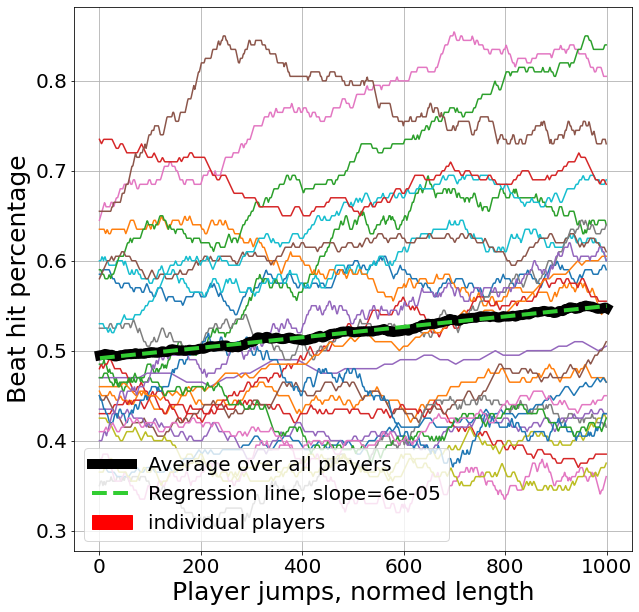

In [13]:
import seaborn as sns
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
def rolling_average(beat_files, filter, actions ="action", game_version='?',divisions=200, maxlength=1000):

    
    fig, ax=plt.subplots(figsize=(10,10))
    all_avg = []
    for f in beat_files:

        df_beat = pd.read_csv(os.path.join(mypath, f),sep=',', skiprows=1)
        df_beat = df_beat[df_beat["Action"].isin(filter)]

        
        time = np.array(df_beat["Time"])
        hits = np.array(df_beat["Beathit"])
        
        #avg2 = df_beat['Beathit'].rolling(divisions).mean()
        avg = moving_average(hits, divisions)
        
        # interpolate to scale number of total actions to uniform length
        avg = np.interp(np.linspace(0, 1, maxlength),np.linspace(0, 1, len(avg)), avg)
        ax.plot(avg)
        #ax.plot(avg2)
        all_avg.append(avg)
    
    #size = min([len(l) for l in all_avg])
    #all_avg = np.array([l[0:size] for l in all_avg])
    all_avg = np.mean(all_avg, axis=0)
    m,b = np.polyfit(np.arange(1,len(all_avg)+1),all_avg,1)
    poly1d_fn = np.poly1d((m,b))
    x = np.arange(1,len(all_avg)+1)
    #ax.plot(np.arange(1,len(all_avg)+1), all_avg, poly1d_fn(np.arange(1,len(all_avg)+1)), '--k', linewidth=3.0, color='black', label="Average over all players")

    ax.plot(x, all_avg, linewidth=10.0, color='black', label="Average over all players")
    ax.plot(x, poly1d_fn(x), '--k',linewidth=4.0, color='limegreen', label=f"Regression line, slope={round(m,5)}")
    
    #ax.set_title(f"Version {game_version}: Beat hit accuracy rolling average. windowsize = {divisions}", fontsize=25)
    ax.set_ylabel("Beat hit percentage", fontsize=25)
    ax.set_xlabel(f"Player {actions}, normed length", fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    
    handles, labels = ax.get_legend_handles_labels()
    patch = mpatches.Patch(color='red', label='individual players')
    handles.append(patch) 
    ax.legend(fontsize=20, handles=handles, loc='lower left')
    ax.grid(True)
    plt.savefig(f"Beat hit accuracy rolling average_{game_version}_{actions}.png")
    plt.show()
rolling_average(beat_metrics_controlled, action_filter_jumps, actions="jumps", game_version='A', divisions=200)

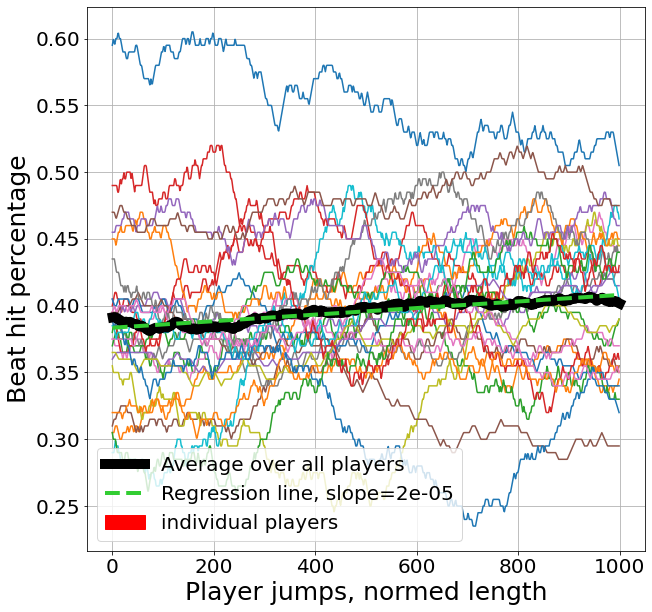

In [14]:
rolling_average(beat_metrics_no_rhythm, action_filter_jumps, actions="jumps", game_version='B', divisions=200)

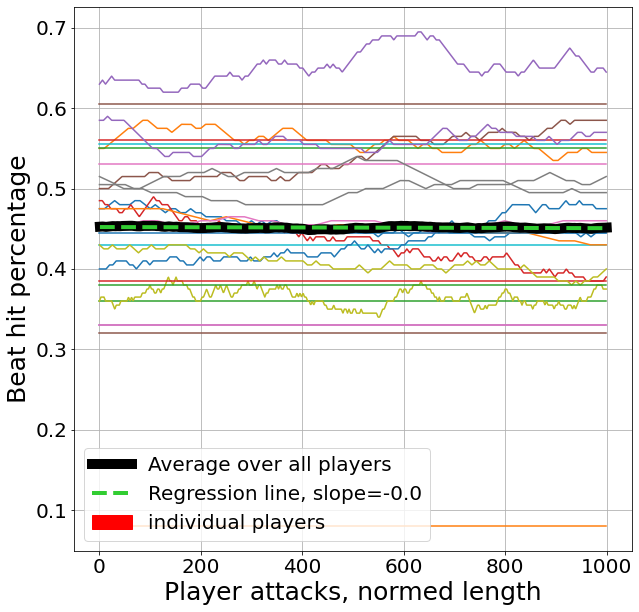

In [15]:
rolling_average(beat_metrics_controlled, action_filter_attacks, actions="attacks", game_version='A', divisions=200)

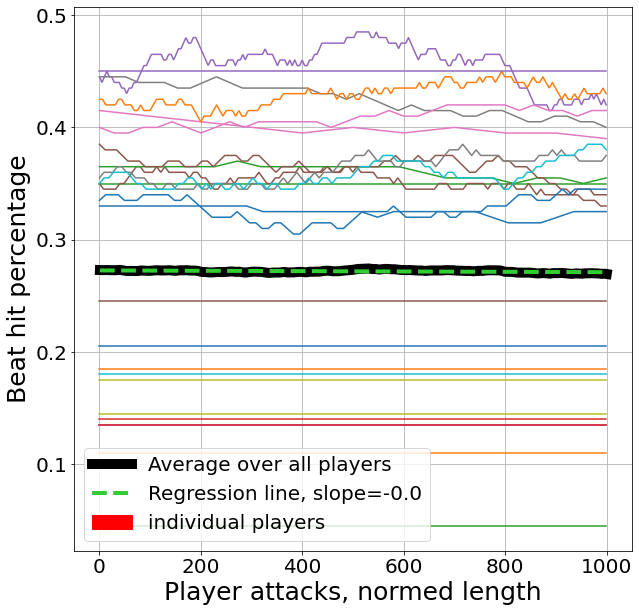

In [16]:
rolling_average(beat_metrics_no_rhythm, action_filter_attacks, actions="attacks", game_version='B', divisions=200)

# Average Stats for players for different Game Versions

In [17]:
# Betty. She knows where you've been.

states = {"Tutorial": 0, "Underground": 1, "Deepunderground" : 2, "Forest": 3, "Mushroom": 4, "Treetop": 5, "RedUnderground" : 6, "Spider": 7}
regions = {value: key for (key, value) in states.items()}

def region_state_machine(df_various, verbos = False):
    checkpoint_state = states["Tutorial"]
    state = states["Tutorial"]
    state_changes = []
    state_changes.append([0,state])
    previous = state
    for time, transition in zip(df_various["Time"],df_various["Action"]):
        if "Region" in transition:
            if state == states["Tutorial"]:
                #print("Tutorial")
                if transition == "Region underground entry 1":
                    state = states["Underground"]
                elif transition == "Region underground entry 2":
                    state = states["Deepunderground"]                
                elif transition == "Region 2nd forest start":
                    state = states["Forest"]
                elif "treetop" in transition:
                    state = states["Treetop"]
                elif "2nd forest" in transition:
                    state = states["Forest"]
                elif "deep underground" in transition:
                    state = states["Deepunderground"]
                elif "underground" in transition:
                    state= states["Underground"]
            elif state == states["Underground"]:
                #print("Underground")
                if transition == "Region first boss fight end":
                    state = states["Tutorial"]
                elif "deep underground" in transition:
                    state = states["Deepunderground"]
                elif transition == "Region underground entry 2":
                    state = states["Deepunderground"]
                elif transition == "Region 2nd forest start":
                    state = states["Forest"]
                elif transition == "Region Spider nest":
                    state = states["Spider"] # this one is illegal only deepunderground can transition to spider
            elif state == states["Deepunderground"]:
                #print("Deepunderground")
                if "deep underground" in transition:
                    state = states["Underground"]
                elif transition == "Region underground entry 2":
                    state = states["Tutorial"]
                elif transition == "Region Spider nest":
                    state = states["Spider"]
            elif state == states["Forest"]:
                #print("Forest")
                if transition == "Region first boss fight end":
                    state = states["Tutorial"]
                elif transition == "Region underground entry 1":
                    state = states["Underground"]
                elif transition == "Region 2nd forest end":
                    state = states["Mushroom"]
                elif "mushroom" in transition:
                    state = states["Mushroom"]
            elif state == states["Mushroom"]:
                #print("Mushroom")
                if transition == "Region 2nd forest end":
                    state = states["Forest"]
                elif transition == "Region treetop mushroom entry":
                    state = states["Treetop"]
                elif transition == "Region red underground entry":
                    state = states["RedUnderground"]
            elif state == states["Treetop"]:
                if transition == "Region treetop mushroom entry":
                    state = states["Mushroom"]
                elif transition == "Region treetop exit to tutorial forest":
                    state = states["Tutorial"]
                elif "first boss" in transition:
                    state = states["Tutorial"]
                elif "tutorial" in transition:
                    state = states["Tutorial"]
            elif state == states["RedUnderground"]:
                if transition == "Region red underground entry":
                    state = states["Mushroom"]
            elif state == states["Spider"]:
                if transition == "Region Spider nest":
                    state = states["Deepunderground"]
                    
            # failsaves for every state        
            if transition in ["Region jump tutorial start", "Region jump tutorial end", "Region first boss fight"]:
                state = states["Tutorial"]
            if transition in ["Region underground songtree entry"]:
                state = states["Underground"]
            if transition in ["Region red underground get over spikes jump riddle", "Region red underground bossplatform start", "Region red underground bossplatform end"]:
                state = states["RedUnderground"]
            if transition in ["Region 2nd forest spire 1", "Region 2nd forest spire 2"]:
                state = states["Forest"]
            if transition in ["Region mushroom downward entry", "Region mushroom slime boss start", "Region mushroom slime boss end", "Region mushroom songtree cliff", "Region mushroom lower platform right", "Region mushroom lower platform left"]:
                state = states["Mushroom"]
            if transition in ["Region treetop songtree", "Region treetop top spaceship platform", "Region treetop lower platform after songtree", "Region treetop leftmost spaceship platform", "Region treetop low spaceship platform"]:
                state = states["Treetop"]
                
            if verbos:
                print(f"{time} {transition} -> {regions[state]}")
        if transition== "player death":
            # set state to whatever state the active checkpoint is in
            state = checkpoint_state
            
            if verbos:
                print(f"{time} player death -> {regions[state]}")
        if "Checkpoint Activated" in transition:
            if "tutorial" in transition:
                checkpoint_state = states["Tutorial"]
            elif "forest" in transition:
                checkpoint_state = states["Forest"]
            elif "mushroom" in transition:
                checkpoint_state = states["Mushroom"]
            elif "spider" in transition:
                checkpoint_state = states["Spider"]
            elif "treetop" in transition:
                checkpoint_state = states["Treetop"]
            elif "underground red" in transition:
                checkpoint_state = states["RedUnderground"]
            elif "underground" in transition:
                checkpoint_state = states["Underground"]
            else:
                checkpoint_state = state
            state = checkpoint_state
            
        if "SpaceShip collected" in transition:
            if "tutorial" in transition:
                state = states["Tutorial"]
            elif "second_underground" in transition:
                state = states["RedUnderground"]
            elif "underground" in transition:
                state = states["Deepunderground"]
            elif "mushroom" in transition:
                state = states["Mushroom"]
            elif "treetop" in transition:
                state = states["Treetop"]
            elif "spider" in transition:
                state = states["Spider"]
            if verbos:
                print(f"{time} space ship collected -> {regions[state]}")
        if state != previous:
            if verbos:
                print(f"state change !!!!!")
            state_changes.append([time, state])
            previous = state
    return state_changes
            #print(f"{time } checkpoint {transition} in {regions[checkpoint_state]}")
# player death messes things up. upon player death reset the state to whatever region the last active checkpoint is located in            

In [18]:
# percantage of hits for rhythm controlled and No Rhythm
def hit_percentage(label,df_beat,verbos=True):
    hit = np.count_nonzero(df_beat["Beathit"])
    cnt = len(df_beat["Beathit"])
    percentage = round((hit/cnt) * 100,2)
    if verbos:
        print(f"{label} hits: {hit}/{cnt} = {percentage} %")
    return hit, cnt, percentage
    

def region_discovery(state_change, game_end_time=1200, verbos=True):
    state_time = state_change[:,0]
    state_state = state_change[:,1]
    
    unique = len(np.unique(state_state))
    total = 8
    percentage = round((unique/total)*100,2)
    if verbos:
        print(f"unique regions discovered: {unique}/{total} = {percentage} %")
        print(f"total region changes: {len(state_state)}")
    #time spent in region
    regiontime = {"Tutorial": 0, "Underground": 0, "Deepunderground" : 0, "Forest": 0, "Mushroom": 0, "Treetop": 0, "RedUnderground" : 0, "Spider": 0}
    for index in range(len(state_state)):
        start, end = state_time[index], game_end_time
        if index < len(state_state)-1:
            end = state_time[index+1]
        regiontime[regions[state_state[index]]] += end - start
    if verbos:
        print(f"time spent in regions: {regiontime}")
    return unique, percentage, len(state_state), regiontime

    
def song_playtime(df_songchange, game_end_time=1200, verbos=True):
    # time spent in each song
    songchange = list(df_songchange["Action"])
    songchange_time= list(df_songchange["Time"])
    playtime = {"SongChange 0":0, "SongChange 1":0, "SongChange 2":0}
    for index in range(len(songchange)):
        start, end = songchange_time[index], game_end_time
        if index < len(songchange)-1:
            end = songchange_time[index+1]
        playtime[songchange[index]] += end - start
    if verbos:
        print(f"time spent in songs: {playtime}")
    return playtime ,len(songchange)


def player_death(df_deaths_player, verbos=True):
    player_combat_death_mask = np.array(~df_deaths_player["HitBy"].str.contains("Boundaries|spike", case=False, regex=True))
    death_number = np.arange(1,len(df_deaths_player["Time"])+1)
    combat_deaths = len(death_number[player_combat_death_mask])
    jumpnrun_deaths = len(death_number[~player_combat_death_mask])
    
    spike_deaths = len(df_deaths_player.loc[df_deaths_player["HitBy"].str.contains("spike", case=False)])
    if verbos:
        print(f"player combat deaths: {combat_deaths}, player jumpnrun deaths: {jumpnrun_deaths-spike_deaths}, spike deaths {spike_deaths}")
    return combat_deaths, jumpnrun_deaths-spike_deaths, spike_deaths
    
    
def enemy_death(df_enemy_death, verbos=True):
    enemy_deaths = len(df_enemy_death)
    if verbos:
        print(f"enemy deaths: {enemy_deaths}")
    return enemy_deaths


def spaceship_cnt(df_spaceship, verbos=True):
    cnt = len(df_spaceship)
    total = 9
    percentage = round((cnt/total) * 100,2)
    if verbos:
        print(f"space ship parts collected: {cnt}/{total} = {percentage} %")
    return cnt, percentage


def combat_damage(df_combat, verbos = True):
    
    df_damage = df_combat.loc[df_combat["Action"].str.contains("damaged|death", case=False, regex=True)]
    player_damaged = df_damage.loc[df_damage["Entity"].str.contains("player", case=False)]
    player_damaged = player_damaged.loc[~player_damaged["HitBy"].str.contains("spike|Boundaries", case=False, regex=True)]# ignore spikes and boundaries for player damaged
    player_damage_cnt = len(player_damaged)
    player_against_type_set = set(player_damaged["HitBy"])
    player_fight_against_type = len(player_against_type_set)

    player_healed = df_combat.loc[df_combat["Action"].str.contains("heal", case=False)]
    player_healed_cnt = len(player_healed)
    

    enemy_damaged = df_damage.loc[df_damage["HitBy"].str.contains("player", case=False)]
    #print(enemy_damaged)
    enemy_damage_cnt = len(enemy_damaged)
    enemy_damaged_type_set = set(enemy_damaged["Entity"])
    enemy_damaged_type_cnt = len(enemy_damaged_type_set)
        
    if verbos:
        print(f"player damaged {player_damage_cnt} times. Hit by {player_fight_against_type} enemy types: {player_against_type_set}")
        print(f"player healed {player_healed_cnt}")
        print(f"enemy damaged {enemy_damage_cnt} times. {enemy_damaged_type_cnt} enemy types damaged: {enemy_damaged_type_set}")
    #print(player_damaged, player_healed, enemy_damaged, sep='\n')
    return player_damage_cnt, player_fight_against_type, player_healed_cnt, enemy_damage_cnt, enemy_damaged_type_cnt


from datetime import datetime
#Analyse(beat_metrics[0], various_metrics[0], combat_metrics[0])
def get_player_files(playernumber: str, version: str = "Controlled", played_as = 0):
    player_metrics = [f for f in onlyfiles if playernumber in f]
    player_metrics_norhythm = [f for f in player_metrics if "NoRhythm" in f]
    player_metrics_controlled = [f for f in player_metrics if "RhythmControlled" in f]
    
    norhythm_various = [f for f in player_metrics_norhythm if "Various_Metric" in f]
    norhythm_beat = [f for f in player_metrics_norhythm if "Beat_Metric" in f]
    norhythm_combat = [f for f in player_metrics_norhythm if "Combat_Metric" in f]
    norhythm_date_time_obj = datetime.strptime('_'.join(norhythm_beat[0].split('_')[2:7]), '%d_%m_%y_%H_%M')
    
    controlled_various = [f for f in player_metrics_controlled if "Various_Metric" in f]
    controlled_beat = [f for f in player_metrics_controlled if "Beat_Metric" in f]
    controlled_combat = [f for f in player_metrics_controlled if "Combat_Metric" in f]
    controlled_date_time = datetime.strptime('_'.join(controlled_beat[0].split('_')[2:7]), '%d_%m_%y_%H_%M')
    
    if version == "Controlled":
        if played_as == 1 and controlled_date_time > norhythm_date_time_obj: #version we are asking for is second
            return None
        if played_as == 2 and controlled_date_time < norhythm_date_time_obj: #version we are asking for is first
            return None
        return controlled_beat[0], controlled_various[0], controlled_combat[0]
    else:
        if played_as == 1 and controlled_date_time < norhythm_date_time_obj: # version we are asking for is second
            return None
        if played_as == 2 and controlled_date_time > norhythm_date_time_obj: # version we are asking for is first
            return None
        return norhythm_beat[0], norhythm_various[0], norhythm_combat[0]

In [19]:
def analysis_stats(beat, various, combat, verbos=False):
    if not isinstance(beat, str):
        raise TypeError("The beat wasn't passed as a String")
    #print(beat, various, combat)
    
    #prepare and read data
    df_beat = pd.read_csv(os.path.join(mypath, beat), sep=',', skiprows = 1)
    df_beat_jumps = df_beat[df_beat["Action"].isin(action_filter_jumps)]
    df_beat_attacks = df_beat[df_beat["Action"].isin(action_filter_attacks)]
    
    df_various = pd.read_csv(os.path.join(mypath, various), sep=',', skiprows = 1)
    df_various = df_various.drop_duplicates(subset= ["Time","Action"], keep='first')
    #df_input_device = df_various[df_various["Action"].isin(["Keyboard & Mouse", "Gamepad"])]
    state_change = np.array(region_state_machine(df_various)) # we call upon Betty once more
    df_spaceship = df_various.loc[df_various["Action"].str.contains("SpaceShip", case=True)]
    df_songchange = df_various.loc[df_various["Action"].str.contains("Songchange", case = False)] 

    df_combat = pd.read_csv(os.path.join(mypath, combat), sep=',', skiprows = 1)
    df_deaths = df_combat.loc[df_combat["Action"].str.contains("death", case=False)]
    df_deaths_enemy = df_deaths.loc[df_deaths["HitBy"].str.contains("Player", case=False)]
    df_deaths_player = df_deaths.loc[df_deaths["Entity"].str.contains("player", case=False)]
    df_deaths_player = df_deaths_player.loc[~df_deaths_player["HitBy"].str.contains("resetToCheckpoint", case=False)]
    
    game_end_time = max(list(df_various["Time"])[-1], list(df_beat["Time"])[-1])
    
    #get stats
    song_playtime_dict, song_changes = song_playtime(df_songchange, game_end_time, verbos)
    j_hit, j_cnt, j_percentage = hit_percentage("Jumps", df_beat_jumps, verbos)
    a_hit, a_cnt, a_percentage = hit_percentage("Attacks", df_beat_attacks, verbos)
    s_cnt, s_percentage = spaceship_cnt(df_spaceship, verbos)
    enemy_deaths = enemy_death(df_deaths_enemy, verbos)
    combat_deaths, boundary_deaths, spike_deaths = player_death(df_deaths_player, verbos)
    unique_regions_discovered, r_percentage, region_changes, region_time_dict = region_discovery(state_change, game_end_time, verbos)
    player_damage_cnt, player_damage_from_type, player_healed_cnt, enemy_damage_cnt, enemy_damaged_type_cnt = combat_damage(df_combat, verbos)
    
    return [j_hit, j_cnt, j_percentage,
            a_hit, a_cnt, a_percentage, 
            enemy_deaths,
            
            player_damage_cnt,  player_healed_cnt,
            combat_deaths, boundary_deaths, spike_deaths, 
            
            s_cnt, s_percentage,
            unique_regions_discovered, r_percentage, region_changes, 
            song_changes], song_playtime_dict, region_time_dict

# enemy_damage_cnt, enemy_damaged_type_cnt, player_damage_from_type,

titles= ["Jumps in union with beat", "Total jumps", "Percentage of jumps in beat", 
         "Attacks in union with beat", "Total attacks", "Percentage of attacks in beat", 
         "Enemy deaths",
         
         "Player got damaged by enemy", "Player got healed", 
         "Player deaths through combat", "Player deaths through falling", "Player deaths platformer elements",
         
         
        "Spaceships collected (max 9)", "Spaceship collection percentage",
        "Regions discovered (max 8)", "Regions discovered percentage", "Player entering a region",
         "World music changes"]

#"Enemy got damaged by player", "Enemy types got damaged (max 10)", 


def global_analysis(played_as=0, df = df, verbos = True): # 0 for either first or second, 1 for first, 2 for second
    np.set_printoptions(suppress=True)
    ret_stats = []
    ret_songtimes = []
    ret_regiontimes = []
    for version in ["Controlled", "NoRhythm"]: #A, B
        stats = []# stats, songtimes, regiontimes
        song_times = []
        region_times = []
        dataset_num = 0
        
        for tag in playertags:
            files = get_player_files(tag, version, played_as)
            if files is None:
                continue
            s, song_dict, region_dict = analysis_stats(*files)
            #print(tag, region_dict)
            dataset_num += 1
            stats.append(s)
            song_times.append(list(song_dict.values()))
            region_times.append(list(region_dict.values()))
        
        #calculate standard deviations
        stats_std =  np.rint(np.std(np.array(stats), axis=0)).astype(int)
        song_times_std =  np.rint(np.std(np.array(song_times), axis=0)).astype(int)
        region_times_std =  np.rint(np.std(np.array(region_times), axis=0)).astype(int)
        
        #calculate means
        stats = np.rint(np.mean(np.array(stats), axis=0)).astype(int)
        avg_song_times = np.rint(np.mean(song_times, axis=0)).astype(int)
        region_times = np.rint(np.mean(np.array(region_times), axis=0)).astype(int)
        
        ret_stats.append(stats)
        ret_stats.append(stats_std)
        
        ret_songtimes.append(avg_song_times)
        ret_songtimes.append(song_times_std)
        
        ret_regiontimes.append(region_times)
        ret_regiontimes.append(region_times_std)
        
        if verbos:
            print(f"\n\nVersion {version}, {dataset_num} players in datasets")
            for index in range(len(titles)):
                print(f"{titles[index]}: {stats[index]}")
            print(f"song times {song_times}")
            print(f"song playtimes: yellow {np.mean(song_times[:,0])}, blue {np.mean(song_times[:,1])}, red {np.mean(song_times[:,2])}")
            region_names = list(states.keys())
            for index in range(len(region_names)):
                print(f"{region_names[index]}: {region_times[index]}",end=' ')
    
    return ret_stats, ret_songtimes, ret_regiontimes # statsA, stdA, statsB, stdB 
    #print(region_times)

In [20]:
stats_df = pd.DataFrame()#columns=titles)
song_df = pd.DataFrame()#columns=["yellow", "blue", "red"])
region_df = pd.DataFrame()#columns=list(states.keys()))
columns = [['A','A std','B', 'B std'],['1A', '1A std', '1B','1B std'], ['2A','2A std', '2B', '2B std']] 

import pandas
cnt = 0
for i in range(3):
    ret_stats, ret_songtimes, ret_regiontimes = global_analysis(i, verbos = False)
    for line,column in zip(ret_stats,columns[i]):
        stats_df[column] = line
    for line,column in zip(ret_songtimes,columns[i]):
        song_df[column] = line
    for line,column in zip(ret_regiontimes,columns[i]):
        region_df[column] = line

        

def post_process_df(df, index_title, index_list):
    df.insert(0, column='Game Version', value = index_list)
    df.set_index('Game Version', inplace=True)
    #df = df.transpose()
    df.index.name = index_title
    return df

stats_df = post_process_df(stats_df, 'stat',titles)
song_df = post_process_df(song_df, 'song',["yellow", "blue", "red"])
region_df = post_process_df(region_df, 'region',list(states.keys()))

try:
    pass
    stats_df.to_csv("game_stat_analysis.csv", index=True)
    song_df.to_csv("game_song_analysis.csv", index=True)
    region_df.to_csv("game_region_analysis.csv", index=True)
except:
    print("coudnt save new verison\n")
    
print(f"game stats:\n{stats_df.to_string()}\n\n")
print(f"song time:\n{song_df.to_string()}\n\n")
print(f"region time:\n{region_df.to_string()}\n\n")

game stats:
                                     A  A std    B  B std   1A  1A std   1B  1B std   2A  2A std   2B  2B std
stat                                                                                                         
Jumps in union with beat           267     95  223     59  275      93  184      36  258      96  255      56
Total jumps                        507    107  558    123  505      92  488      99  508     123  614     111
Percentage of jumps in beat         52     11   40      5   54      11   38       2   50      12   41       5
Attacks in union with beat         118     47   69     43  121      45   88      38  114      49   54      41
Total attacks                      231    105  178    108  244     116  229      92  215      85  136     102
Percentage of attacks in beat       53     11   39      7   52      13   38       4   53       8   40       8
Enemy deaths                        23     13   34     23   23      10   43      17   24      16   26      2

# Graph+Stats per Player

In [21]:
import matplotlib
song_color = {"SongChange 0": 'gold', "SongChange 1": 'deepskyblue', "SongChange 2": 'lightcoral'}
region_color = {0: 'gold', 1: 'royalblue', 2 : 'purple', 3: 'green', 4: 'tomato', 5: "mediumturquoise", 6: "maroon", 7: "navy"}
#states = {"Tutorial": 0, "Underground": 1, "Deepunderground" : 2, "Forest": 3, "Mushroom": 4, "Treetop": 5, "RedUnderground" : 6, "Spider": 7}


def analysis_graphic(beat: str, various: str, combat: str, verbos = False):
    if not isinstance(beat, str):
        raise TypeError("The beat wasn't passed as a String")
    print(beat, various, combat)
    
    df_various = pd.read_csv(os.path.join(mypath, various), sep=',', skiprows = 1)
    df_various = df_various.drop_duplicates(subset= ["Time","Action"], keep='first')
    df_combat = pd.read_csv(os.path.join(mypath, combat), sep=',', skiprows = 1)
    df_input_device = df_various[df_various["Action"].isin(["Keyboard & Mouse", "Gamepad"])]
    df_beat = pd.read_csv(os.path.join(mypath, beat), sep=',', skiprows = 1)
    
    game_end_time = max(list(df_various["Time"])[-1], list(df_beat["Time"])[-1])
    
    df_songchange = df_various.loc[df_various["Action"].str.contains("Songchange", case = False)]
    songchange = list(df_songchange["Action"])
    songchange_time = list(df_songchange["Time"])                      
               
    fig, ax=plt.subplots(nrows = 2, ncols = 2 ,figsize=(20,20)) # sharex=True
    
    # Beat Plots
    def beat_delta_scatter_plot(title, ind1, ind2, action_filter):  # nested function goes brrrrrrrr
        df_beat_filtered = df_beat[df_beat["Action"].isin(action_filter)]
        
        # scatterplot time and beatdelta in red and green
        hit_filter = np.array(df_beat_filtered["Beathit"])
        t = np.array(df_beat_filtered["Time"])
        d = np.array(df_beat_filtered["BeatDelta"])
        
        ax[ind1, ind2].scatter(t[hit_filter],d[hit_filter], zorder=4, c="green", label="in union with beat")
        ax[ind1, ind2].scatter(t[~hit_filter],d[~hit_filter], zorder=4, c="red", label="missed the beat")
        
        # songchanges in background
        for index in range(len(songchange)):
            start, end = songchange_time[index], game_end_time
            if index < len(songchange)-1:
                end = songchange_time[index+1]
            ax[ind1, ind2].axvspan(start, end, facecolor=song_color[songchange[index]], alpha=0.3, zorder=3, label=f"{songchange[index]}")
        handels, labels = ax[ind1, ind2].get_legend_handles_labels()
        by_label = dict(zip(labels, handels))
        
        ax[ind1, ind2].legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=20)  
        ax[ind1, ind2].set_title(f"{title}", fontsize = 25)
        ax[ind1, ind2].set_ylabel("BeatDelta", fontsize = 25)
        ax[ind1, ind2].set_xlabel("Time", fontsize = 25)
        ax[ind1, ind2].tick_params(axis='both', which='major', labelsize=20)
        ax[ind1, ind2].tick_params(axis='both', which='minor', labelsize=20)
        ax[ind1, ind2].grid(True)
        
        hit_percentage(title, df_beat)
    
    beat_delta_scatter_plot("Jumps", 0, 0, action_filter_jumps)
    beat_delta_scatter_plot("Attacks", 0, 1, action_filter_attacks)
    song_playtime(df_songchange, game_end_time)
    
    #Progression Plot
    ind1, ind2 = 1,0
    df_spaceship = df_various.loc[df_various["Action"].str.contains("SpaceShip", case=True)]
    spaceships = list(df_spaceship["Action"])
    time = np.array(df_spaceship["Time"])
    if verbos:
        print("space ship dataframe", df_spaceship)
    ax[ind1, ind2].scatter(time,np.arange(1,len(spaceships)+1), zorder=4, color='black', linewidth=2.0, label="Spaceship Part Collected")
    time = np.insert(time, 0, 0)
    ax[ind1, ind2].plot(time,np.arange(0, len(spaceships)+1), zorder=4, color = 'black')

    state_change = np.array(region_state_machine(df_various,verbos)) # we call upon Betty
    state_time = state_change[:,0]
    state_state = state_change[:,1]
    for index in range(len(state_state)):
        start, end = state_time[index], game_end_time
        if index < len(state_state)-1:
            end = state_time[index+1]
        ax[ind1, ind2].axvspan(start, end, facecolor=region_color[state_state[index]], alpha=0.5, zorder=3, label=f"{regions[state_state[index]]} Region")

    ax[ind1, ind2].set_yticks(np.arange(0,10))
    ax[ind1, ind2].set_title(f"Exploration Progress", fontsize=25)
    ax[ind1, ind2].set_ylabel("Total Space Ship Parts Collected", fontsize=25)
    ax[ind1, ind2].set_xlabel("Time", fontsize = 25)
    handels, labels = ax[ind1, ind2].get_legend_handles_labels()
    by_label = dict(zip(labels, handels))
    ax[ind1, ind2].legend(by_label.values(), by_label.keys(), loc = 'lower right', fontsize=20)
    ax[ind1, ind2].tick_params(axis='both', which='major', labelsize=20)
    ax[ind1, ind2].tick_params(axis='both', which='minor', labelsize=20)
    ax[ind1, ind2].grid(True)
    
    spaceship_cnt(df_spaceship)
    region_discovery(state_change, game_end_time)
    
    # Combat Plot
    ind1, ind2 = 1,1
    df_deaths = df_combat.loc[df_combat["Action"].str.contains("death", case=False)]
    #print(df_deaths)
    

    df_deaths_enemy = df_deaths.loc[df_deaths["HitBy"].str.contains("Player", case=False)]
    
    df_deaths_player = df_deaths.loc[df_deaths["Entity"].str.contains("player", case=False)]
    df_deaths_player = df_deaths_player.loc[~df_deaths_player["HitBy"].str.contains("resetToCheckpoint", case=False)]
    player_death(df_deaths_player)
    enemy_death(df_deaths_enemy)
    combat_damage(df_combat)
    
    player_combat_death_mask = np.array(~df_deaths_player["HitBy"].str.contains("Boundaries|spike", case=False, regex=True))
    death_time = np.array(df_deaths_player["Time"])
    death_number = np.arange(1,len(df_deaths_player["Time"])+1)
    
    
    ax[ind1, ind2].scatter(df_deaths_enemy["Time"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemy alien death", linewidth=2.0, color='darkorange')
    ax[ind1, ind2].scatter(death_time[player_combat_death_mask], death_number[player_combat_death_mask], label="Player death combat",linewidth=2.0, color='blue')
    ax[ind1, ind2].scatter(death_time[~player_combat_death_mask], death_number[~player_combat_death_mask], label="Player death through spikes or level boundaries", linewidth=2.0, color='blue', marker='x')
    
    ax[ind1, ind2].set_title(f"Combat", fontsize = 25)
    ax[ind1, ind2].set_ylabel("Deaths", fontsize = 25)
    ax[ind1, ind2].set_xlabel("Time", fontsize = 25)
    ax[ind1, ind2].legend(loc = 'upper left', fontsize=20)
    ax[ind1, ind2].tick_params(axis='both', which='major', labelsize=20)
    ax[ind1, ind2].tick_params(axis='both', which='minor', labelsize=20)
    ax[ind1, ind2].grid(True)
    
    # Global plot settings
    #fig.suptitle (f"{beat}", fontsize = 20)
    ax[0,1].sharex(ax[0,0])
    ax[1,0].sharex(ax[0,0])
    ax[1,1].sharex(ax[0,0])
    ax[0,1].sharey(ax[0,0])
    tag = '_'.join(beat.split('_')[0:2])
    plt.savefig(f"individualplayers/{tag}_plot.png")
    plt.show()

In [22]:
#analysePlayer("045522", "NoRhythm", verbos=False)
#analysePlayer("088835", "NoRhythm")
#analysis_graphic(*get_player_files("000990", "NoRhythm"), verbos=False)
#analysis_graphic(*get_player_files("976861", "Controlled"), verbos=False)

# by_index = 15
#analysis_graphic(beat_metrics[by_indes],various_metrics[by_index],combat_metrics[by_index])

000990_NoRhythm_04_12_21_12_39_Beat_Metric.csv 000990_NoRhythm_04_12_21_12_39_Various_Metric.csv 000990_NoRhythm_04_12_21_12_39_Combat_Metric.csv
Jumps hits: 398/716 = 55.59 %
Attacks hits: 398/716 = 55.59 %
time spent in songs: {'SongChange 0': 366, 'SongChange 1': 279, 'SongChange 2': 568}
space ship parts collected: 7/9 = 77.78 %
unique regions discovered: 7/8 = 87.5 %
total region changes: 29
time spent in regions: {'Tutorial': 88, 'Underground': 60, 'Deepunderground': 73, 'Forest': 163, 'Mushroom': 540, 'Treetop': 84, 'RedUnderground': 205, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 1, spike deaths 4
enemy deaths: 6
player damaged 4 times. Hit by 1 enemy types: {'Slime'}
player healed 91
enemy damaged 8 times. 3 enemy types damaged: {'Bat', 'Spider', 'Slime'}


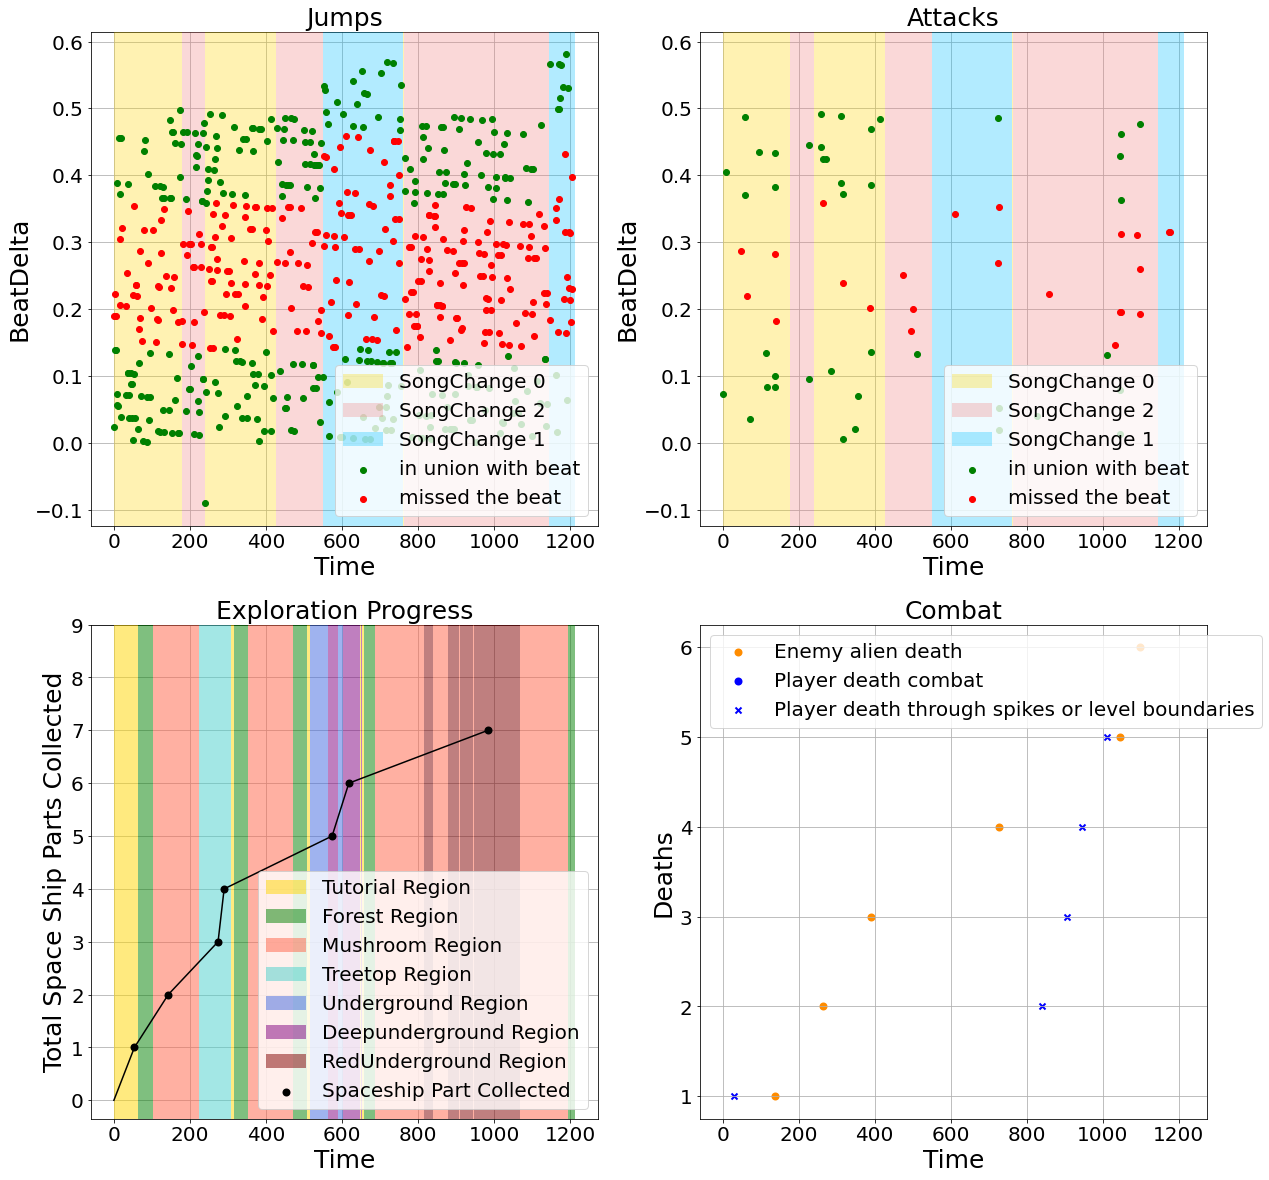

000990_RhythmControlled_04_12_21_12_11_Beat_Metric.csv 000990_RhythmControlled_04_12_21_12_11_Various_Metric.csv 000990_RhythmControlled_04_12_21_12_11_Combat_Metric.csv
Jumps hits: 456/828 = 55.07 %
Attacks hits: 456/828 = 55.07 %
time spent in songs: {'SongChange 0': 224, 'SongChange 1': 585, 'SongChange 2': 371}
space ship parts collected: 3/9 = 33.33 %
unique regions discovered: 7/8 = 87.5 %
total region changes: 20
time spent in regions: {'Tutorial': 155, 'Underground': 190, 'Deepunderground': 46, 'Forest': 237, 'Mushroom': 355, 'Treetop': 98, 'RedUnderground': 99, 'Spider': 0}
player combat deaths: 2, player jumpnrun deaths: 7, spike deaths 1
enemy deaths: 9
player damaged 30 times. Hit by 5 enemy types: {'Slime', 'resetToCheckpoint', 'Beholder', 'Worm', 'Bat'}
player healed 37
enemy damaged 12 times. 6 enemy types damaged: {'Crab', 'Slime', 'Beholder', 'Demon', 'Worm', 'Bat'}


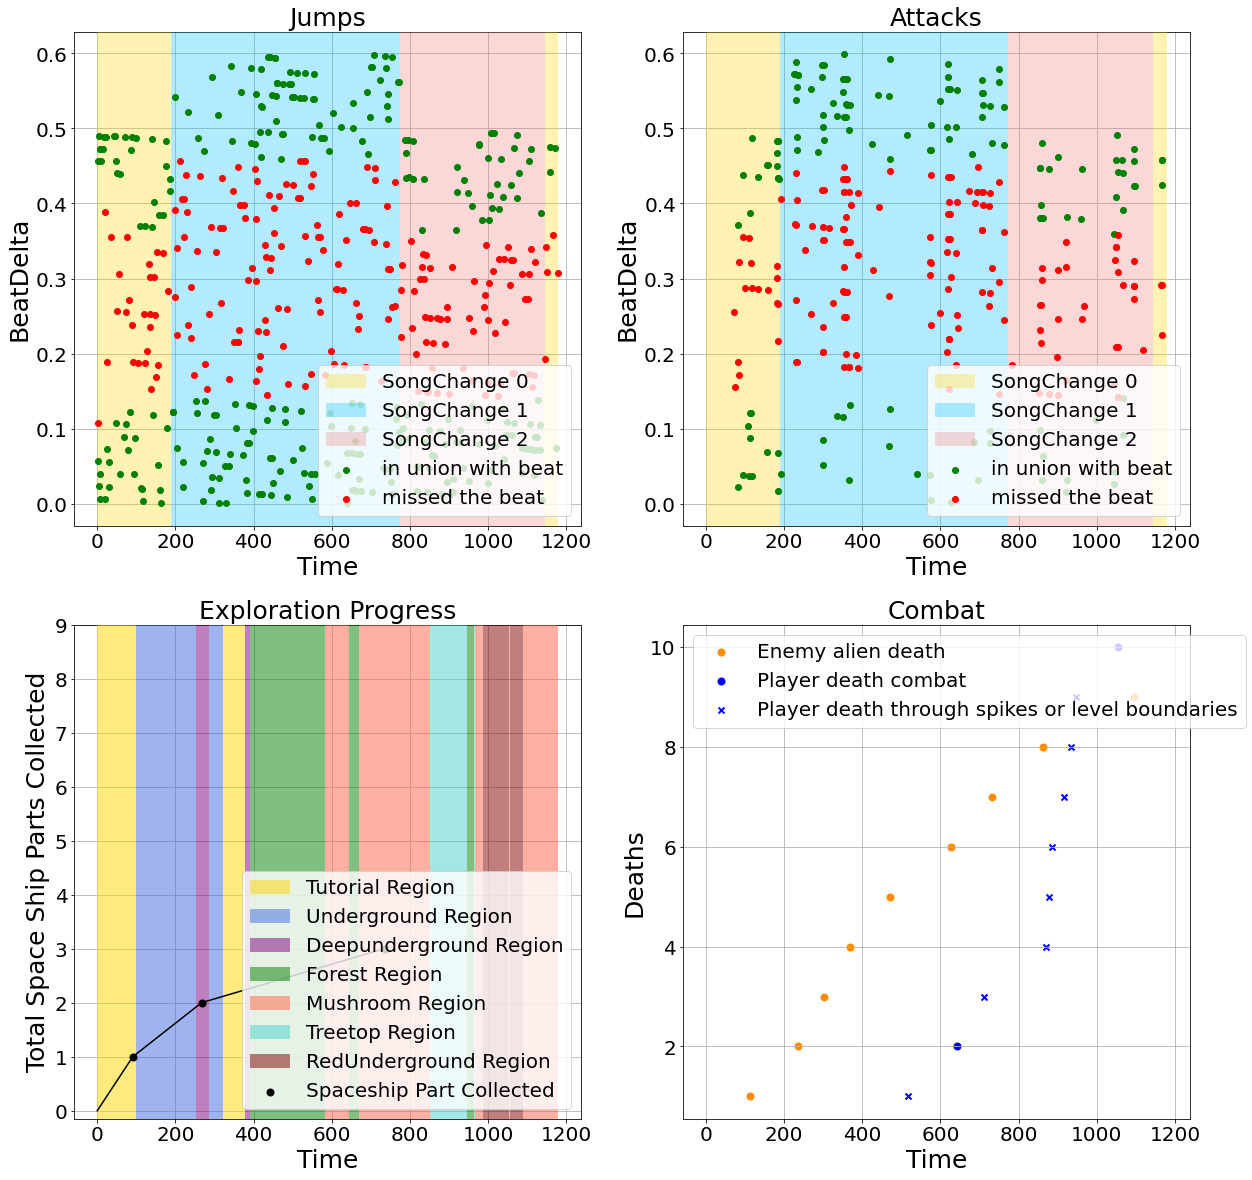

045522_NoRhythm_10_12_21_02_08_Beat_Metric.csv 045522_NoRhythm_10_12_21_02_08_Various_Metric.csv 045522_NoRhythm_10_12_21_02_08_Combat_Metric.csv
Jumps hits: 237/676 = 35.06 %
Attacks hits: 237/676 = 35.06 %
time spent in songs: {'SongChange 0': 145, 'SongChange 1': 573, 'SongChange 2': 322}
space ship parts collected: 9/9 = 100.0 %
unique regions discovered: 8/8 = 100.0 %
total region changes: 33
time spent in regions: {'Tutorial': 92, 'Underground': 224, 'Deepunderground': 175, 'Forest': 66, 'Mushroom': 169, 'Treetop': 224, 'RedUnderground': 41, 'Spider': 49}
player combat deaths: 0, player jumpnrun deaths: 0, spike deaths 0
enemy deaths: 28
player damaged 6 times. Hit by 3 enemy types: {'Beholder', 'Plant', 'Slime'}
player healed 58
enemy damaged 54 times. 5 enemy types damaged: {'Spider', 'Beholder', 'Demon', 'Worm', 'Bat'}


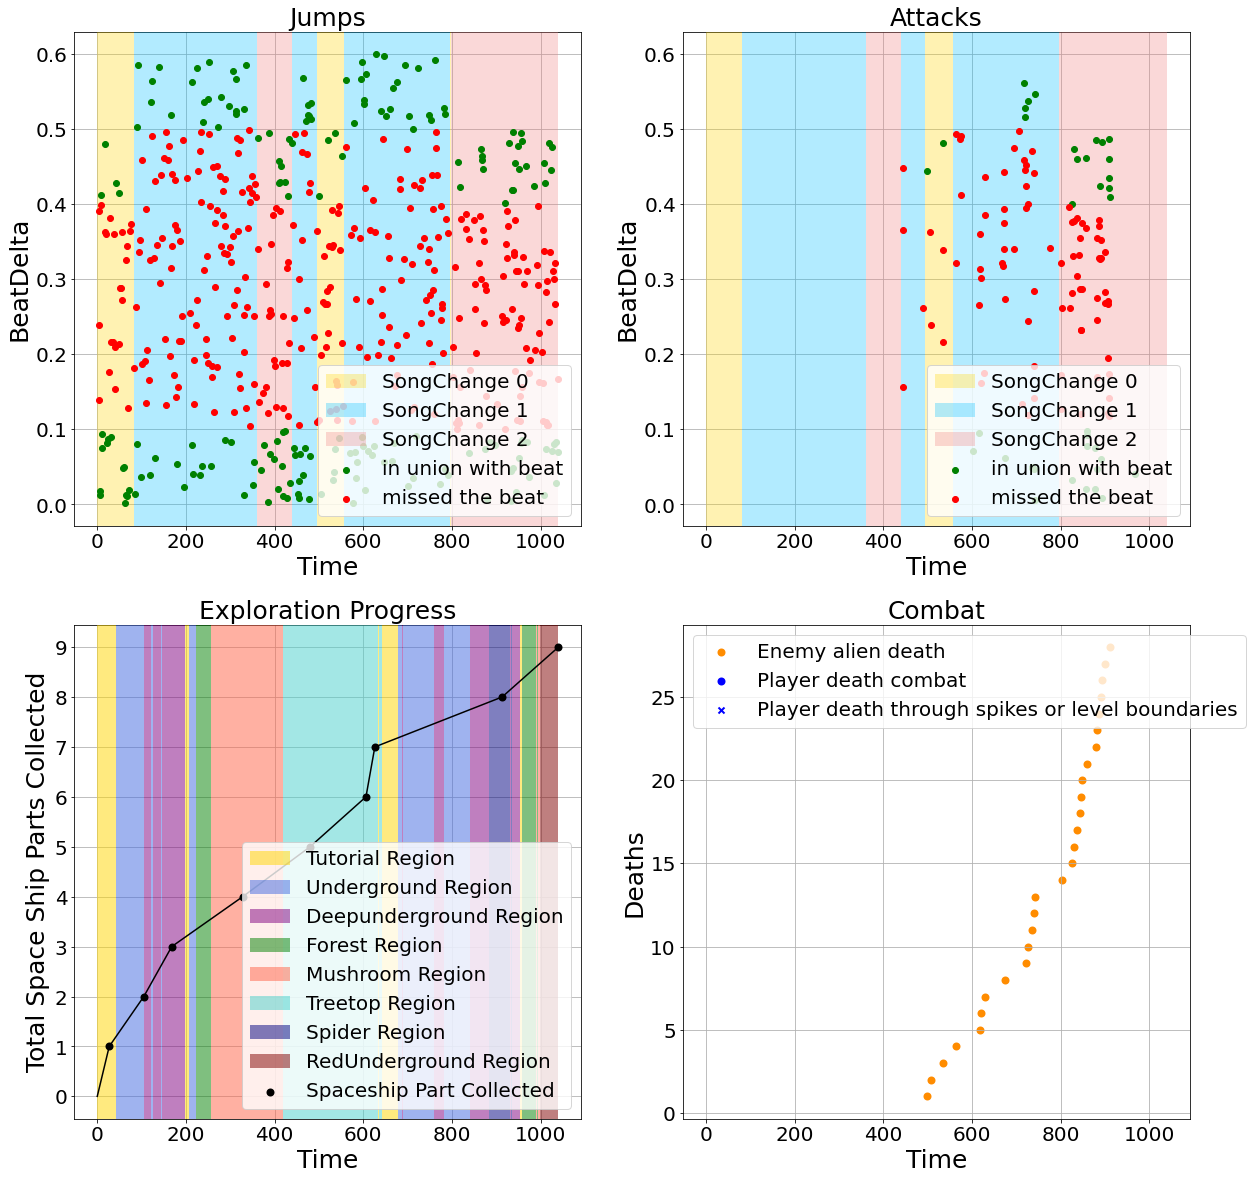

045522_RhythmControlled_10_12_21_01_39_Beat_Metric.csv 045522_RhythmControlled_10_12_21_01_39_Various_Metric.csv 045522_RhythmControlled_10_12_21_01_39_Combat_Metric.csv
Jumps hits: 407/841 = 48.39 %
Attacks hits: 407/841 = 48.39 %
time spent in songs: {'SongChange 0': 273, 'SongChange 1': 814, 'SongChange 2': 108}
space ship parts collected: 2/9 = 22.22 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 9
time spent in regions: {'Tutorial': 178, 'Underground': 208, 'Deepunderground': 83, 'Forest': 222, 'Mushroom': 501, 'Treetop': 3, 'RedUnderground': 0, 'Spider': 0}
player combat deaths: 2, player jumpnrun deaths: 1, spike deaths 1
enemy deaths: 44
player damaged 73 times. Hit by 7 enemy types: {'Plant', 'Slime', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}
player healed 60
enemy damaged 54 times. 7 enemy types damaged: {'Crab', 'Slime', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


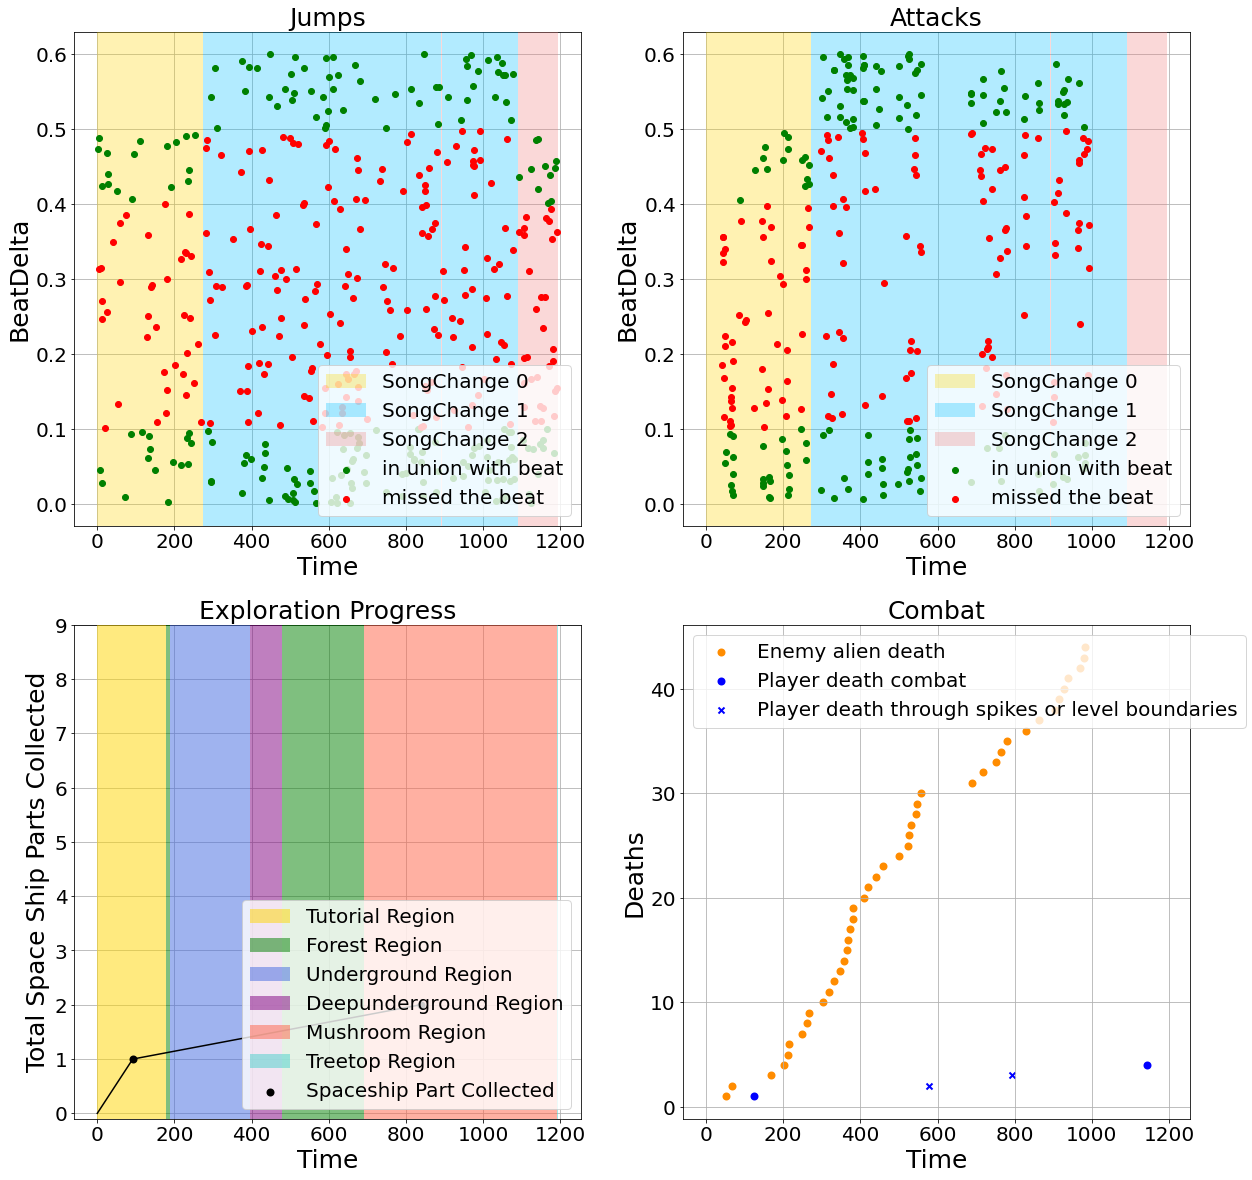

061295_NoRhythm_05_12_21_05_27_Beat_Metric.csv 061295_NoRhythm_05_12_21_05_27_Various_Metric.csv 061295_NoRhythm_05_12_21_05_27_Combat_Metric.csv
Jumps hits: 342/918 = 37.25 %
Attacks hits: 342/918 = 37.25 %
time spent in songs: {'SongChange 0': 469, 'SongChange 1': 0, 'SongChange 2': 742}
space ship parts collected: 4/9 = 44.44 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 12
time spent in regions: {'Tutorial': 63, 'Underground': 4, 'Deepunderground': 0, 'Forest': 58, 'Mushroom': 605, 'Treetop': 123, 'RedUnderground': 358, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 0, spike deaths 2
enemy deaths: 25
player damaged 14 times. Hit by 3 enemy types: {'Beholder', 'Crab', 'Spider'}
player healed 69
enemy damaged 42 times. 8 enemy types damaged: {'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


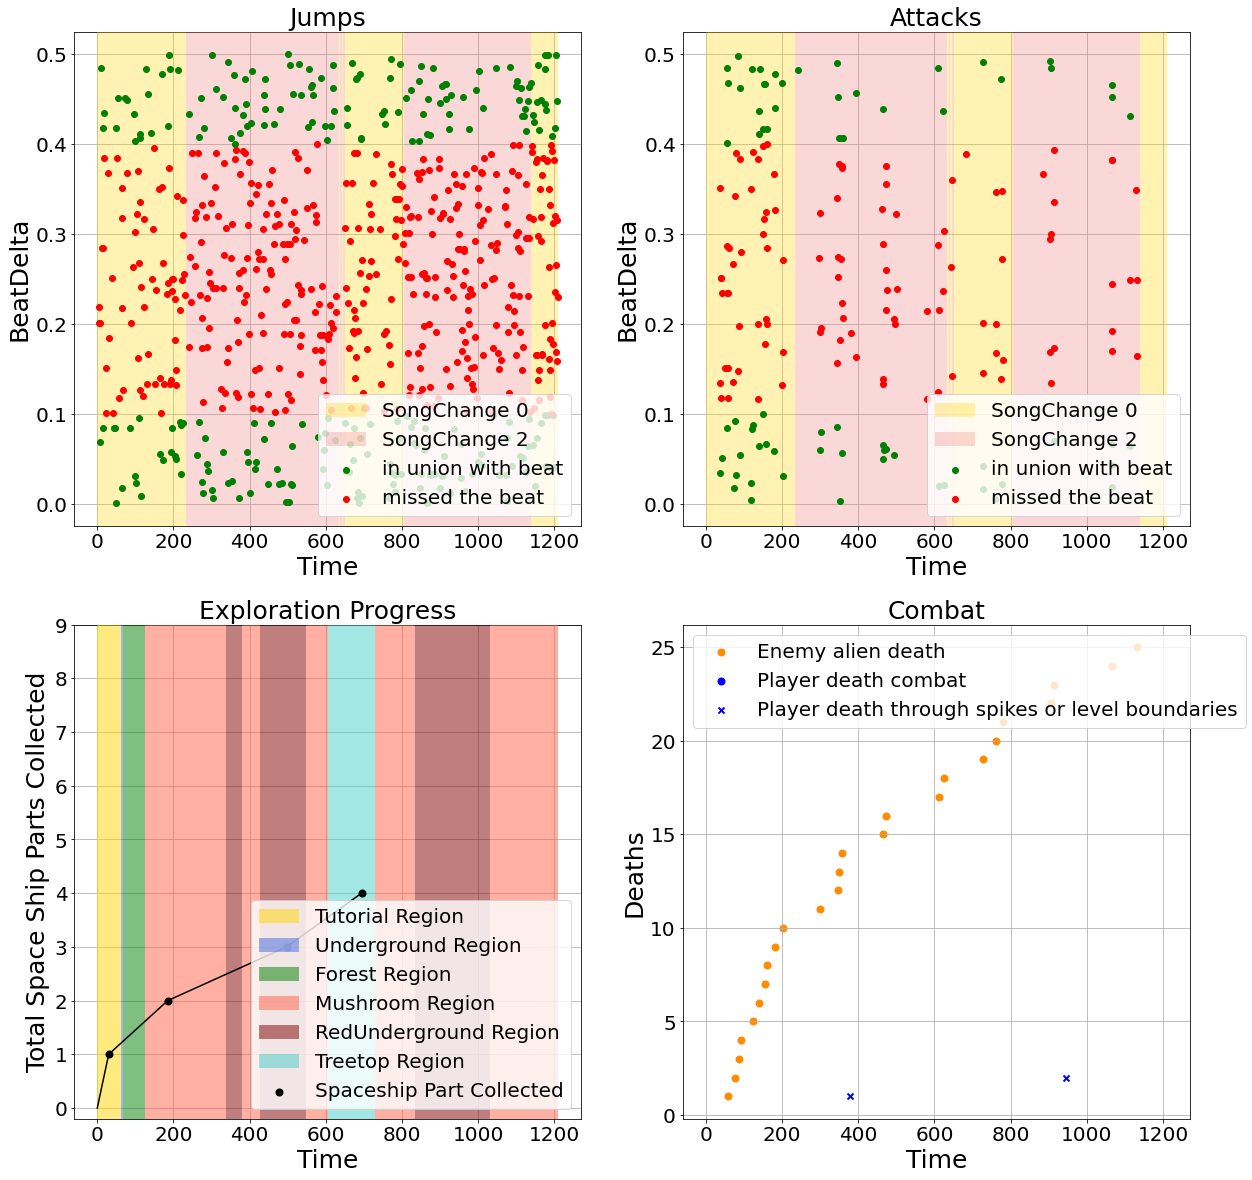

061295_RhythmControlled_05_12_21_05_53_Beat_Metric.csv 061295_RhythmControlled_05_12_21_05_53_Various_Metric.csv 061295_RhythmControlled_05_12_21_05_53_Combat_Metric.csv
Jumps hits: 473/873 = 54.18 %
Attacks hits: 473/873 = 54.18 %
time spent in songs: {'SongChange 0': 122, 'SongChange 1': 571, 'SongChange 2': 501}
space ship parts collected: 4/9 = 44.44 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 23
time spent in regions: {'Tutorial': 103, 'Underground': 83, 'Deepunderground': 135, 'Forest': 143, 'Mushroom': 469, 'Treetop': 0, 'RedUnderground': 261, 'Spider': 0}
player combat deaths: 1, player jumpnrun deaths: 1, spike deaths 1
enemy deaths: 11
player damaged 39 times. Hit by 6 enemy types: {'Slime', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}
player healed 47
enemy damaged 12 times. 6 enemy types damaged: {'Spider', 'Slime', 'Demon', 'Bat', 'Worm', 'Turtle'}


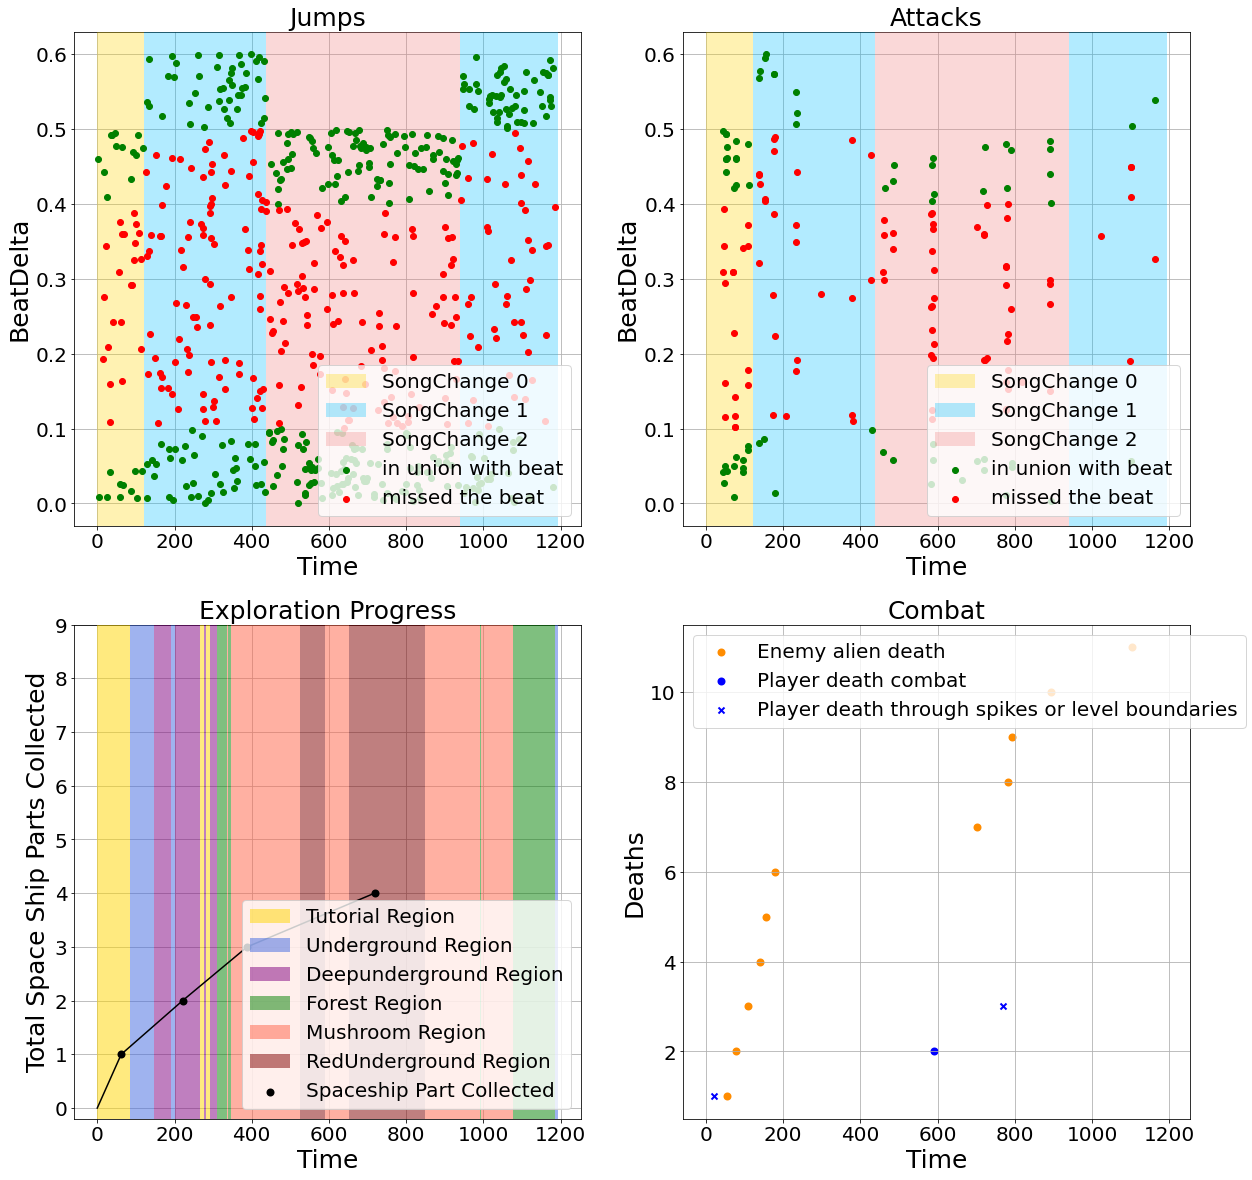

088835_NoRhythm_21_11_21_05_42_Beat_Metric.csv 088835_NoRhythm_21_11_21_05_42_Various_Metric.csv 088835_NoRhythm_21_11_21_05_42_Combat_Metric.csv
Jumps hits: 281/695 = 40.43 %
Attacks hits: 281/695 = 40.43 %
time spent in songs: {'SongChange 0': 104, 'SongChange 1': 556, 'SongChange 2': 406}
space ship parts collected: 9/9 = 100.0 %
unique regions discovered: 8/8 = 100.0 %
total region changes: 29
time spent in regions: {'Tutorial': 95, 'Underground': 144, 'Deepunderground': 204, 'Forest': 41, 'Mushroom': 224, 'Treetop': 188, 'RedUnderground': 137, 'Spider': 33}
player combat deaths: 0, player jumpnrun deaths: 2, spike deaths 1
enemy deaths: 13
player damaged 18 times. Hit by 3 enemy types: {'Bat', 'Spider', 'Slime'}
player healed 41
enemy damaged 31 times. 7 enemy types damaged: {'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


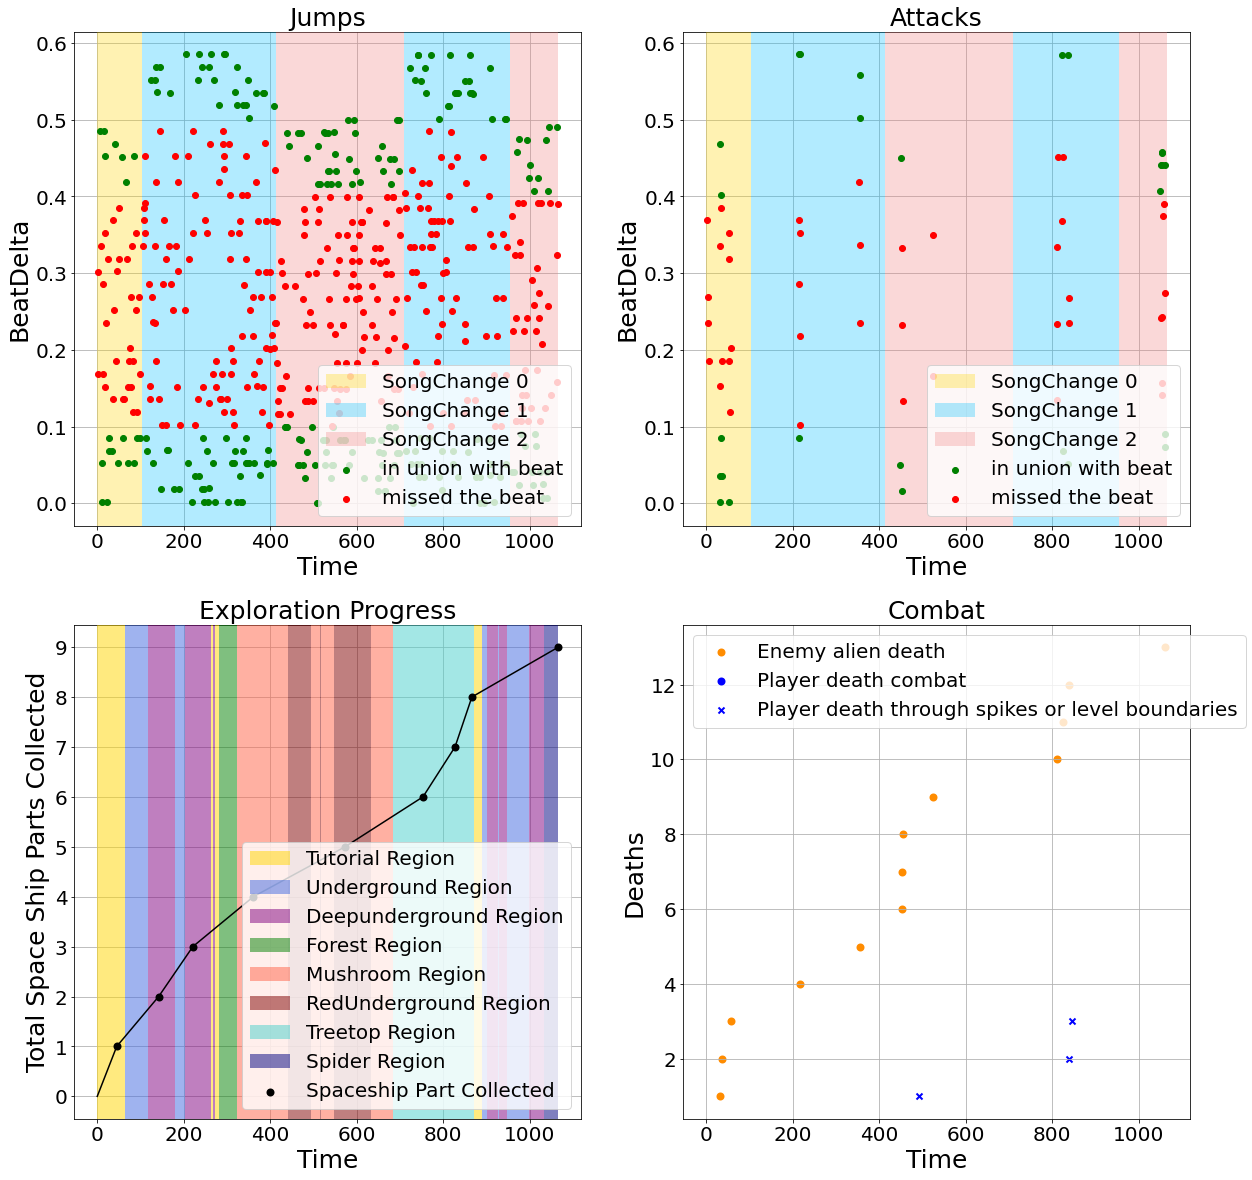

088835_RhythmControlled_21_11_21_05_13_Beat_Metric.csv 088835_RhythmControlled_21_11_21_05_13_Various_Metric.csv 088835_RhythmControlled_21_11_21_05_13_Combat_Metric.csv
Jumps hits: 357/861 = 41.46 %
Attacks hits: 357/861 = 41.46 %
time spent in songs: {'SongChange 0': 571, 'SongChange 1': 465, 'SongChange 2': 151}
space ship parts collected: 3/9 = 33.33 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 12
time spent in regions: {'Tutorial': 157, 'Underground': 344, 'Deepunderground': 102, 'Forest': 202, 'Mushroom': 200, 'Treetop': 182, 'RedUnderground': 0, 'Spider': 0}
player combat deaths: 1, player jumpnrun deaths: 5, spike deaths 0
enemy deaths: 23
player damaged 38 times. Hit by 7 enemy types: {'Plant', 'Crab', 'Slime', 'Beholder', 'Bat', 'Worm', 'Turtle'}
player healed 73
enemy damaged 29 times. 7 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Demon', 'Bat', 'Worm', 'Turtle'}


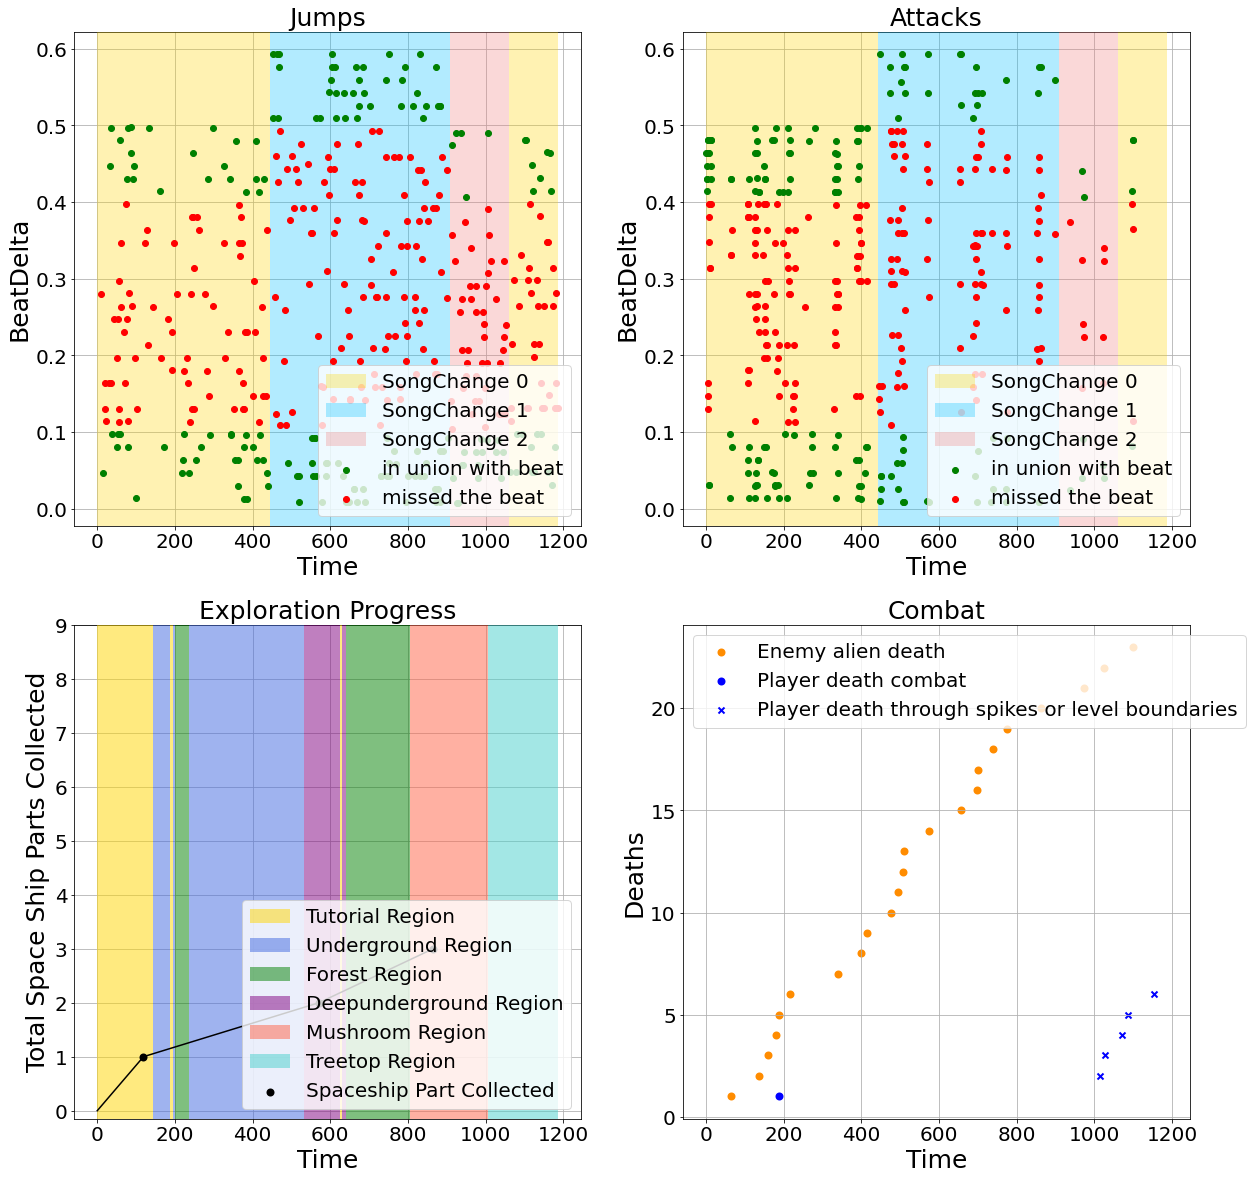

157771_NoRhythm_02_12_21_06_04_Beat_Metric.csv 157771_NoRhythm_02_12_21_06_04_Various_Metric.csv 157771_NoRhythm_02_12_21_06_04_Combat_Metric.csv
Jumps hits: 368/881 = 41.77 %
Attacks hits: 368/881 = 41.77 %
time spent in songs: {'SongChange 0': 164, 'SongChange 1': 431, 'SongChange 2': 596}
space ship parts collected: 4/9 = 44.44 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 14
time spent in regions: {'Tutorial': 85, 'Underground': 177, 'Deepunderground': 59, 'Forest': 108, 'Mushroom': 345, 'Treetop': 0, 'RedUnderground': 417, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 0, spike deaths 2
enemy deaths: 60
player damaged 24 times. Hit by 6 enemy types: {'Plant', 'Crab', 'Slime', 'Beholder', 'Worm', 'Bat'}
player healed 44
enemy damaged 96 times. 9 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


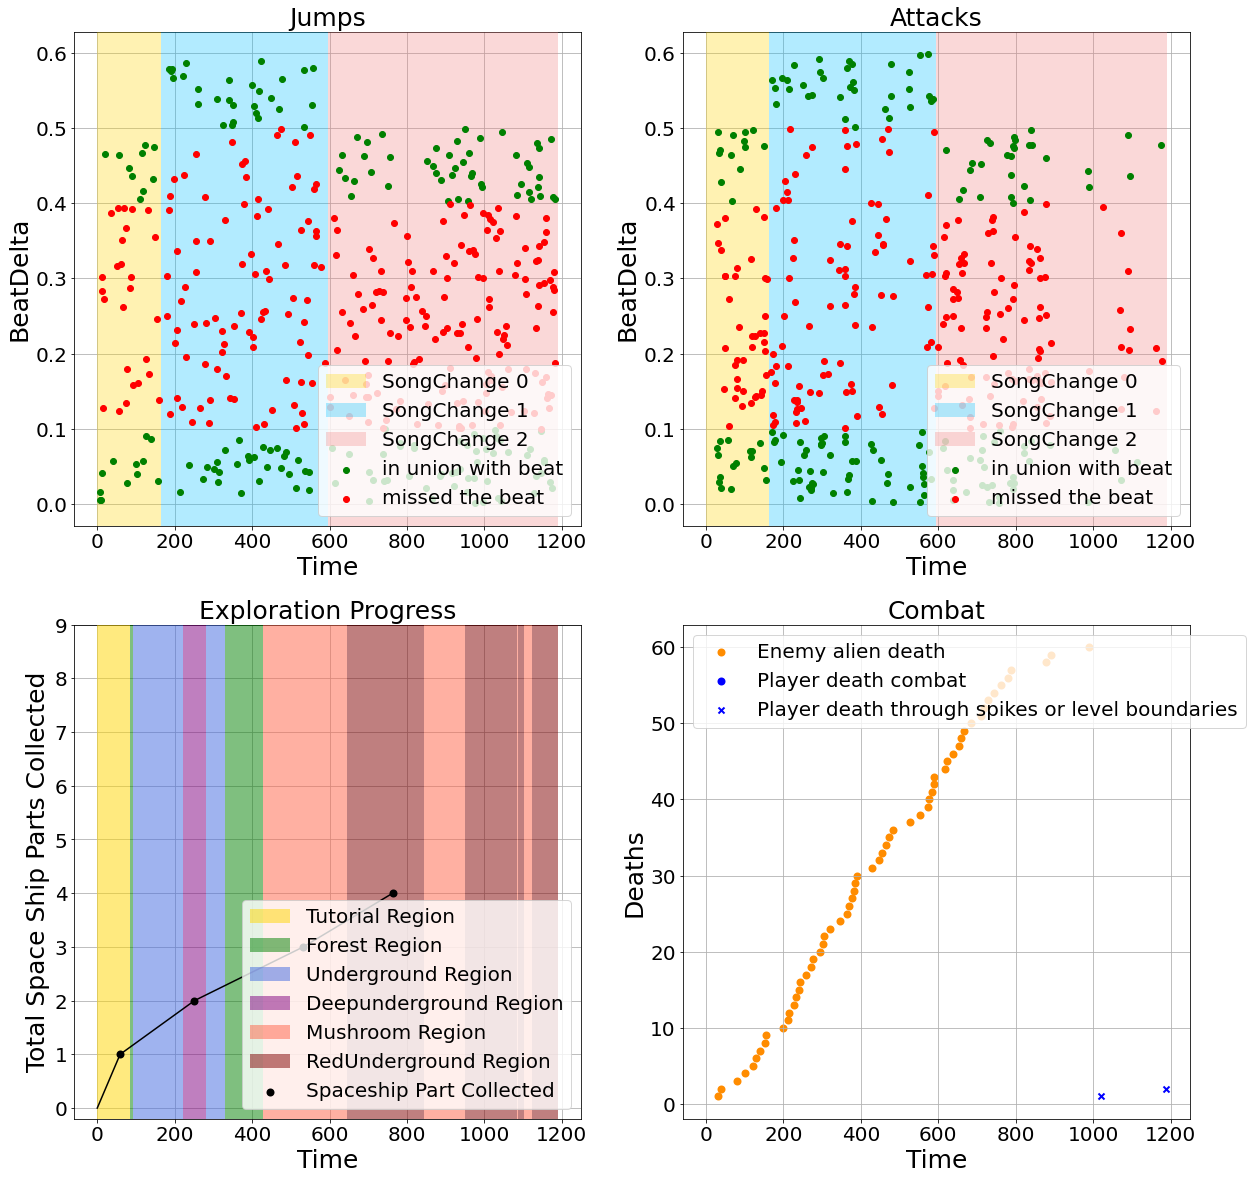

157771_RhythmControlled_02_12_21_06_35_Beat_Metric.csv 157771_RhythmControlled_02_12_21_06_35_Various_Metric.csv 157771_RhythmControlled_02_12_21_06_35_Combat_Metric.csv
Jumps hits: 363/649 = 55.93 %
Attacks hits: 363/649 = 55.93 %
time spent in songs: {'SongChange 0': 216, 'SongChange 1': 442, 'SongChange 2': 0}
space ship parts collected: 2/9 = 22.22 %
unique regions discovered: 4/8 = 50.0 %
total region changes: 15
time spent in regions: {'Tutorial': 92, 'Underground': 304, 'Deepunderground': 109, 'Forest': 153, 'Mushroom': 0, 'Treetop': 0, 'RedUnderground': 0, 'Spider': 0}
player combat deaths: 1, player jumpnrun deaths: 0, spike deaths 0
enemy deaths: 36
player damaged 43 times. Hit by 5 enemy types: {'Crab', 'Slime', 'Demon', 'Bat', 'Worm'}
player healed 33
enemy damaged 52 times. 6 enemy types damaged: {'Crab', 'Slime', 'Demon', 'Bat', 'Worm', 'Turtle'}


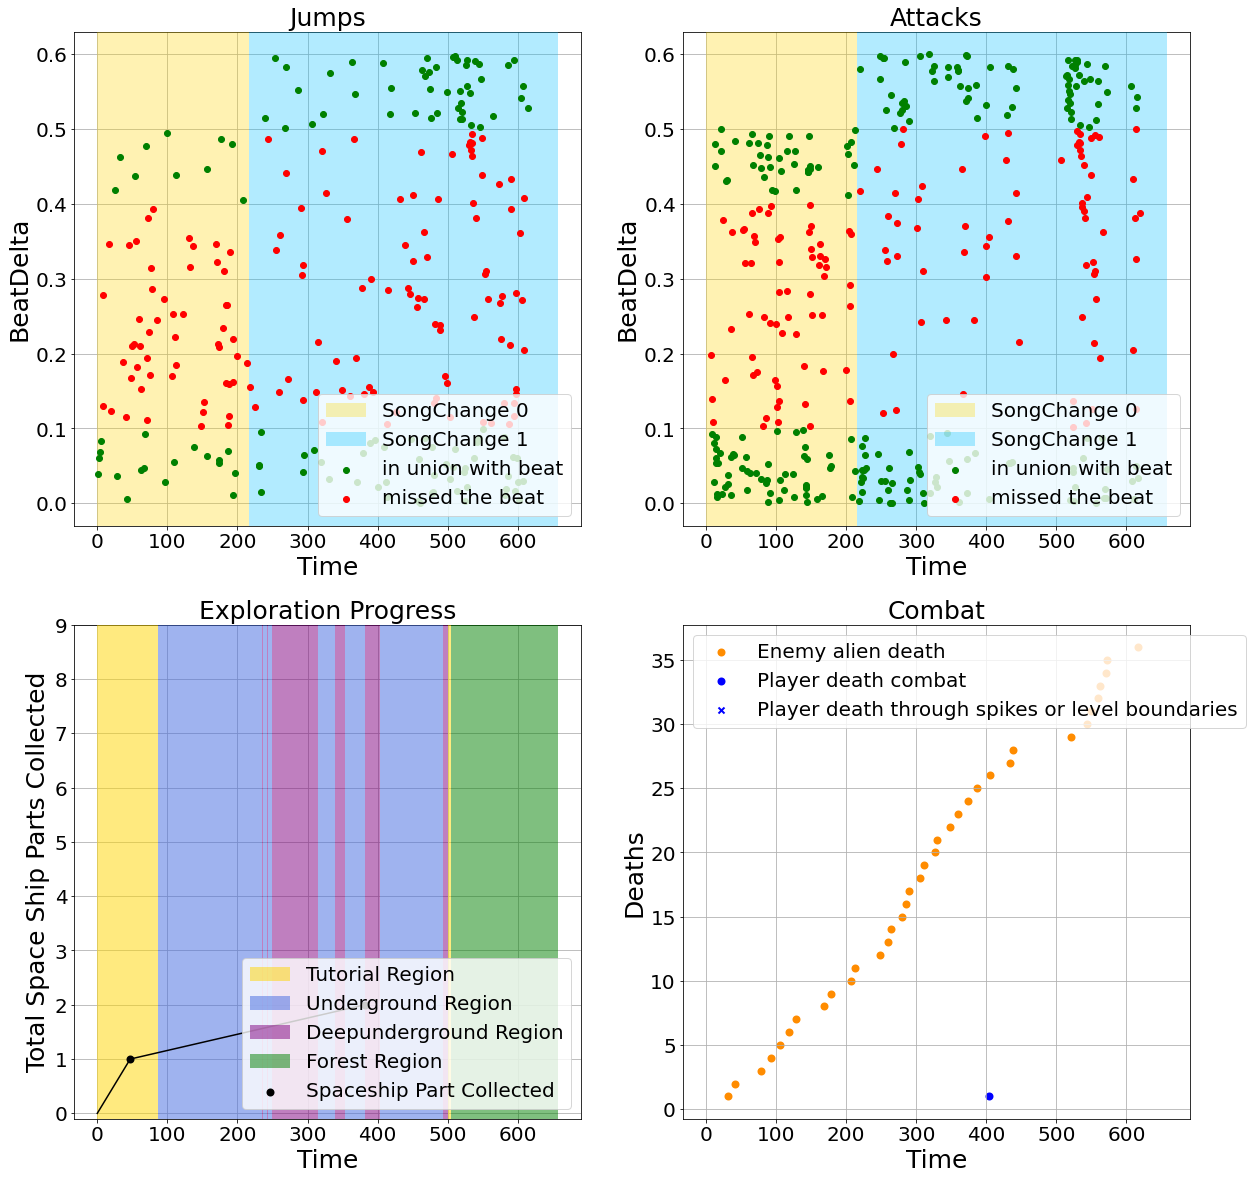

198760_NoRhythm_06_12_21_06_35_Beat_Metric.csv 198760_NoRhythm_06_12_21_06_35_Various_Metric.csv 198760_NoRhythm_06_12_21_06_35_Combat_Metric.csv
Jumps hits: 329/940 = 35.0 %
Attacks hits: 329/940 = 35.0 %
time spent in songs: {'SongChange 0': 248, 'SongChange 1': 824, 'SongChange 2': 133}
space ship parts collected: 7/9 = 77.78 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 21
time spent in regions: {'Tutorial': 243, 'Underground': 247, 'Deepunderground': 112, 'Forest': 92, 'Mushroom': 317, 'Treetop': 194, 'RedUnderground': 0, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 1, spike deaths 0
enemy deaths: 75
player damaged 12 times. Hit by 3 enemy types: {'Bat', 'Turtle', 'Slime'}
player healed 80
enemy damaged 139 times. 8 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


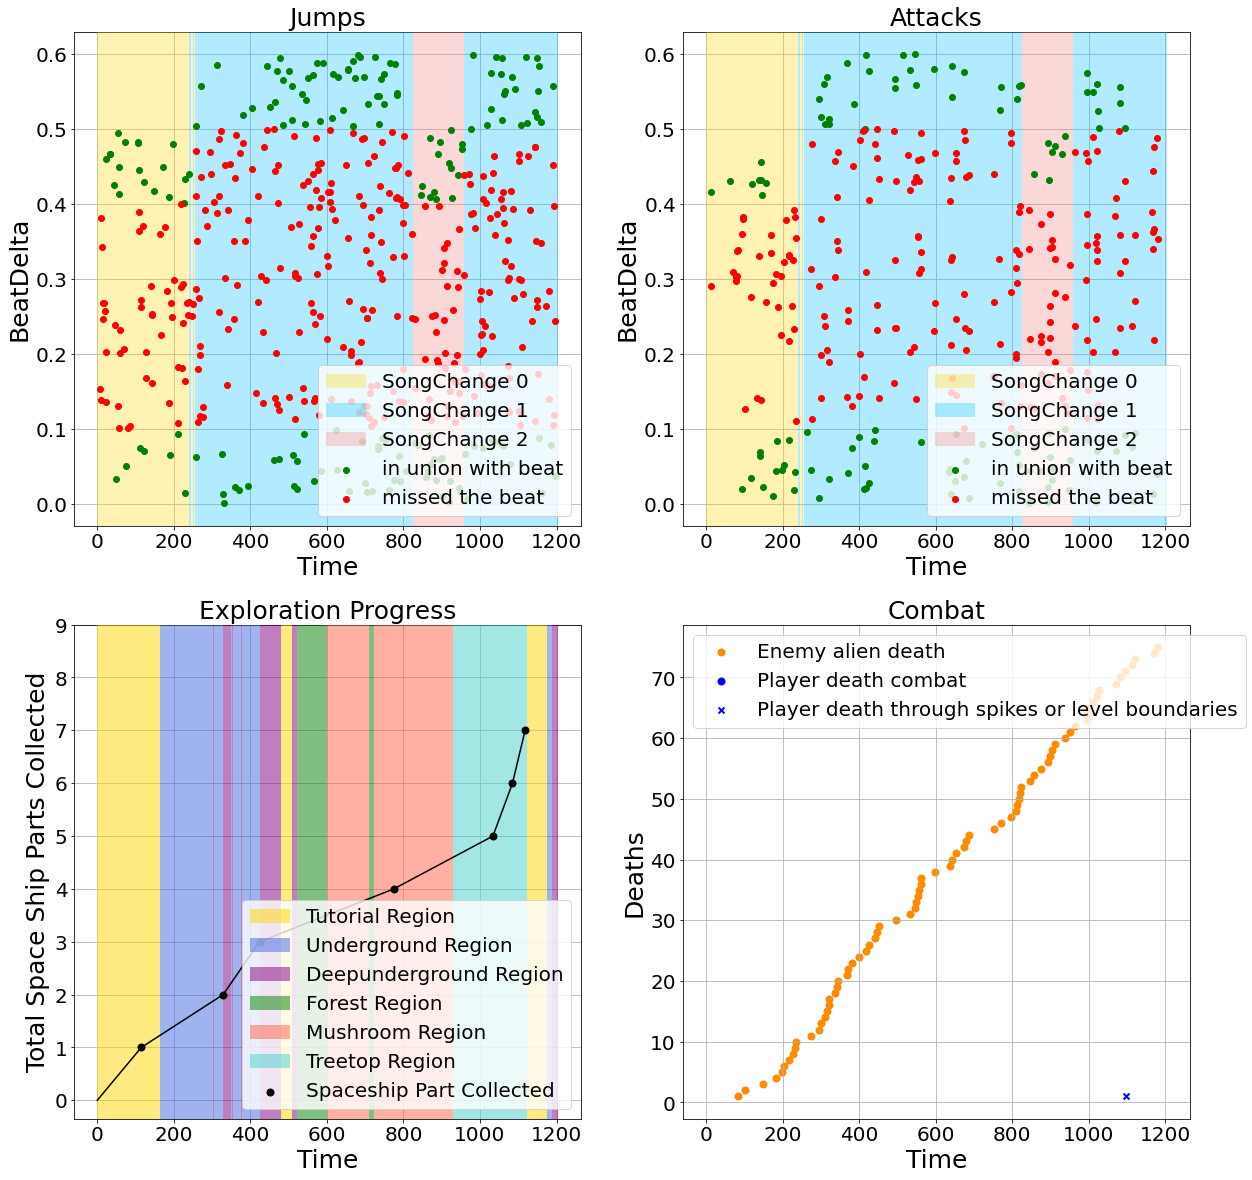

198760_RhythmControlled_06_12_21_07_06_Beat_Metric.csv 198760_RhythmControlled_06_12_21_07_06_Various_Metric.csv 198760_RhythmControlled_06_12_21_07_06_Combat_Metric.csv
Jumps hits: 434/919 = 47.23 %
Attacks hits: 434/919 = 47.23 %
time spent in songs: {'SongChange 0': 296, 'SongChange 1': 640, 'SongChange 2': 192}
space ship parts collected: 4/9 = 44.44 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 12
time spent in regions: {'Tutorial': 131, 'Underground': 311, 'Deepunderground': 71, 'Forest': 133, 'Mushroom': 286, 'Treetop': 196, 'RedUnderground': 0, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 0, spike deaths 0
enemy deaths: 60
player damaged 50 times. Hit by 8 enemy types: {'Plant', 'Crab', 'Slime', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}
player healed 73
enemy damaged 116 times. 8 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


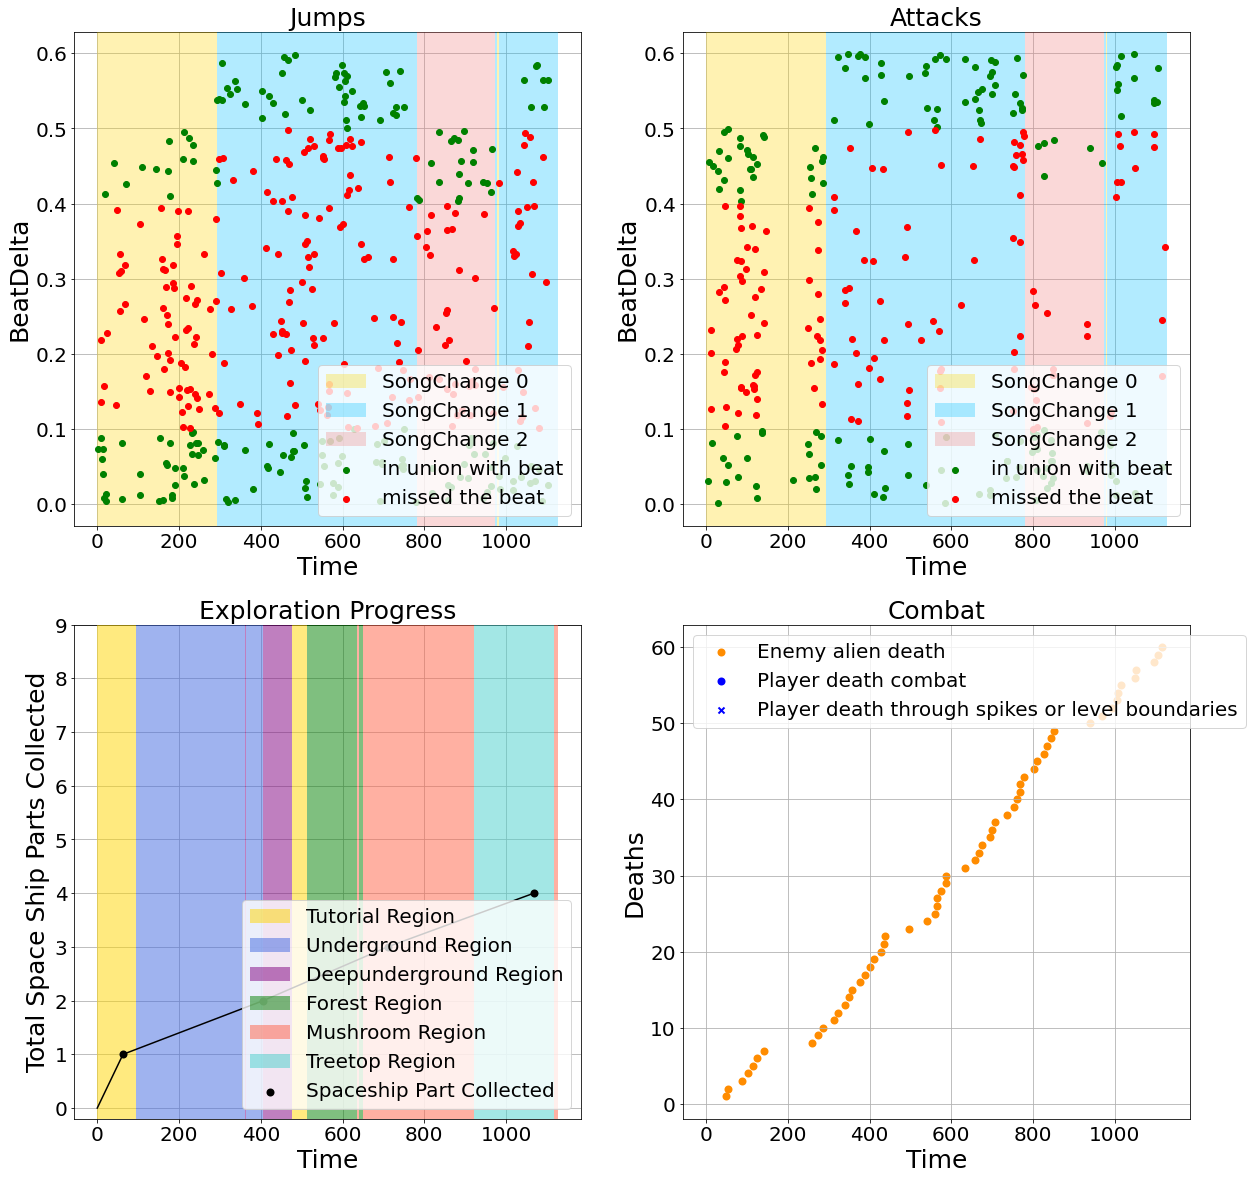

244206_NoRhythm_03_12_21_03_22_Beat_Metric.csv 244206_NoRhythm_03_12_21_03_22_Various_Metric.csv 244206_NoRhythm_03_12_21_03_22_Combat_Metric.csv
Jumps hits: 332/813 = 40.84 %
Attacks hits: 332/813 = 40.84 %
time spent in songs: {'SongChange 0': 197, 'SongChange 1': 397, 'SongChange 2': 612}
space ship parts collected: 6/9 = 66.67 %
unique regions discovered: 8/8 = 100.0 %
total region changes: 23
time spent in regions: {'Tutorial': 107, 'Underground': 119, 'Deepunderground': 111, 'Forest': 142, 'Mushroom': 261, 'Treetop': 144, 'RedUnderground': 304, 'Spider': 18}
player combat deaths: 0, player jumpnrun deaths: 3, spike deaths 0
enemy deaths: 51
player damaged 7 times. Hit by 3 enemy types: {'Worm', 'Spider', 'Slime'}
player healed 55
enemy damaged 85 times. 9 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


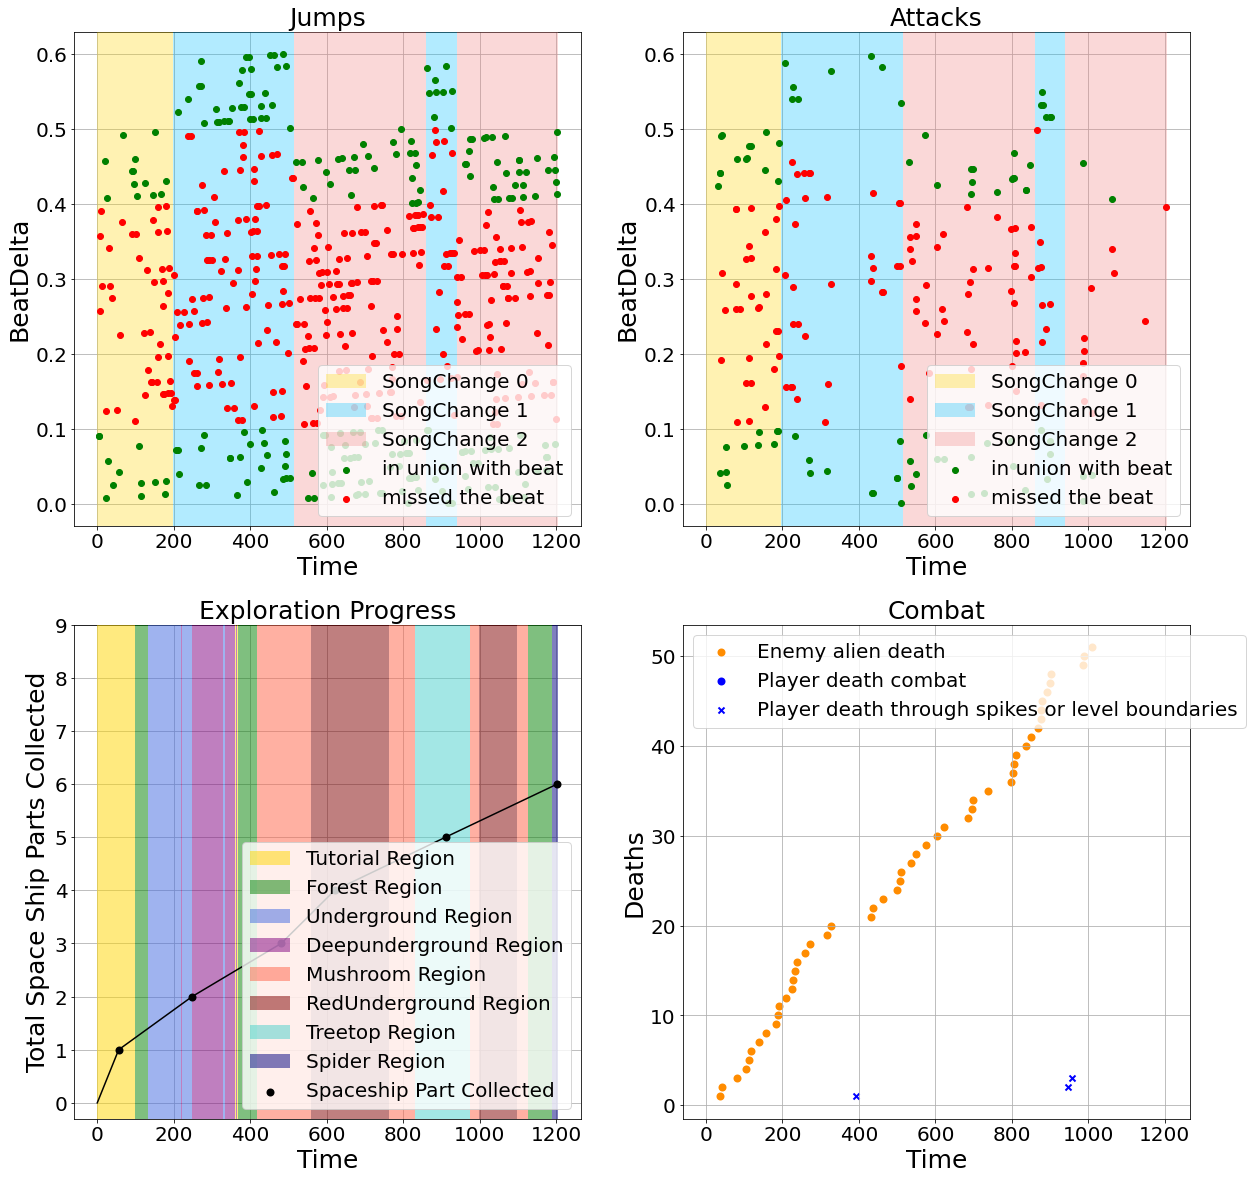

244206_RhythmControlled_03_12_21_03_50_Beat_Metric.csv 244206_RhythmControlled_03_12_21_03_50_Various_Metric.csv 244206_RhythmControlled_03_12_21_03_50_Combat_Metric.csv
Jumps hits: 559/797 = 70.14 %
Attacks hits: 559/797 = 70.14 %
time spent in songs: {'SongChange 0': 156, 'SongChange 1': 523, 'SongChange 2': 491}
space ship parts collected: 5/9 = 55.56 %
unique regions discovered: 7/8 = 87.5 %
total region changes: 15
time spent in regions: {'Tutorial': 109, 'Underground': 89, 'Deepunderground': 172, 'Forest': 76, 'Mushroom': 538, 'Treetop': 12, 'RedUnderground': 174, 'Spider': 0}
player combat deaths: 1, player jumpnrun deaths: 1, spike deaths 0
enemy deaths: 21
player damaged 34 times. Hit by 6 enemy types: {'Plant', 'Crab', 'Slime', 'Bat', 'Worm', 'Turtle'}
player healed 44
enemy damaged 24 times. 6 enemy types damaged: {'Crab', 'Slime', 'Beholder', 'Demon', 'Bat', 'Turtle'}


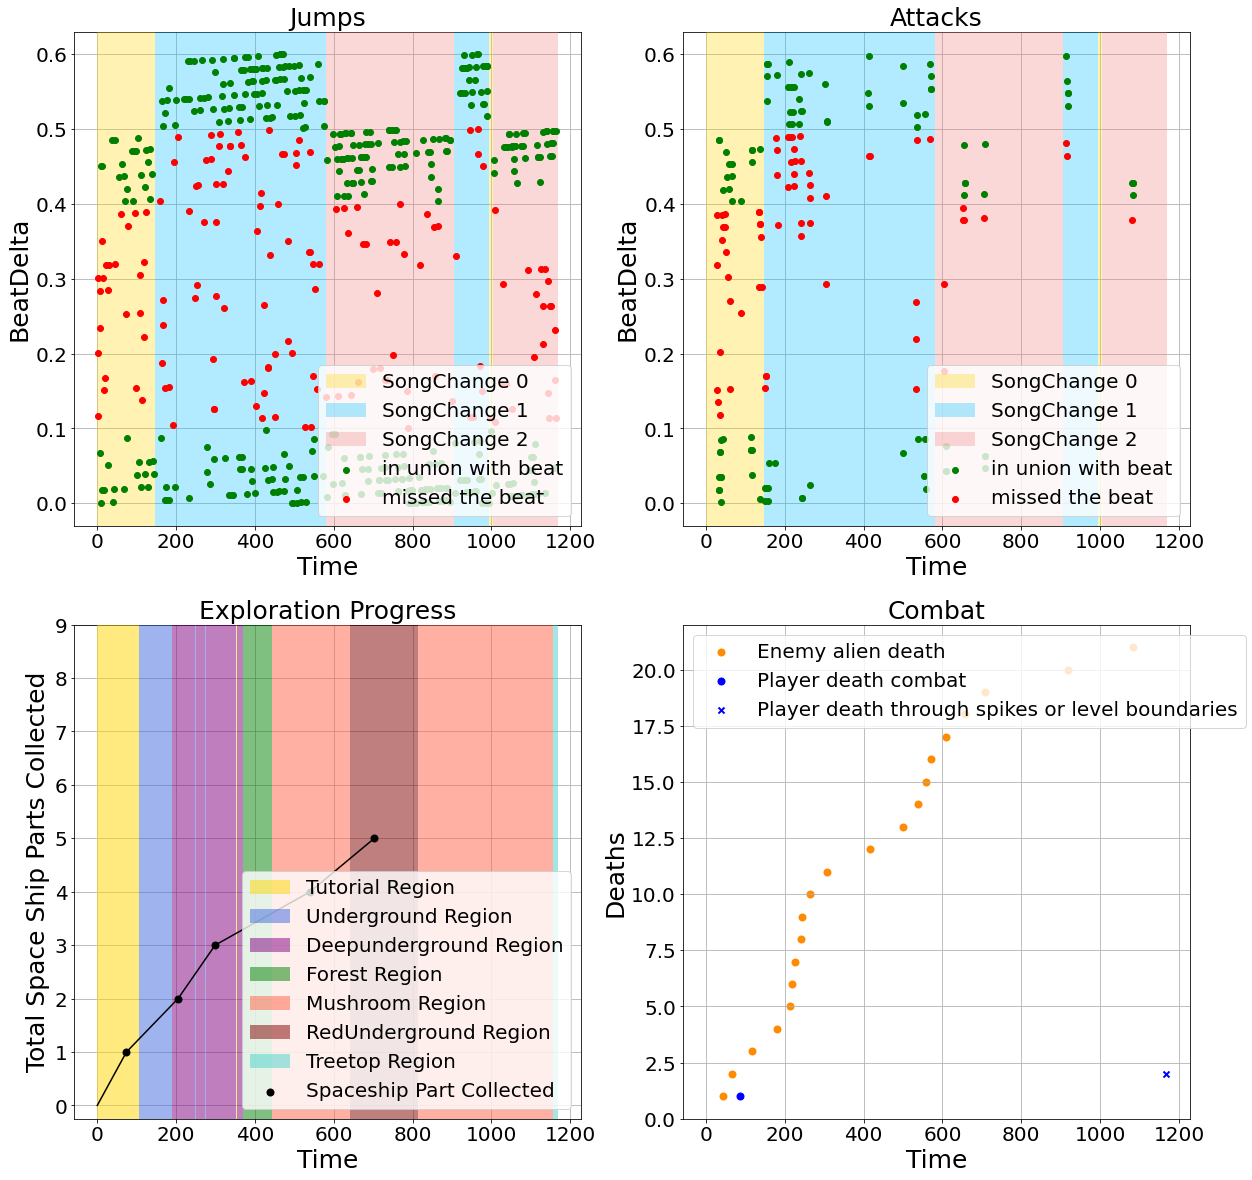

246229_NoRhythm_02_12_21_04_03_Beat_Metric.csv 246229_NoRhythm_02_12_21_04_03_Various_Metric.csv 246229_NoRhythm_02_12_21_04_03_Combat_Metric.csv
Jumps hits: 306/752 = 40.69 %
Attacks hits: 306/752 = 40.69 %
time spent in songs: {'SongChange 0': 392, 'SongChange 1': 462, 'SongChange 2': 225}
space ship parts collected: 4/9 = 44.44 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 12
time spent in regions: {'Tutorial': 101, 'Underground': 340, 'Deepunderground': 122, 'Forest': 129, 'Mushroom': 289, 'Treetop': 98, 'RedUnderground': 0, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 2, spike deaths 0
enemy deaths: 56
player damaged 34 times. Hit by 7 enemy types: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Bat', 'Turtle'}
player healed 57
enemy damaged 86 times. 9 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


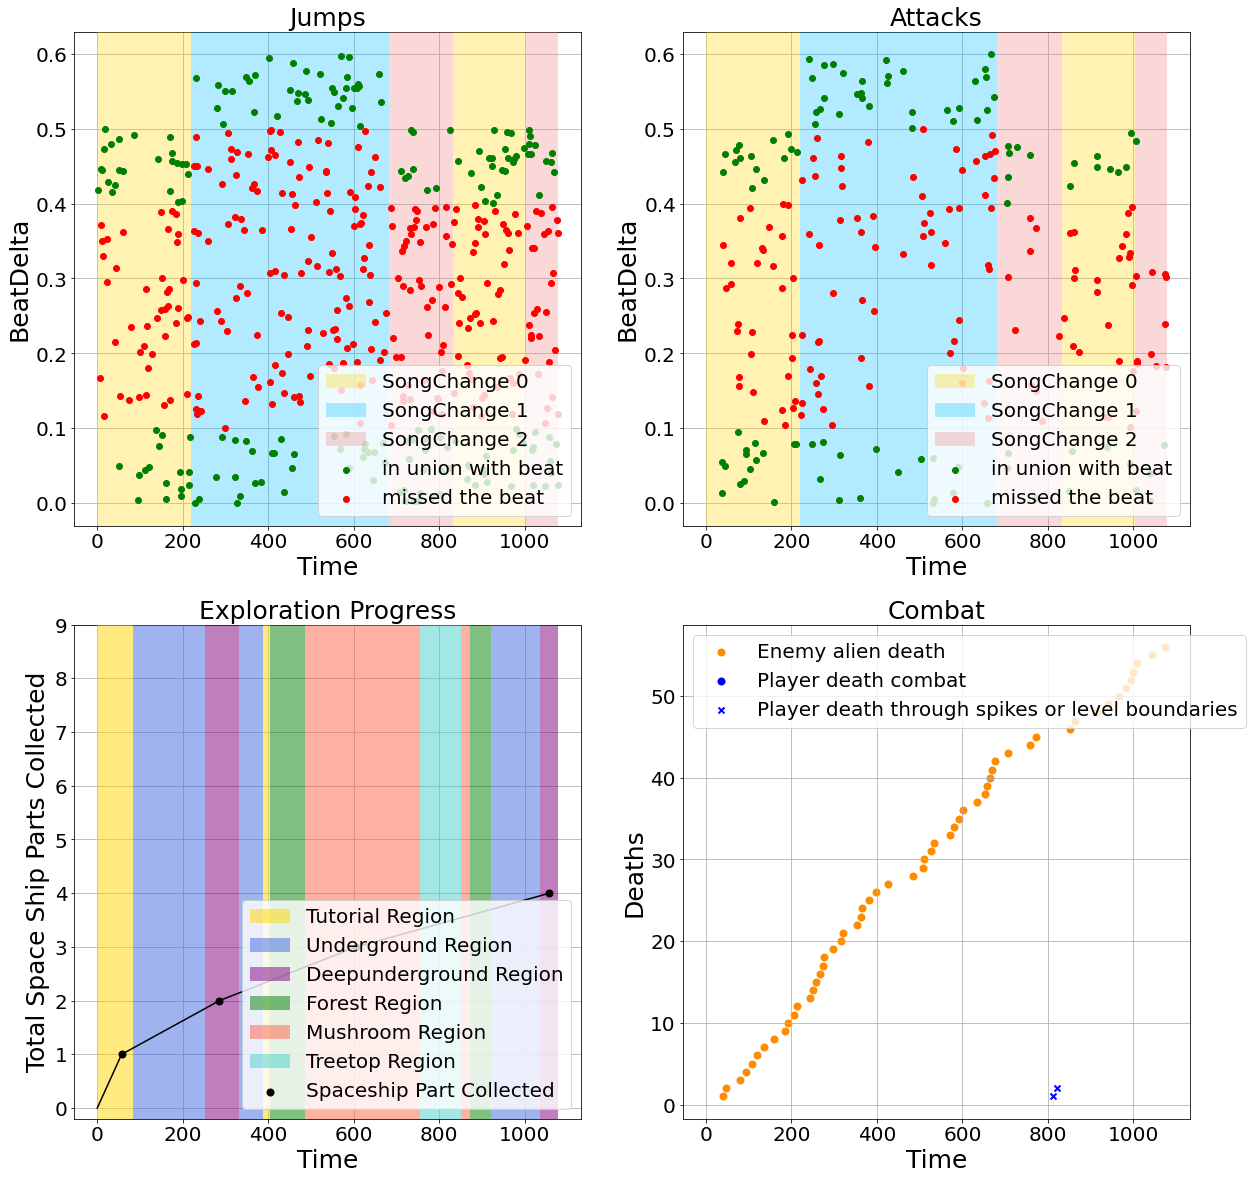

246229_RhythmControlled_02_12_21_04_30_Beat_Metric.csv 246229_RhythmControlled_02_12_21_04_30_Various_Metric.csv 246229_RhythmControlled_02_12_21_04_30_Combat_Metric.csv
Jumps hits: 382/905 = 42.21 %
Attacks hits: 382/905 = 42.21 %
time spent in songs: {'SongChange 0': 150, 'SongChange 1': 628, 'SongChange 2': 417}
space ship parts collected: 4/9 = 44.44 %
unique regions discovered: 7/8 = 87.5 %
total region changes: 23
time spent in regions: {'Tutorial': 77, 'Underground': 196, 'Deepunderground': 104, 'Forest': 219, 'Mushroom': 359, 'Treetop': 63, 'RedUnderground': 177, 'Spider': 0}
player combat deaths: 2, player jumpnrun deaths: 4, spike deaths 5
enemy deaths: 31
player damaged 64 times. Hit by 8 enemy types: {'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}
player healed 64
enemy damaged 34 times. 8 enemy types damaged: {'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


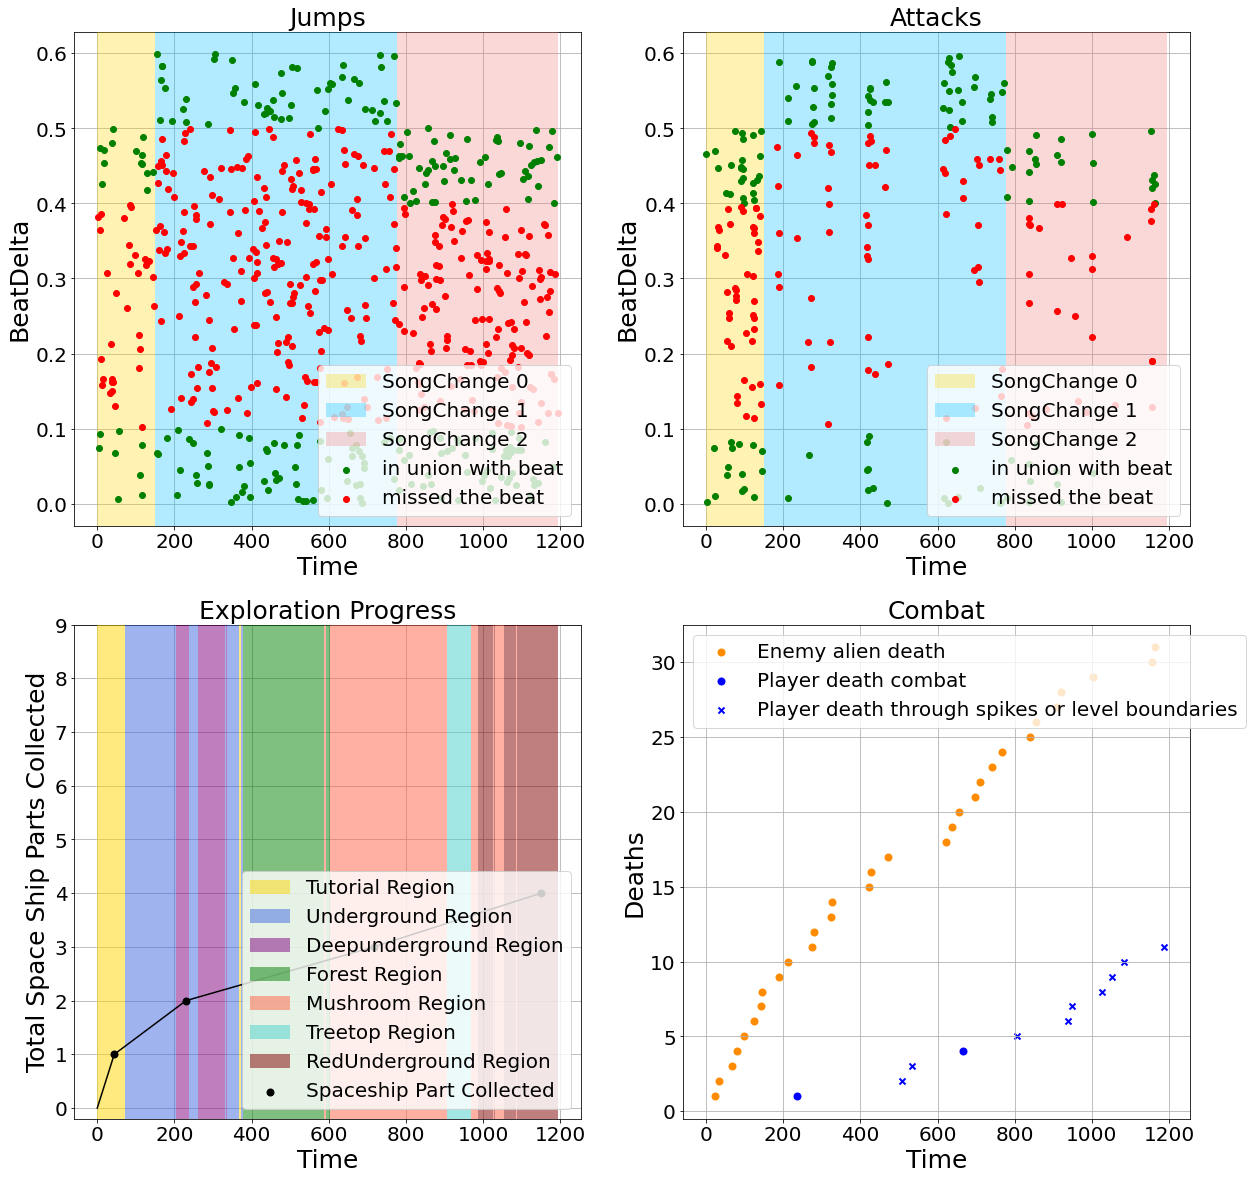

288786_NoRhythm_05_12_21_04_49_Beat_Metric.csv 288786_NoRhythm_05_12_21_04_49_Various_Metric.csv 288786_NoRhythm_05_12_21_04_49_Combat_Metric.csv
Jumps hits: 281/785 = 35.8 %
Attacks hits: 281/785 = 35.8 %
time spent in songs: {'SongChange 0': 429, 'SongChange 1': 362, 'SongChange 2': 388}
space ship parts collected: 8/9 = 88.89 %
unique regions discovered: 8/8 = 100.0 %
total region changes: 33
time spent in regions: {'Tutorial': 75, 'Underground': 134, 'Deepunderground': 217, 'Forest': 128, 'Mushroom': 354, 'Treetop': 174, 'RedUnderground': 7, 'Spider': 90}
player combat deaths: 0, player jumpnrun deaths: 4, spike deaths 1
enemy deaths: 12
player damaged 16 times. Hit by 5 enemy types: {'Spider', 'Slime', 'Beholder', 'Bat', 'Worm'}
player healed 67
enemy damaged 26 times. 5 enemy types damaged: {'Crab', 'Slime', 'Spider', 'Worm', 'Turtle'}


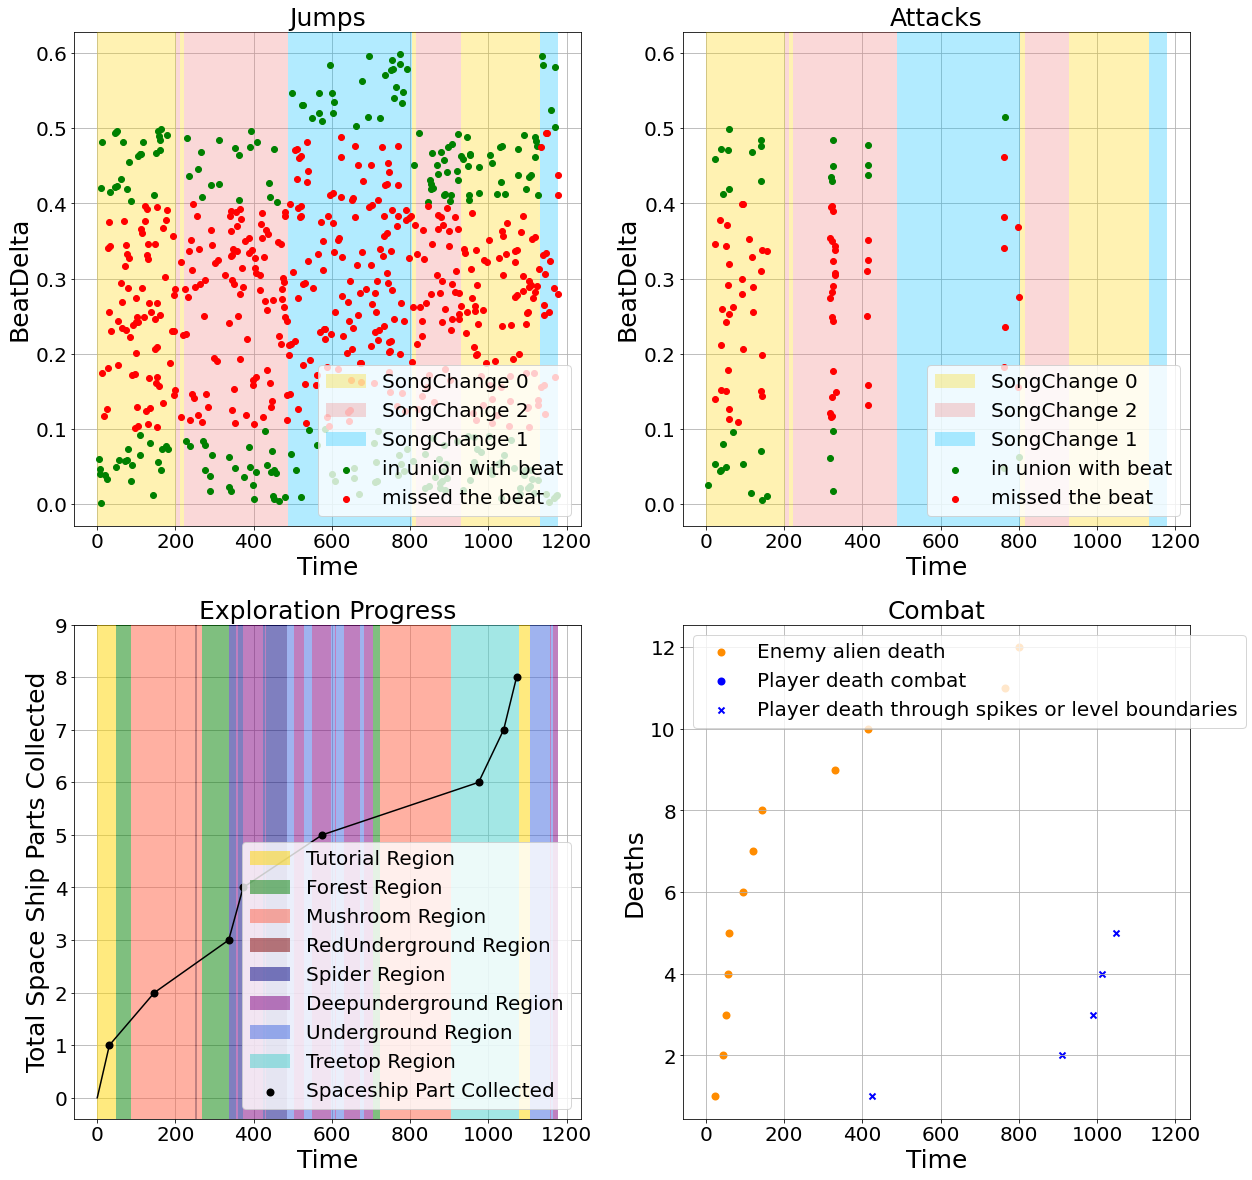

288786_RhythmControlled_05_12_21_04_21_Beat_Metric.csv 288786_RhythmControlled_05_12_21_04_21_Various_Metric.csv 288786_RhythmControlled_05_12_21_04_21_Combat_Metric.csv
Jumps hits: 391/1002 = 39.02 %
Attacks hits: 391/1002 = 39.02 %
time spent in songs: {'SongChange 0': 436, 'SongChange 1': 674, 'SongChange 2': 137}
space ship parts collected: 3/9 = 33.33 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 16
time spent in regions: {'Tutorial': 216, 'Underground': 322, 'Deepunderground': 216, 'Forest': 148, 'Mushroom': 246, 'Treetop': 99, 'RedUnderground': 0, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 5, spike deaths 1
enemy deaths: 39
player damaged 23 times. Hit by 5 enemy types: {'Plant', 'Crab', 'Beholder', 'Worm', 'Bat'}
player healed 54
enemy damaged 43 times. 7 enemy types damaged: {'Crab', 'Slime', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


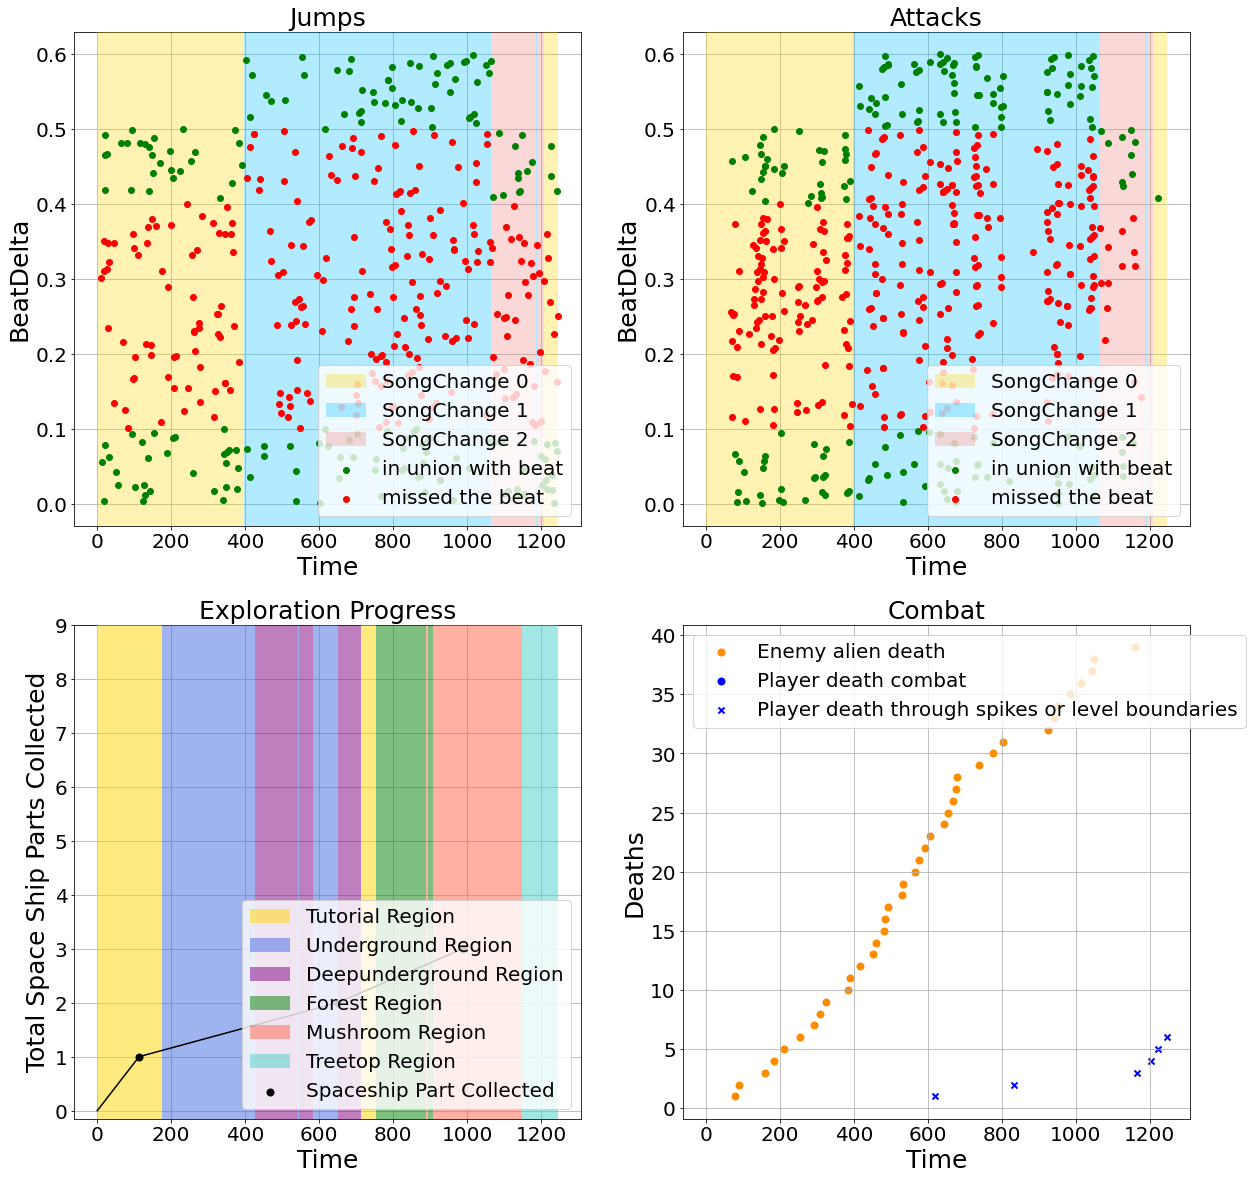

353252_NoRhythm_05_12_21_04_39_Beat_Metric.csv 353252_NoRhythm_05_12_21_04_39_Various_Metric.csv 353252_NoRhythm_05_12_21_04_39_Combat_Metric.csv
Jumps hits: 473/1195 = 39.58 %
Attacks hits: 473/1195 = 39.58 %
time spent in songs: {'SongChange 0': 693, 'SongChange 1': 280, 'SongChange 2': 342}
space ship parts collected: 6/9 = 66.67 %
unique regions discovered: 7/8 = 87.5 %
total region changes: 20
time spent in regions: {'Tutorial': 40, 'Underground': 79, 'Deepunderground': 83, 'Forest': 104, 'Mushroom': 673, 'Treetop': 333, 'RedUnderground': 3, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 10, spike deaths 0
enemy deaths: 4
player damaged 24 times. Hit by 3 enemy types: {'Bat', 'Plant', 'Slime'}
player healed 83
enemy damaged 7 times. 3 enemy types damaged: {'Bat', 'Crab', 'Slime'}


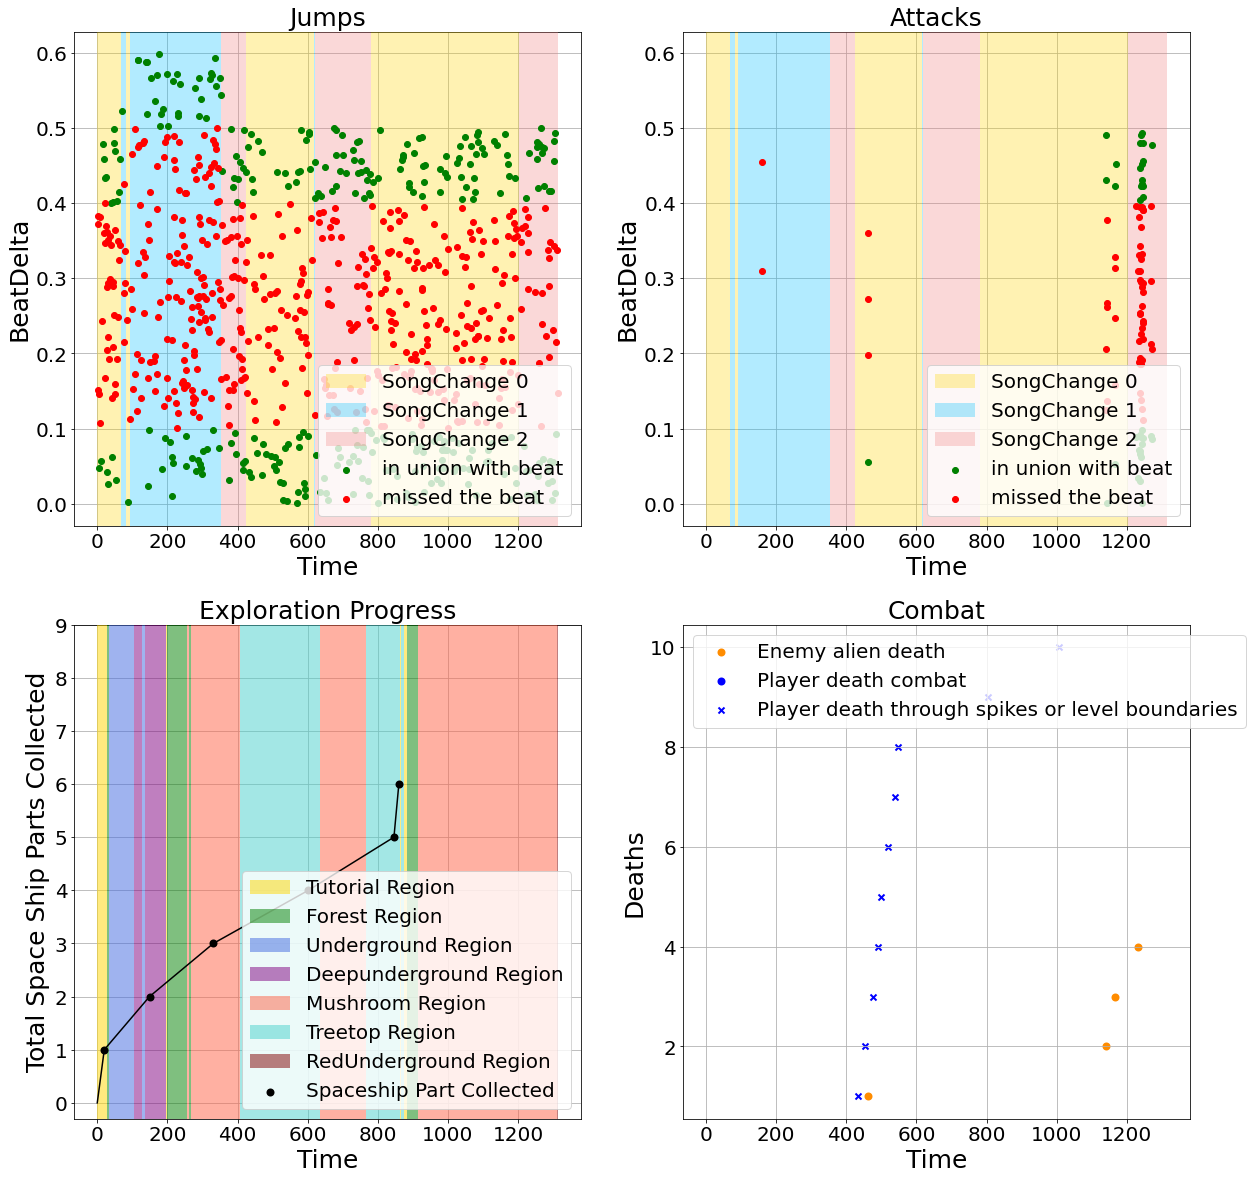

353252_RhythmControlled_05_12_21_04_13_Beat_Metric.csv 353252_RhythmControlled_05_12_21_04_13_Various_Metric.csv 353252_RhythmControlled_05_12_21_04_13_Combat_Metric.csv
Jumps hits: 508/878 = 57.86 %
Attacks hits: 508/878 = 57.86 %
time spent in songs: {'SongChange 0': 881, 'SongChange 1': 0, 'SongChange 2': 391}
space ship parts collected: 6/9 = 66.67 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 12
time spent in regions: {'Tutorial': 127, 'Underground': 35, 'Deepunderground': 0, 'Forest': 101, 'Mushroom': 458, 'Treetop': 405, 'RedUnderground': 146, 'Spider': 0}
player combat deaths: 1, player jumpnrun deaths: 12, spike deaths 2
enemy deaths: 17
player damaged 44 times. Hit by 9 enemy types: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'resetToCheckpoint', 'Bat', 'Worm', 'Turtle'}
player healed 74
enemy damaged 25 times. 6 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Bat', 'Worm', 'Turtle'}


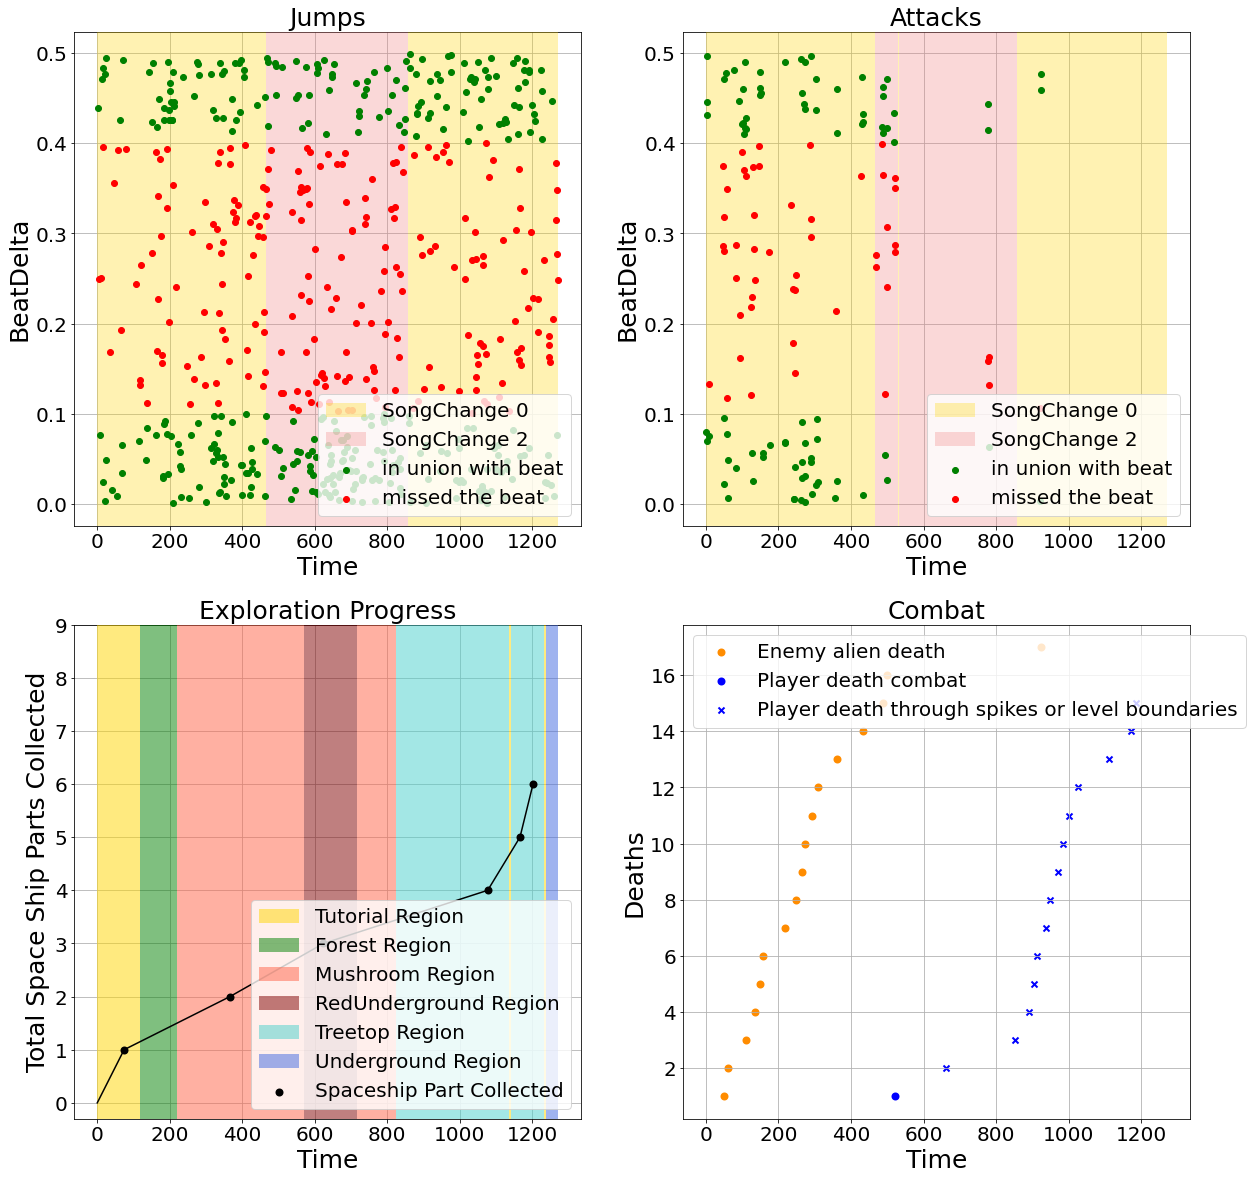

427217_NoRhythm_04_12_21_01_09_Beat_Metric.csv 427217_NoRhythm_04_12_21_01_09_Various_Metric.csv 427217_NoRhythm_04_12_21_01_09_Combat_Metric.csv
Jumps hits: 248/713 = 34.78 %
Attacks hits: 248/713 = 34.78 %
time spent in songs: {'SongChange 0': 543, 'SongChange 1': 0, 'SongChange 2': 623}
space ship parts collected: 6/9 = 66.67 %
unique regions discovered: 5/8 = 62.5 %
total region changes: 10
time spent in regions: {'Tutorial': 130, 'Underground': 0, 'Deepunderground': 0, 'Forest': 92, 'Mushroom': 389, 'Treetop': 212, 'RedUnderground': 343, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 1, spike deaths 2
enemy deaths: 48
player damaged 22 times. Hit by 5 enemy types: {'Crab', 'Slime', 'Spider', 'Bat', 'Turtle'}
player healed 75
enemy damaged 88 times. 9 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


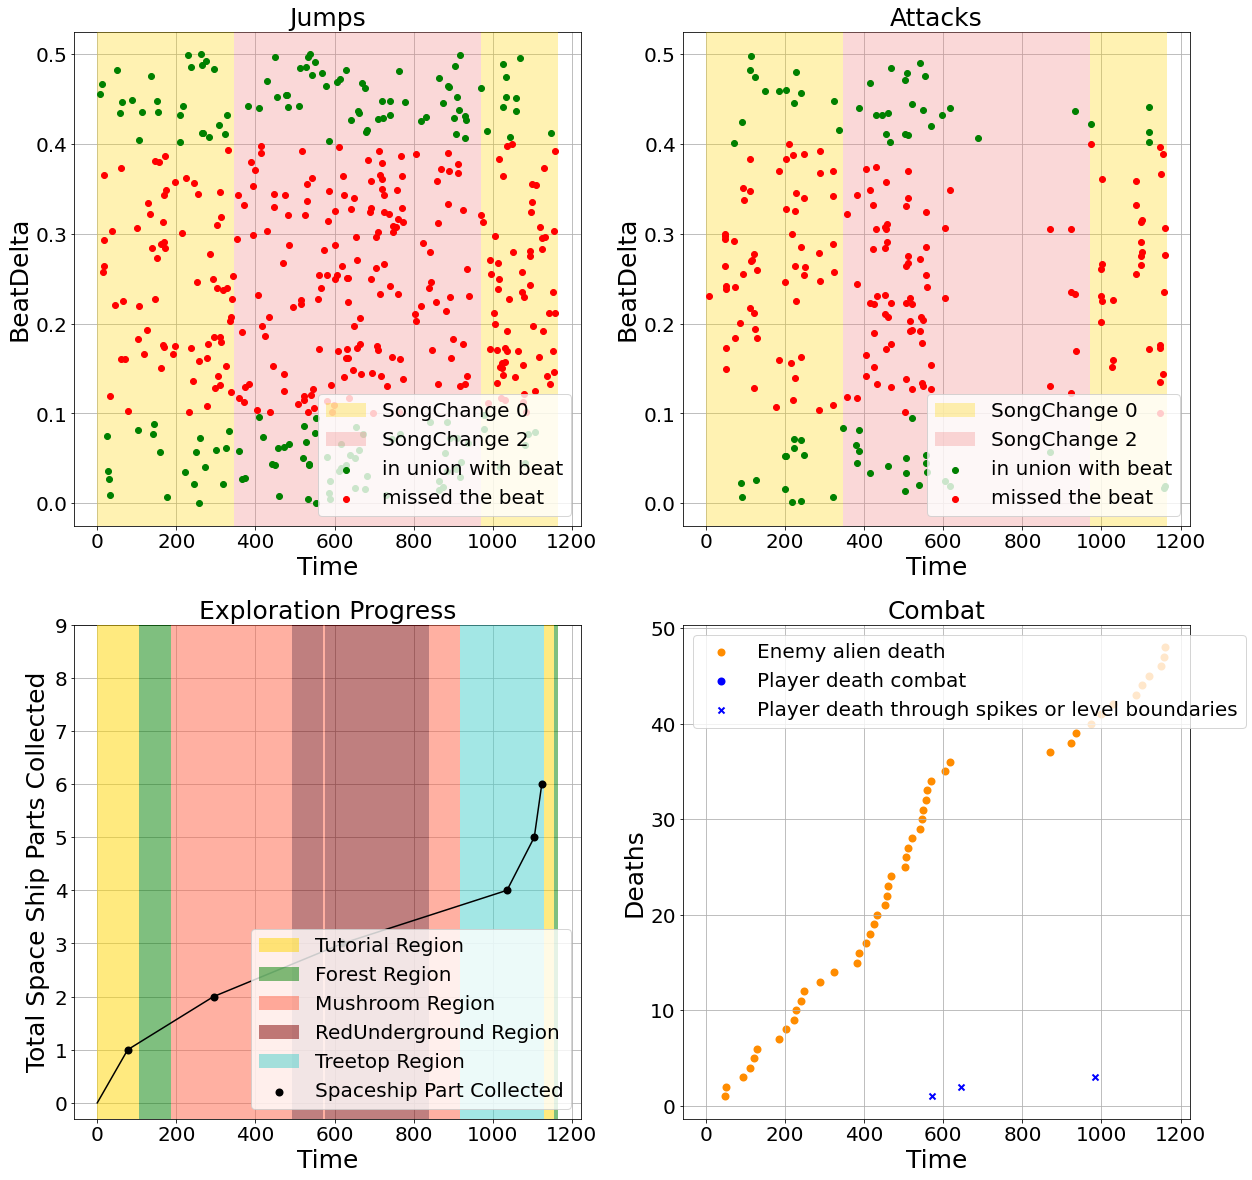

427217_RhythmControlled_04_12_21_02_02_Beat_Metric.csv 427217_RhythmControlled_04_12_21_02_02_Various_Metric.csv 427217_RhythmControlled_04_12_21_02_02_Combat_Metric.csv
Jumps hits: 336/786 = 42.75 %
Attacks hits: 336/786 = 42.75 %
time spent in songs: {'SongChange 0': 223, 'SongChange 1': 568, 'SongChange 2': 404}
space ship parts collected: 3/9 = 33.33 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 19
time spent in regions: {'Tutorial': 135, 'Underground': 220, 'Deepunderground': 19, 'Forest': 155, 'Mushroom': 375, 'Treetop': 0, 'RedUnderground': 291, 'Spider': 0}
player combat deaths: 7, player jumpnrun deaths: 0, spike deaths 1
enemy deaths: 47
player damaged 114 times. Hit by 9 enemy types: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}
player healed 37
enemy damaged 58 times. 9 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


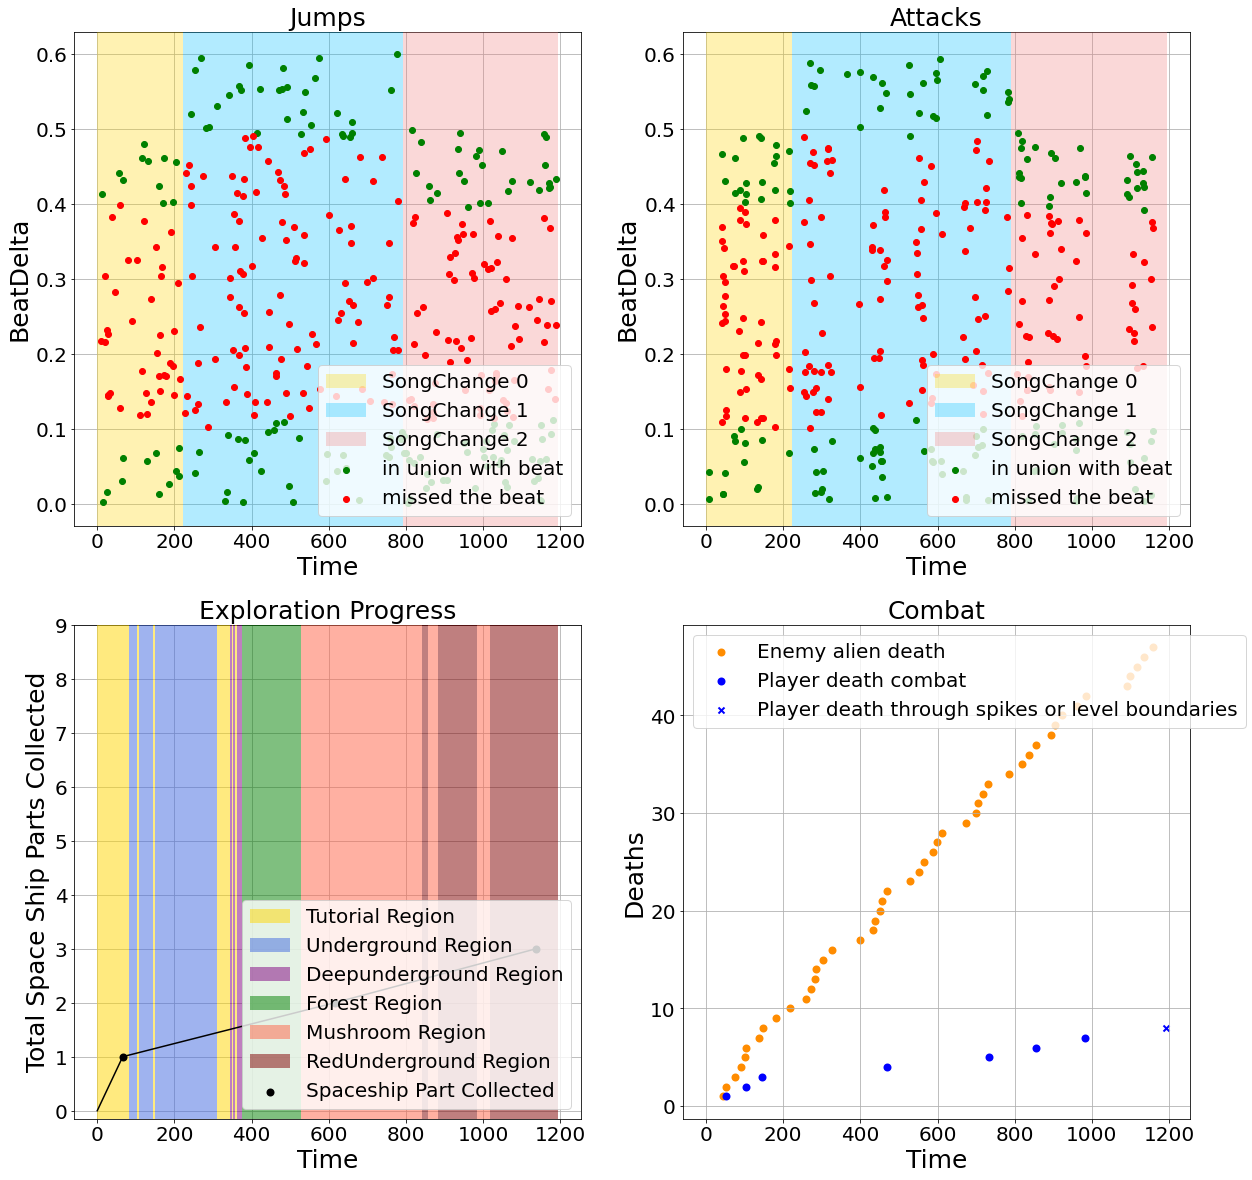

452042_NoRhythm_01_12_21_12_47_Beat_Metric.csv 452042_NoRhythm_01_12_21_12_47_Various_Metric.csv 452042_NoRhythm_01_12_21_12_47_Combat_Metric.csv
Jumps hits: 523/1217 = 42.97 %
Attacks hits: 523/1217 = 42.97 %
time spent in songs: {'SongChange 0': 267, 'SongChange 1': 0, 'SongChange 2': 1012}
space ship parts collected: 3/9 = 33.33 %
unique regions discovered: 5/8 = 62.5 %
total region changes: 18
time spent in regions: {'Tutorial': 132, 'Underground': 0, 'Deepunderground': 0, 'Forest': 128, 'Mushroom': 532, 'Treetop': 55, 'RedUnderground': 432, 'Spider': 0}
player combat deaths: 2, player jumpnrun deaths: 2, spike deaths 7
enemy deaths: 42
player damaged 58 times. Hit by 7 enemy types: {'Plant', 'Crab', 'Spider', 'Slime', 'Beholder', 'Demon', 'Worm'}
player healed 31
enemy damaged 78 times. 8 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Worm', 'Turtle'}


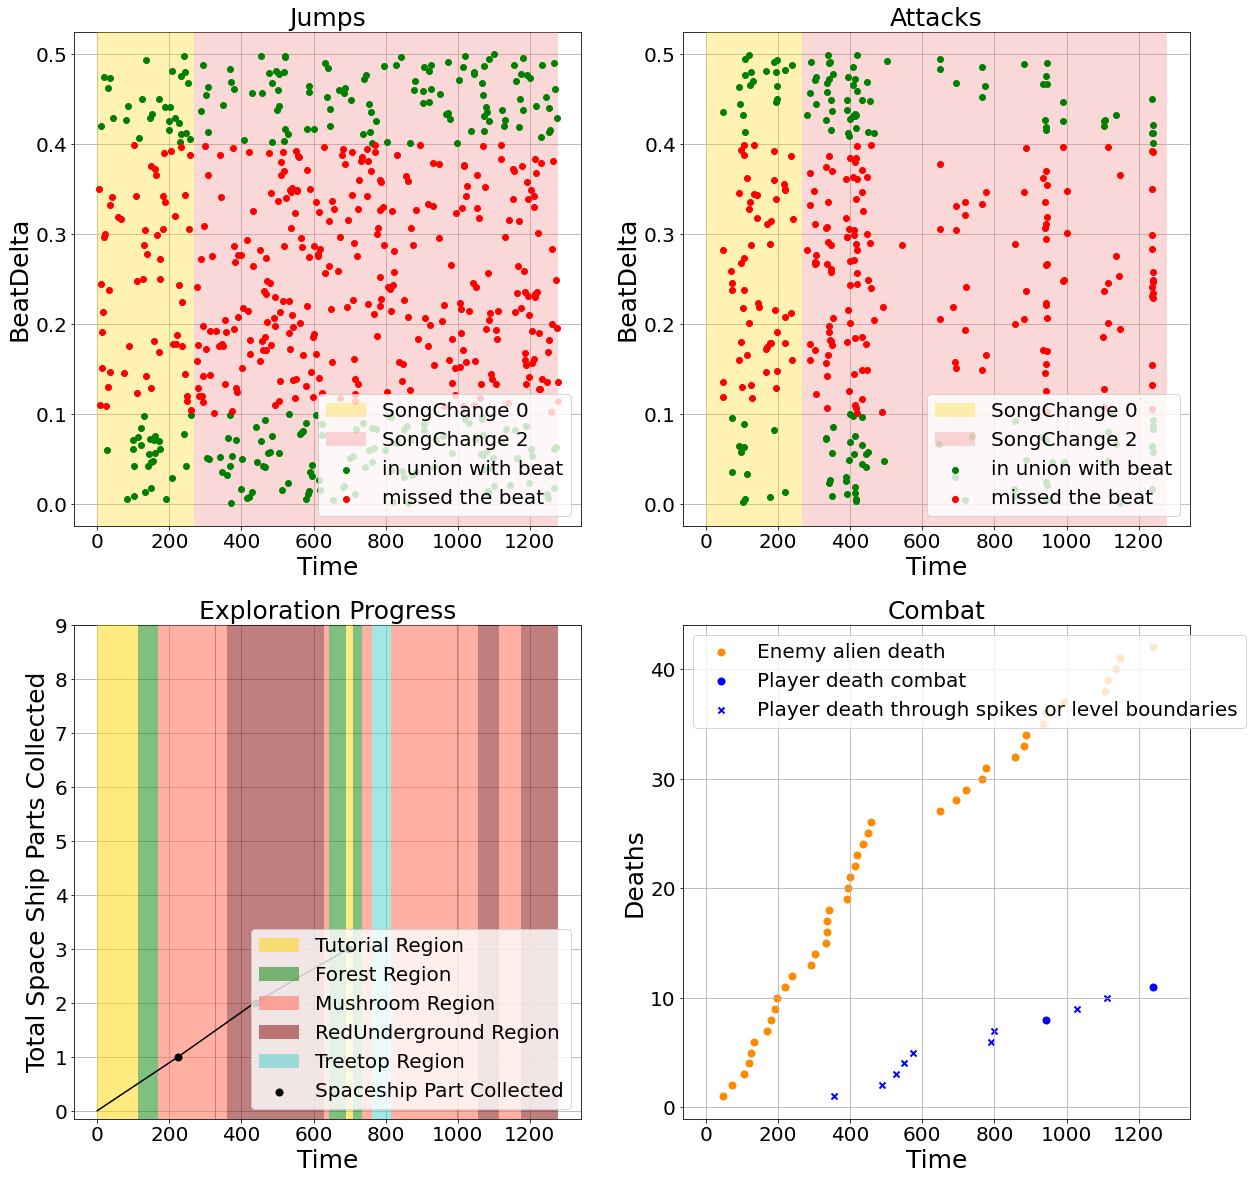

452042_RhythmControlled_01_12_21_01_19_Beat_Metric.csv 452042_RhythmControlled_01_12_21_01_19_Various_Metric.csv 452042_RhythmControlled_01_12_21_01_19_Combat_Metric.csv
Jumps hits: 420/763 = 55.05 %
Attacks hits: 420/763 = 55.05 %
time spent in songs: {'SongChange 0': 384, 'SongChange 1': 0, 'SongChange 2': 835}
space ship parts collected: 3/9 = 33.33 %
unique regions discovered: 5/8 = 62.5 %
total region changes: 10
time spent in regions: {'Tutorial': 70, 'Underground': 0, 'Deepunderground': 0, 'Forest': 72, 'Mushroom': 396, 'Treetop': 177, 'RedUnderground': 504, 'Spider': 0}
player combat deaths: 2, player jumpnrun deaths: 7, spike deaths 5
enemy deaths: 22
player damaged 48 times. Hit by 7 enemy types: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Worm', 'Turtle'}
player healed 43
enemy damaged 26 times. 7 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Turtle'}


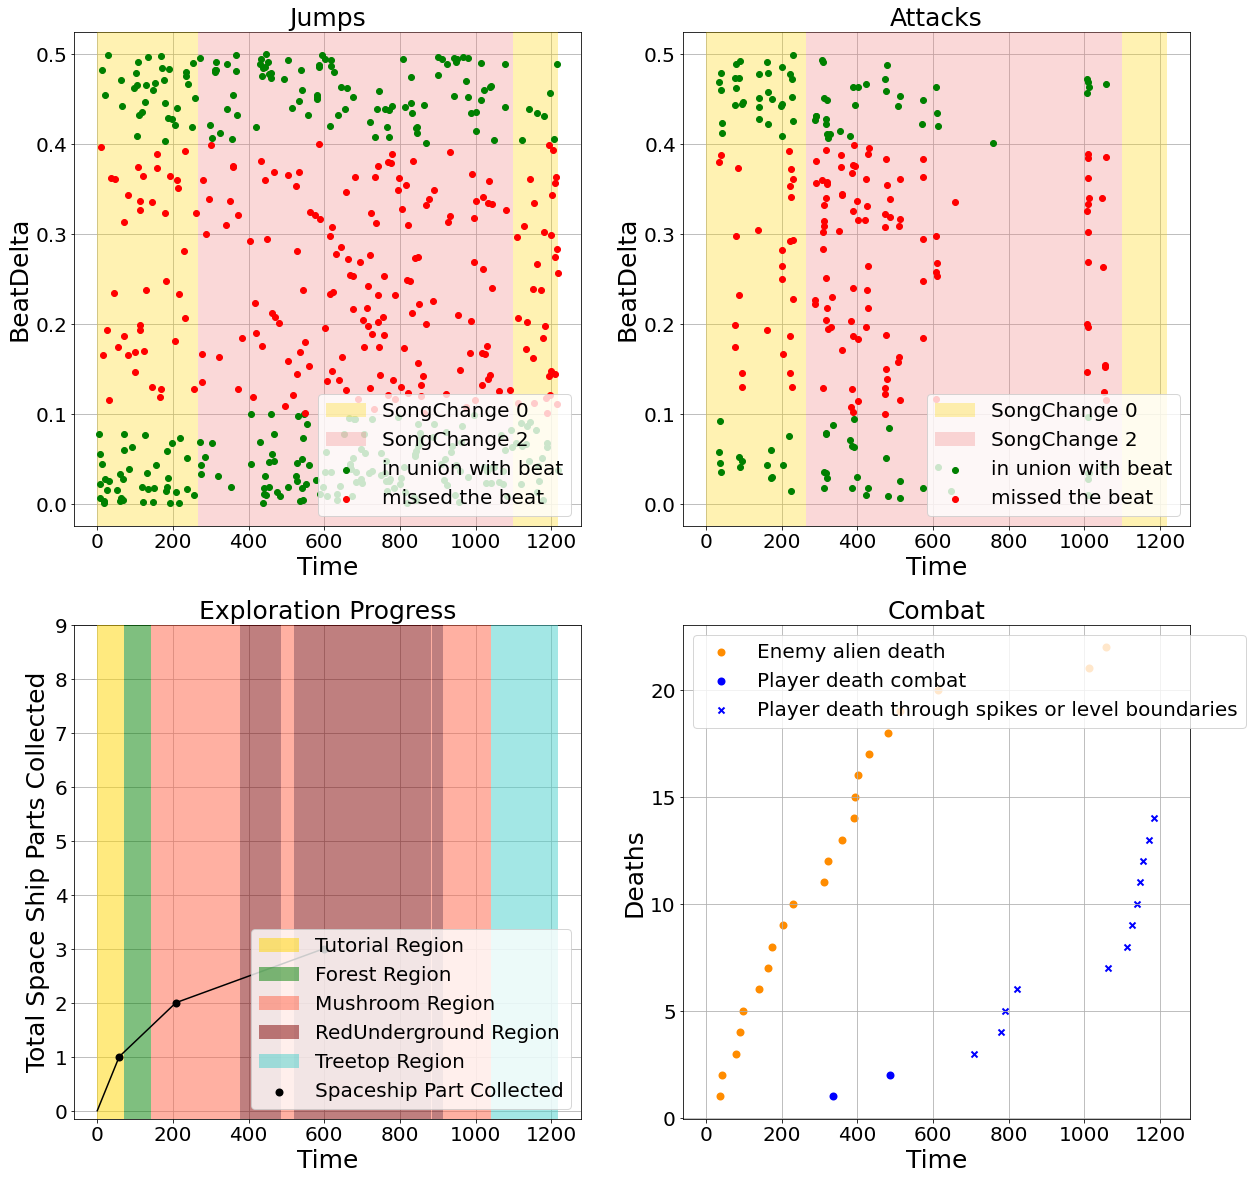

481091_NoRhythm_04_12_21_07_41_Beat_Metric.csv 481091_NoRhythm_04_12_21_07_41_Various_Metric.csv 481091_NoRhythm_04_12_21_07_41_Combat_Metric.csv
Jumps hits: 286/749 = 38.18 %
Attacks hits: 286/749 = 38.18 %
time spent in songs: {'SongChange 0': 616, 'SongChange 1': 413, 'SongChange 2': 110}
space ship parts collected: 4/9 = 44.44 %
unique regions discovered: 5/8 = 62.5 %
total region changes: 25
time spent in regions: {'Tutorial': 131, 'Underground': 161, 'Deepunderground': 0, 'Forest': 222, 'Mushroom': 387, 'Treetop': 238, 'RedUnderground': 0, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 3, spike deaths 0
enemy deaths: 49
player damaged 27 times. Hit by 5 enemy types: {'Plant', 'Slime', 'Beholder', 'Demon', 'Bat'}
player healed 75
enemy damaged 78 times. 8 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


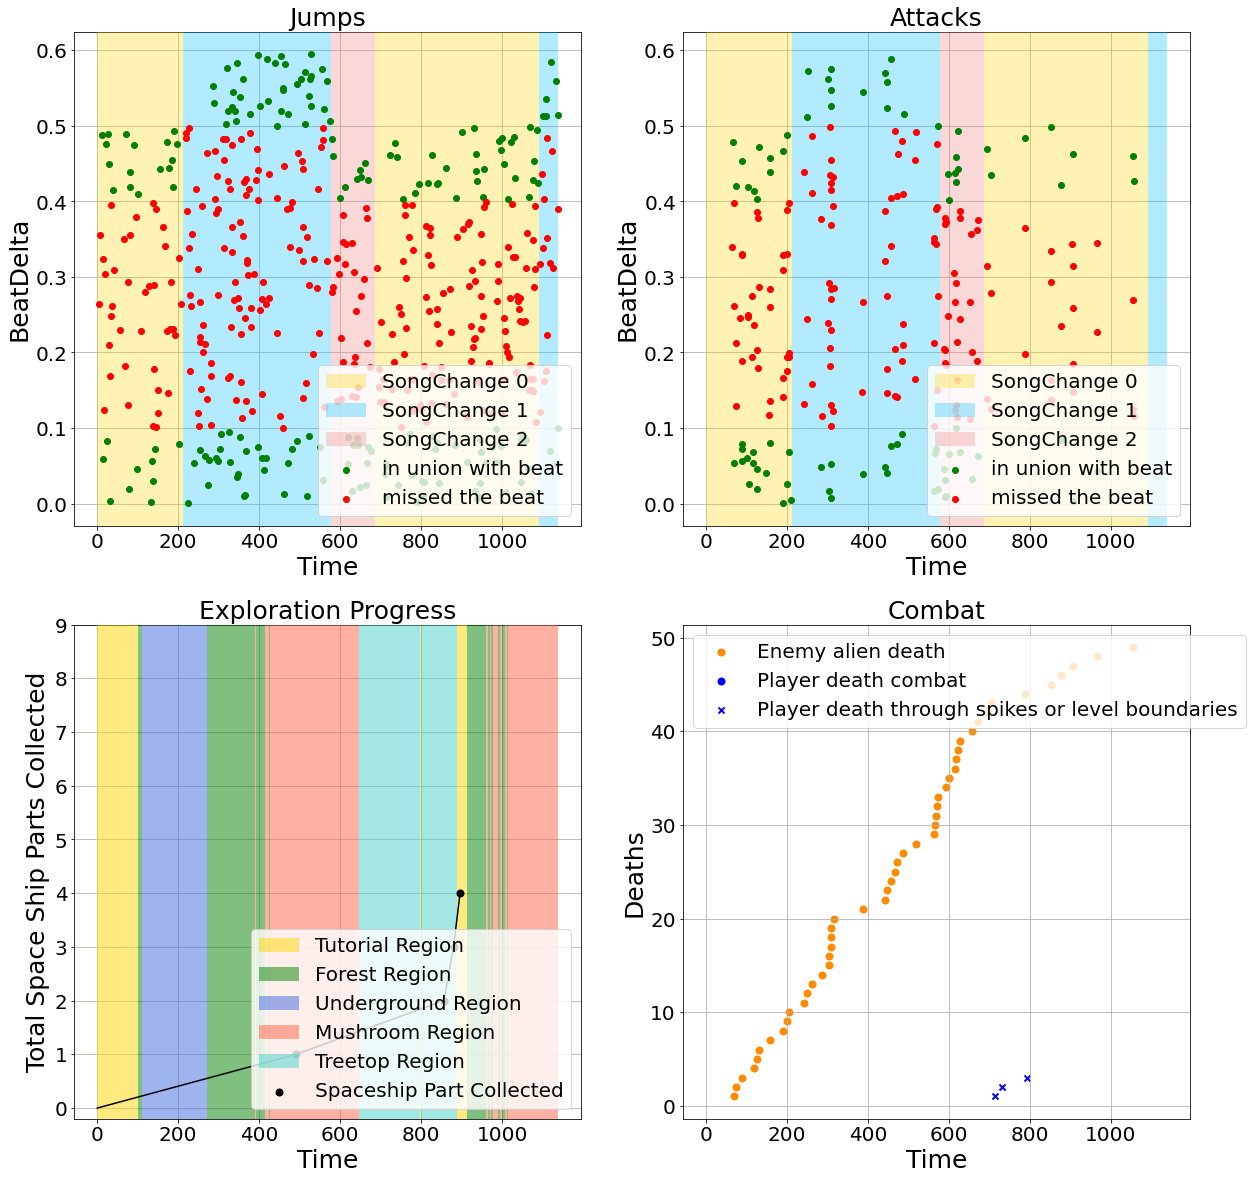

481091_RhythmControlled_04_12_21_08_10_Beat_Metric.csv 481091_RhythmControlled_04_12_21_08_10_Various_Metric.csv 481091_RhythmControlled_04_12_21_08_10_Combat_Metric.csv
Jumps hits: 510/739 = 69.01 %
Attacks hits: 510/739 = 69.01 %
time spent in songs: {'SongChange 0': 496, 'SongChange 1': 0, 'SongChange 2': 669}
space ship parts collected: 3/9 = 33.33 %
unique regions discovered: 7/8 = 87.5 %
total region changes: 27
time spent in regions: {'Tutorial': 160, 'Underground': 23, 'Deepunderground': 63, 'Forest': 159, 'Mushroom': 469, 'Treetop': 216, 'RedUnderground': 75, 'Spider': 0}
player combat deaths: 2, player jumpnrun deaths: 8, spike deaths 2
enemy deaths: 16
player damaged 33 times. Hit by 7 enemy types: {'Plant', 'Slime', 'Spider', 'Beholder', 'Demon', 'Worm', 'Turtle'}
player healed 66
enemy damaged 27 times. 7 enemy types damaged: {'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Worm', 'Turtle'}


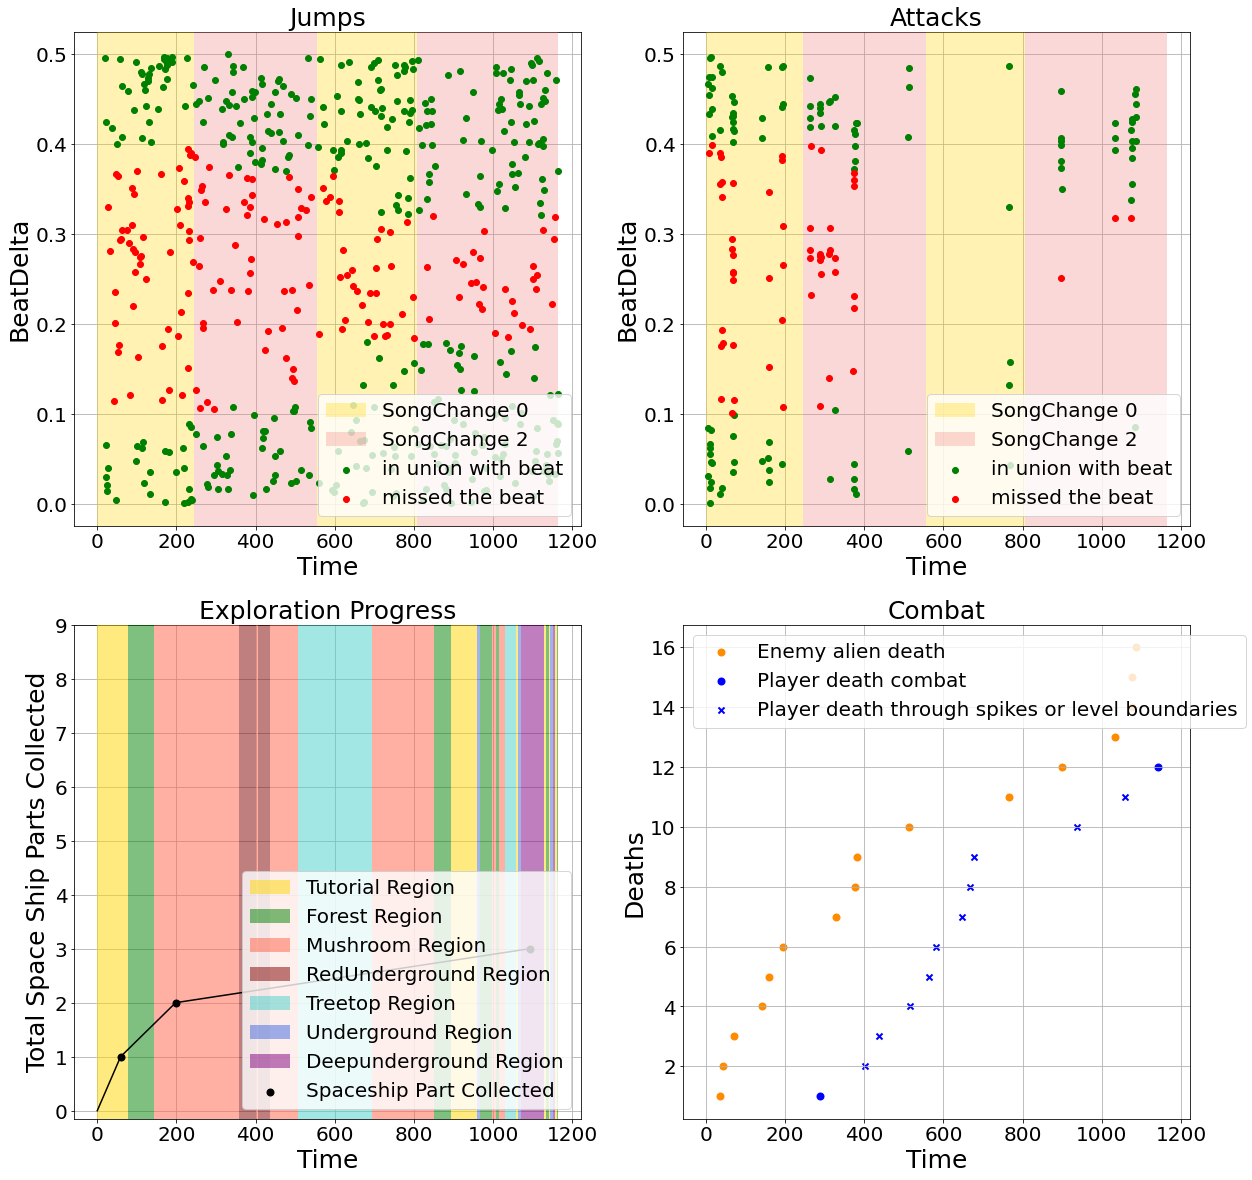

527704_NoRhythm_30_11_21_10_40_Beat_Metric.csv 527704_NoRhythm_30_11_21_10_40_Various_Metric.csv 527704_NoRhythm_30_11_21_10_40_Combat_Metric.csv
Jumps hits: 336/842 = 39.9 %
Attacks hits: 336/842 = 39.9 %
time spent in songs: {'SongChange 0': 555, 'SongChange 1': 578, 'SongChange 2': 80}
space ship parts collected: 7/9 = 77.78 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 28
time spent in regions: {'Tutorial': 150, 'Underground': 174, 'Deepunderground': 224, 'Forest': 160, 'Mushroom': 307, 'Treetop': 198, 'RedUnderground': 0, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 6, spike deaths 1
enemy deaths: 22
player damaged 8 times. Hit by 2 enemy types: {'Bat', 'Beholder'}
player healed 94
enemy damaged 43 times. 6 enemy types damaged: {'Crab', 'Slime', 'Beholder', 'Demon', 'Bat', 'Worm'}


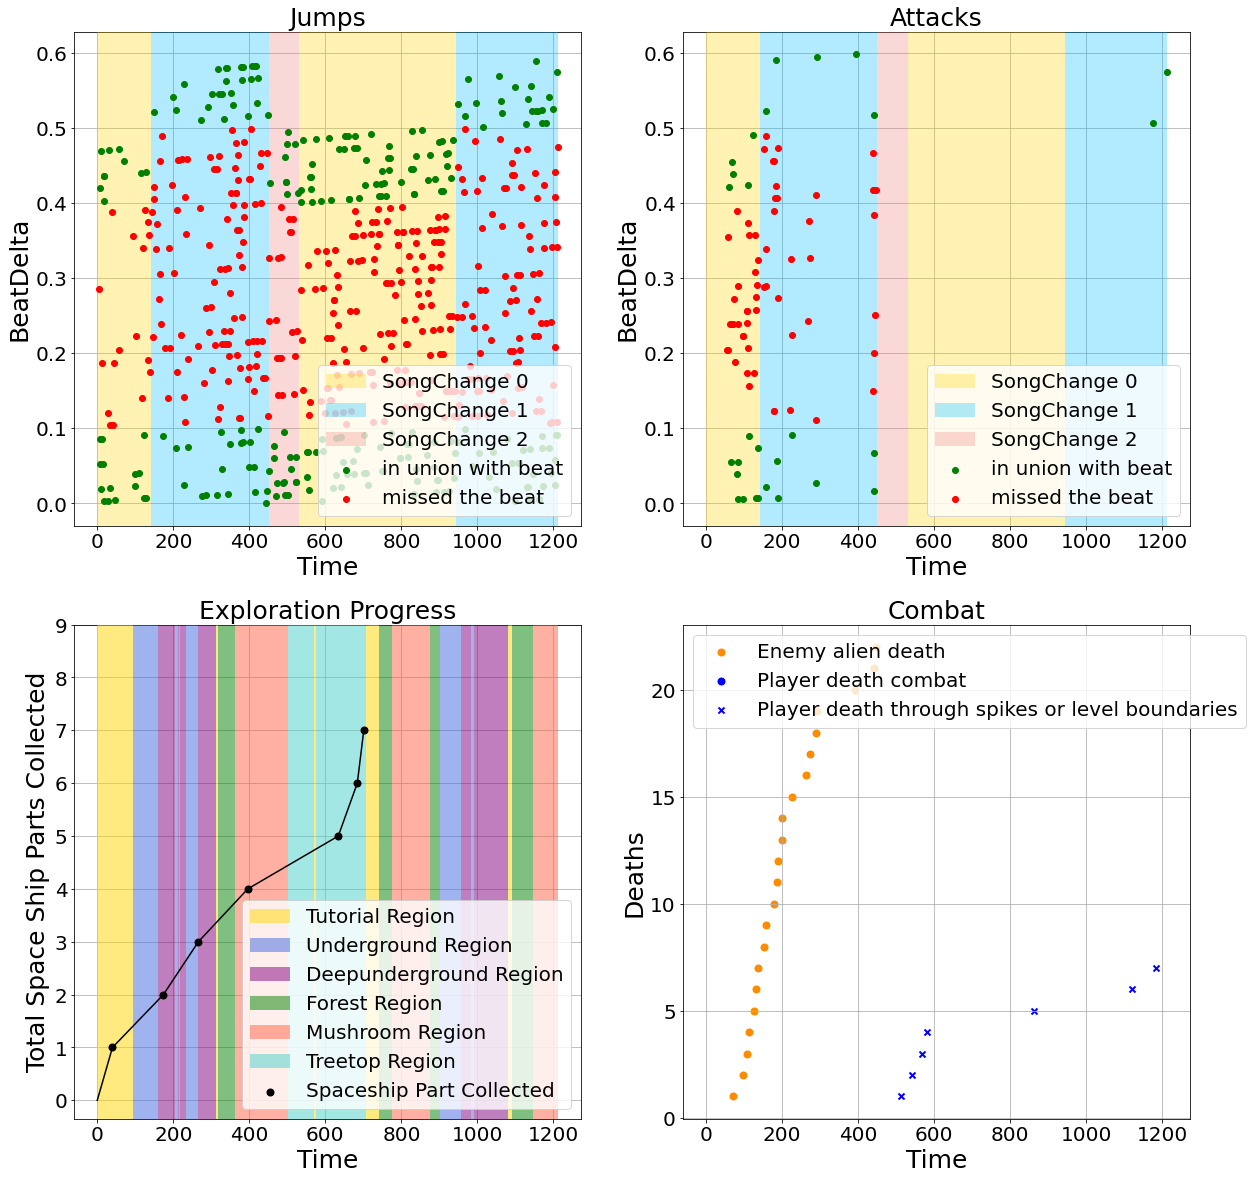

527704_RhythmControlled_30_11_21_10_11_Beat_Metric.csv 527704_RhythmControlled_30_11_21_10_11_Various_Metric.csv 527704_RhythmControlled_30_11_21_10_11_Combat_Metric.csv
Jumps hits: 320/662 = 48.34 %
Attacks hits: 320/662 = 48.34 %
time spent in songs: {'SongChange 0': 273, 'SongChange 1': 433, 'SongChange 2': 434}
space ship parts collected: 2/9 = 22.22 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 17
time spent in regions: {'Tutorial': 184, 'Underground': 146, 'Deepunderground': 9, 'Forest': 141, 'Mushroom': 347, 'Treetop': 0, 'RedUnderground': 313, 'Spider': 0}
player combat deaths: 3, player jumpnrun deaths: 0, spike deaths 4
enemy deaths: 19
player damaged 76 times. Hit by 8 enemy types: {'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}
player healed 41
enemy damaged 21 times. 8 enemy types damaged: {'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


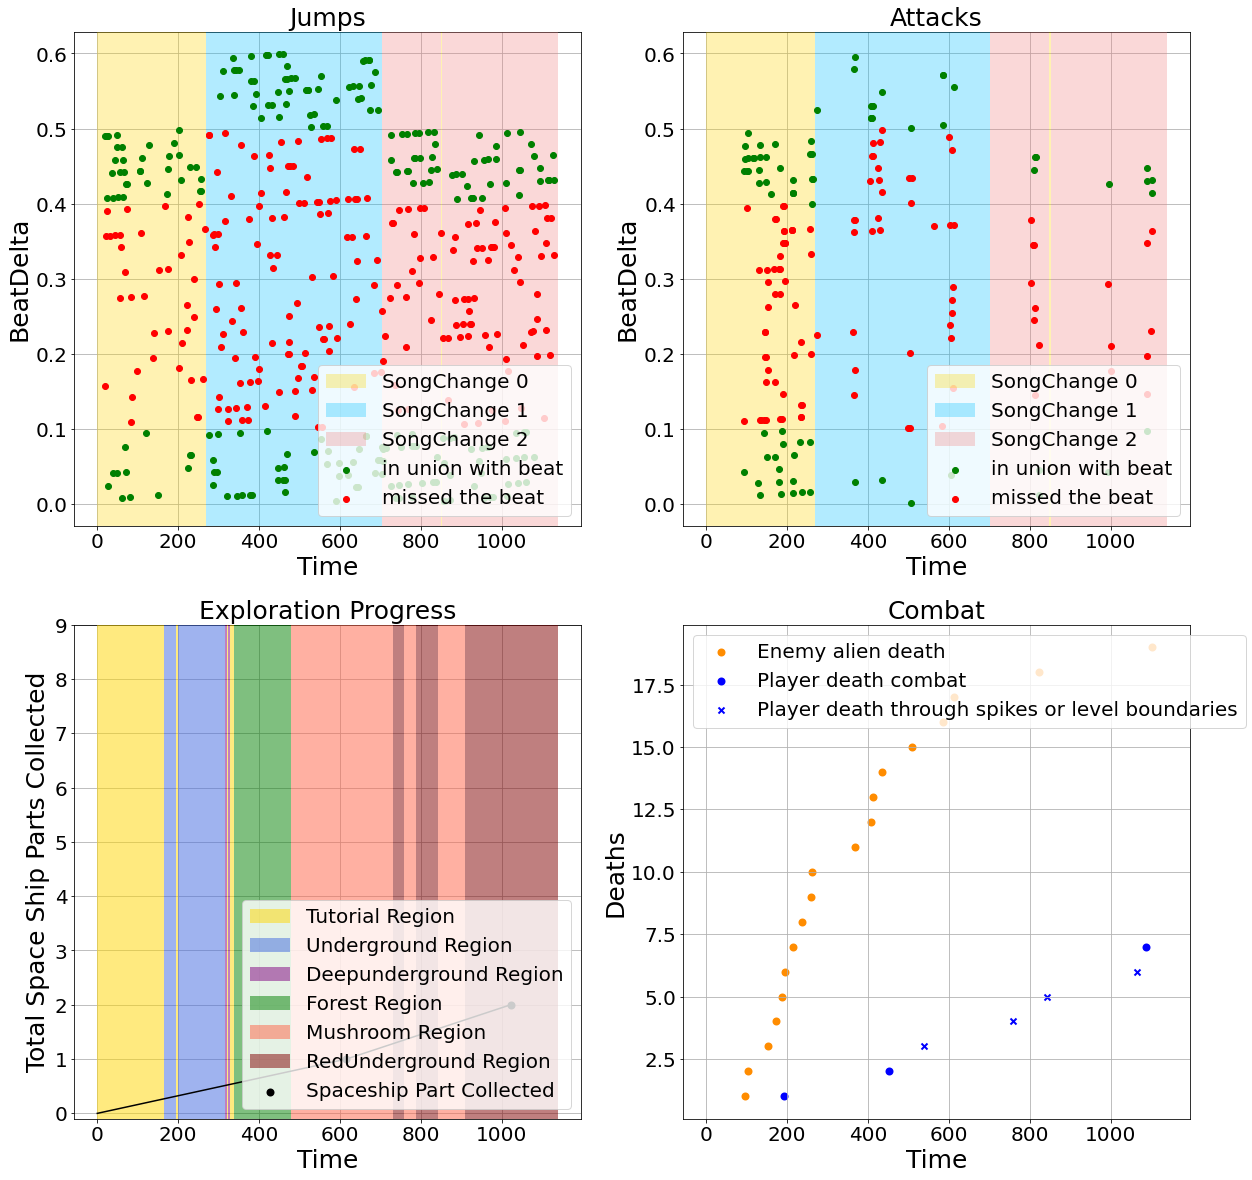

562408_NoRhythm_14_12_21_05_12_Beat_Metric.csv 562408_NoRhythm_14_12_21_05_12_Various_Metric.csv 562408_NoRhythm_14_12_21_05_12_Combat_Metric.csv
Jumps hits: 195/497 = 39.24 %
Attacks hits: 195/497 = 39.24 %
time spent in songs: {'SongChange 0': 368, 'SongChange 1': 0, 'SongChange 2': 364}
space ship parts collected: 1/9 = 11.11 %
unique regions discovered: 4/8 = 50.0 %
total region changes: 13
time spent in regions: {'Tutorial': 120, 'Underground': 0, 'Deepunderground': 0, 'Forest': 129, 'Mushroom': 437, 'Treetop': 0, 'RedUnderground': 46, 'Spider': 0}
player combat deaths: 1, player jumpnrun deaths: 0, spike deaths 1
enemy deaths: 11
player damaged 14 times. Hit by 5 enemy types: {'Plant', 'Slime', 'resetToCheckpoint', 'Spider', 'Turtle'}
player healed 16
enemy damaged 25 times. 5 enemy types damaged: {'Plant', 'Slime', 'Beholder', 'Demon', 'Worm'}


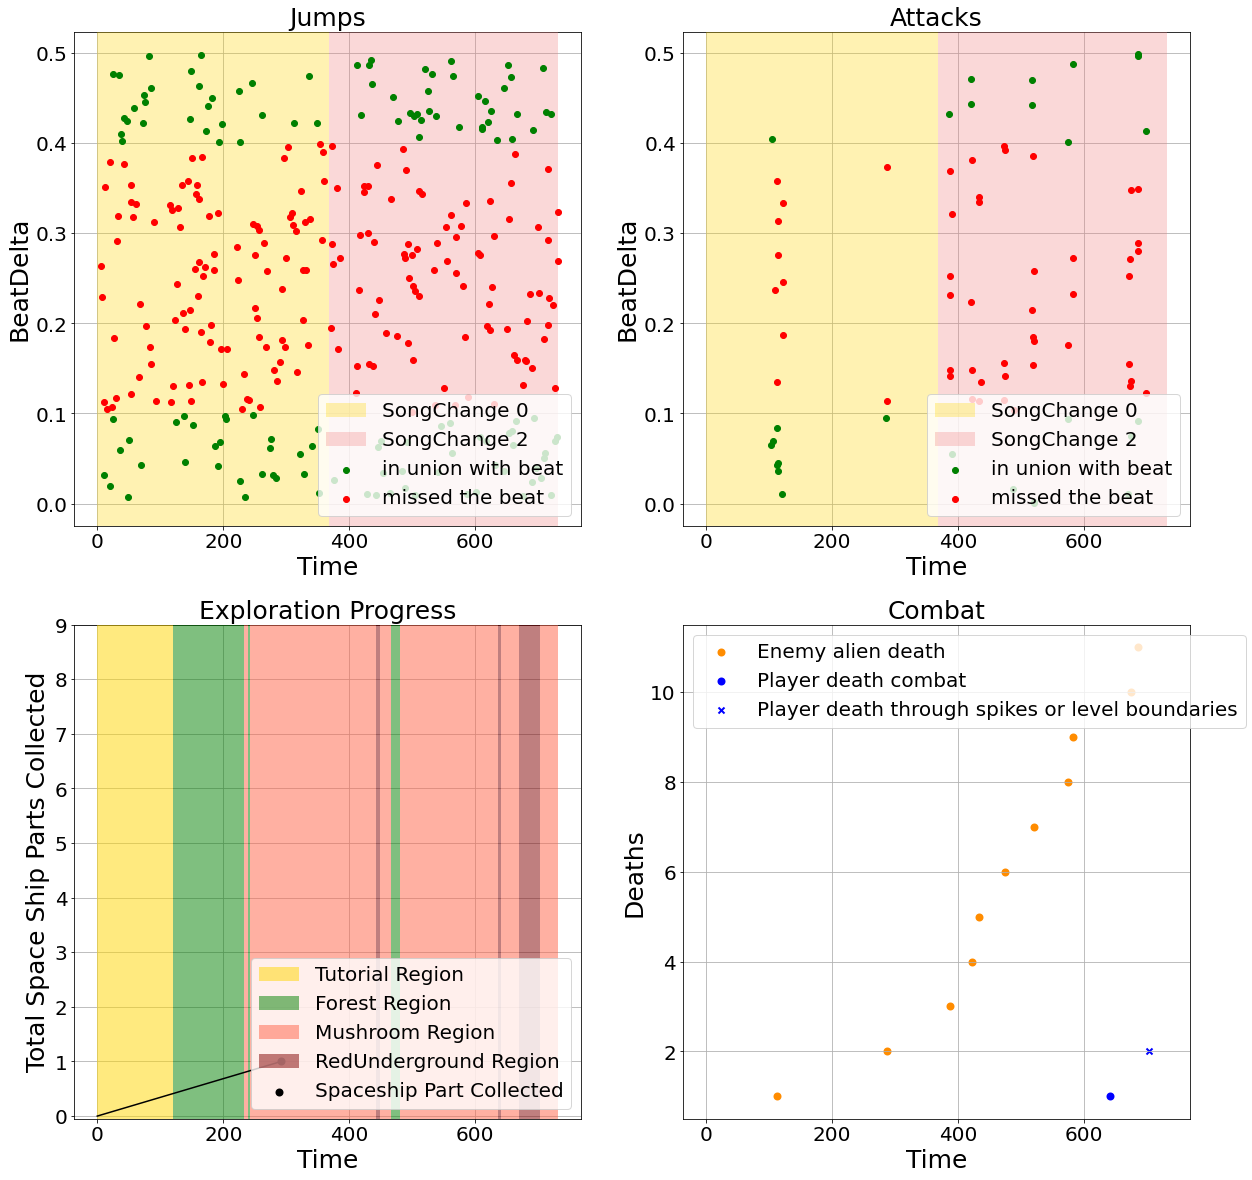

562408_RhythmControlled_14_12_21_05_32_Beat_Metric.csv 562408_RhythmControlled_14_12_21_05_32_Various_Metric.csv 562408_RhythmControlled_14_12_21_05_32_Combat_Metric.csv
Jumps hits: 279/634 = 44.01 %
Attacks hits: 279/634 = 44.01 %
time spent in songs: {'SongChange 0': 555, 'SongChange 1': 0, 'SongChange 2': 422}
space ship parts collected: 2/9 = 22.22 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 19
time spent in regions: {'Tutorial': 91, 'Underground': 16, 'Deepunderground': 0, 'Forest': 43, 'Mushroom': 461, 'Treetop': 211, 'RedUnderground': 155, 'Spider': 0}
player combat deaths: 4, player jumpnrun deaths: 1, spike deaths 3
enemy deaths: 16
player damaged 56 times. Hit by 8 enemy types: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm'}
player healed 61
enemy damaged 24 times. 8 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm'}


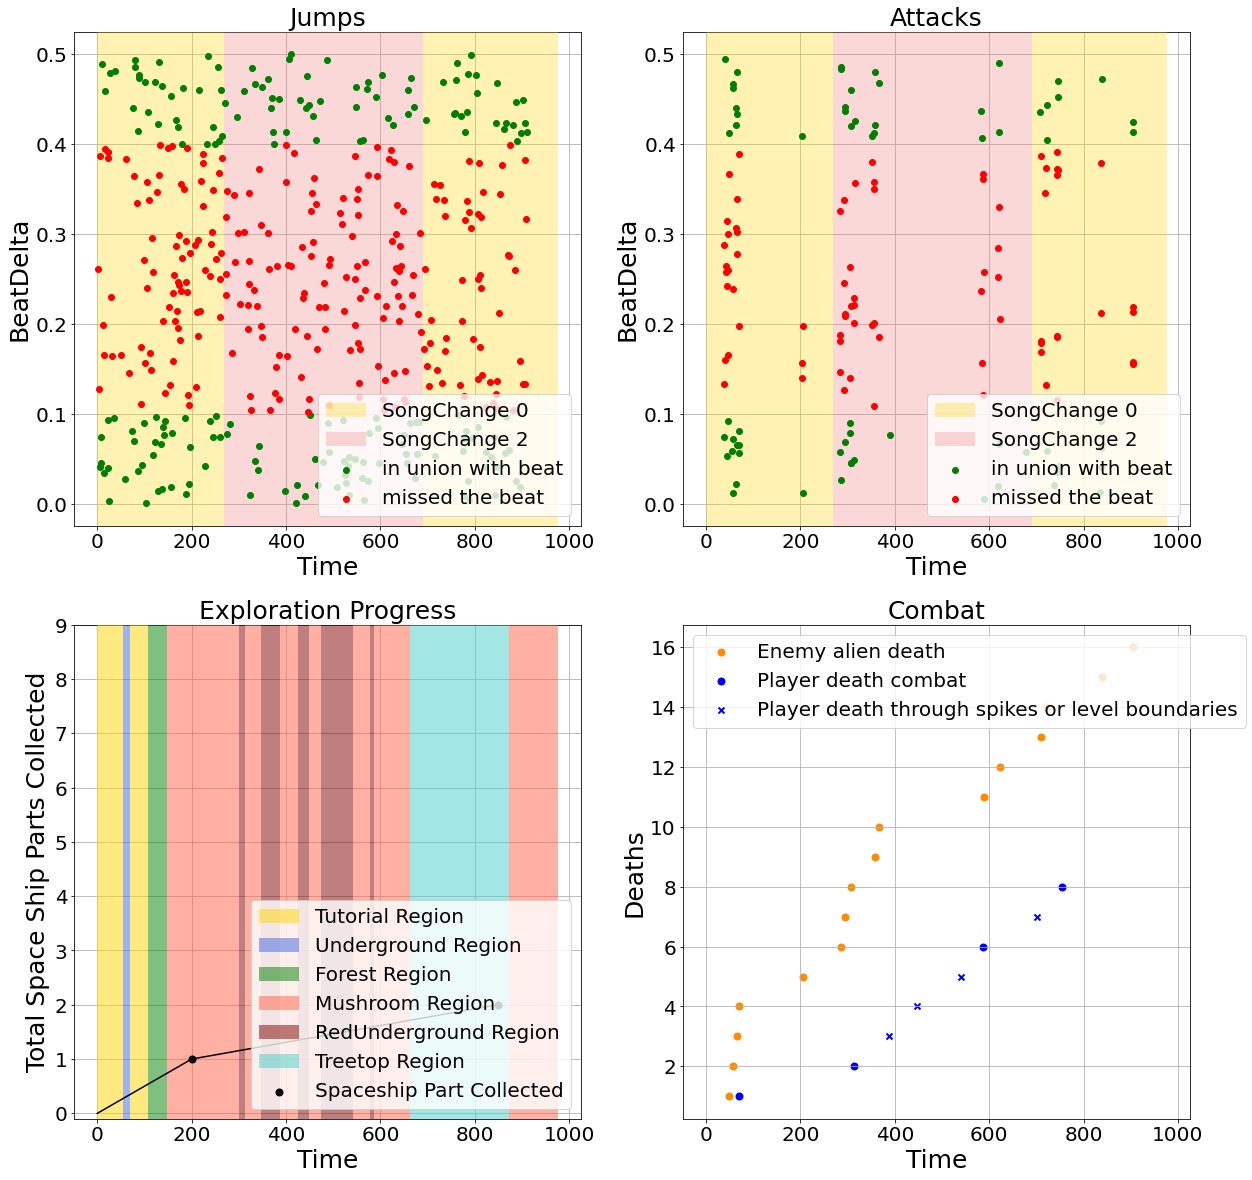

621162_NoRhythm_04_12_21_11_56_Beat_Metric.csv 621162_NoRhythm_04_12_21_11_56_Various_Metric.csv 621162_NoRhythm_04_12_21_11_56_Combat_Metric.csv
Jumps hits: 296/863 = 34.3 %
Attacks hits: 296/863 = 34.3 %
time spent in songs: {'SongChange 0': 337, 'SongChange 1': 793, 'SongChange 2': 0}
space ship parts collected: 3/9 = 33.33 %
unique regions discovered: 5/8 = 62.5 %
total region changes: 18
time spent in regions: {'Tutorial': 190, 'Underground': 367, 'Deepunderground': 224, 'Forest': 224, 'Mushroom': 125, 'Treetop': 0, 'RedUnderground': 0, 'Spider': 0}
player combat deaths: 1, player jumpnrun deaths: 1, spike deaths 0
enemy deaths: 40
player damaged 31 times. Hit by 5 enemy types: {'Crab', 'Slime', 'Beholder', 'Demon', 'Bat'}
player healed 50
enemy damaged 72 times. 7 enemy types damaged: {'Crab', 'Slime', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


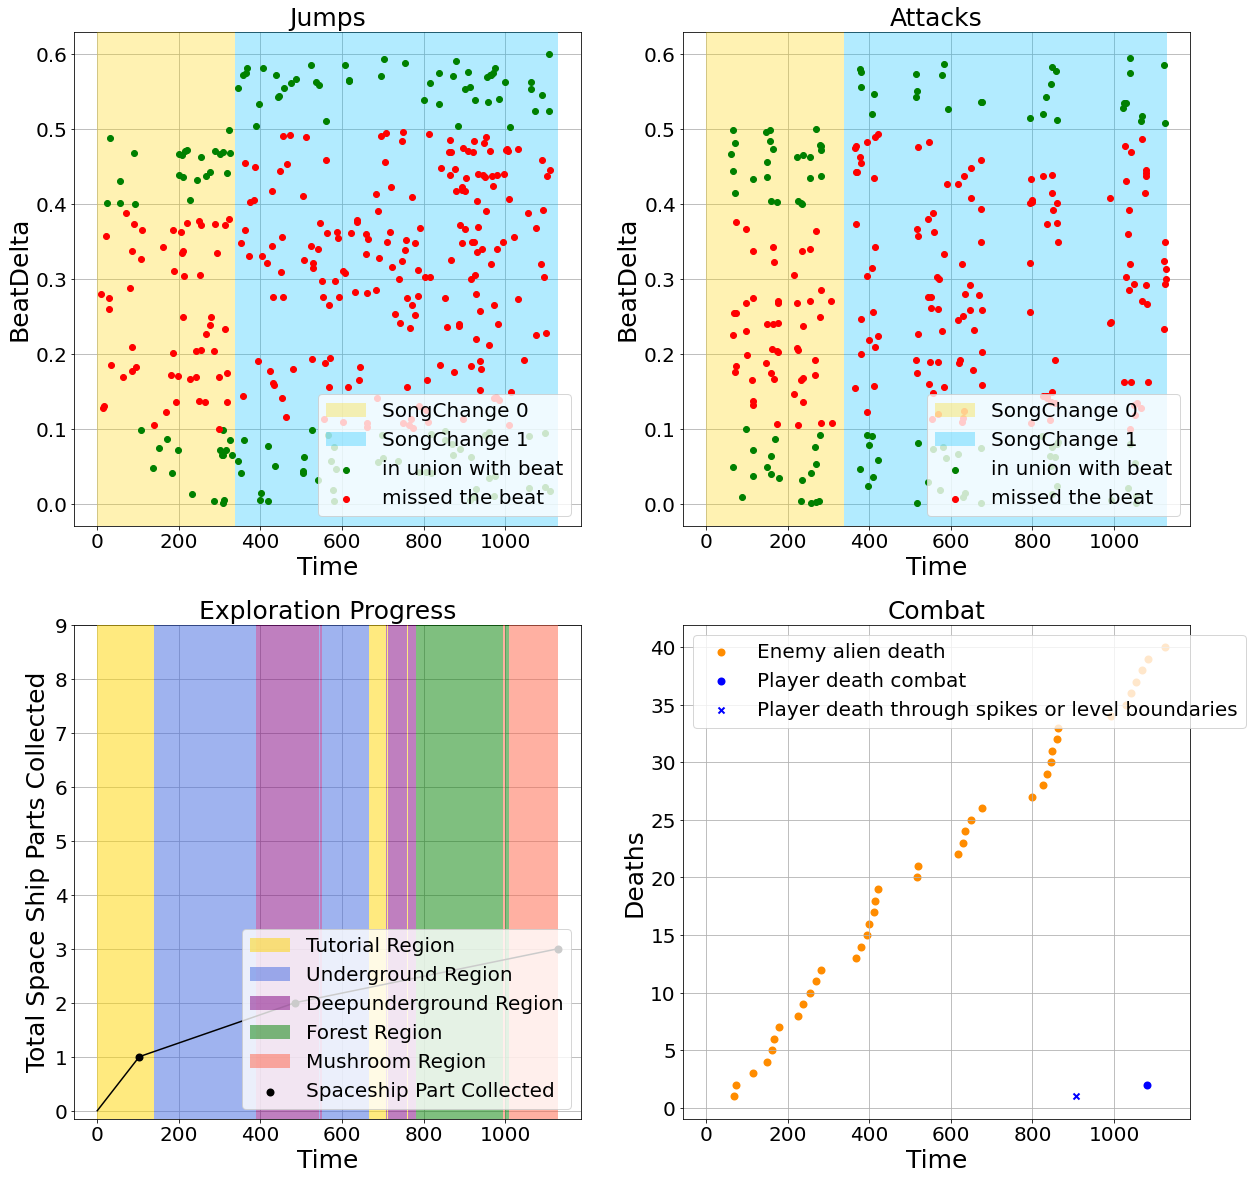

621162_RhythmControlled_04_12_21_12_35_Beat_Metric.csv 621162_RhythmControlled_04_12_21_12_35_Various_Metric.csv 621162_RhythmControlled_04_12_21_12_35_Combat_Metric.csv
Jumps hits: 374/629 = 59.46 %
Attacks hits: 374/629 = 59.46 %
time spent in songs: {'SongChange 0': 1165, 'SongChange 1': 0, 'SongChange 2': 0}
space ship parts collected: 2/9 = 22.22 %
unique regions discovered: 4/8 = 50.0 %
total region changes: 9
time spent in regions: {'Tutorial': 237, 'Underground': 190, 'Deepunderground': 0, 'Forest': 358, 'Mushroom': 380, 'Treetop': 0, 'RedUnderground': 0, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 1, spike deaths 0
enemy deaths: 15
player damaged 26 times. Hit by 4 enemy types: {'Worm', 'Crab', 'Turtle', 'Bat'}
player healed 126
enemy damaged 28 times. 5 enemy types damaged: {'Crab', 'Slime', 'Bat', 'Worm', 'Turtle'}


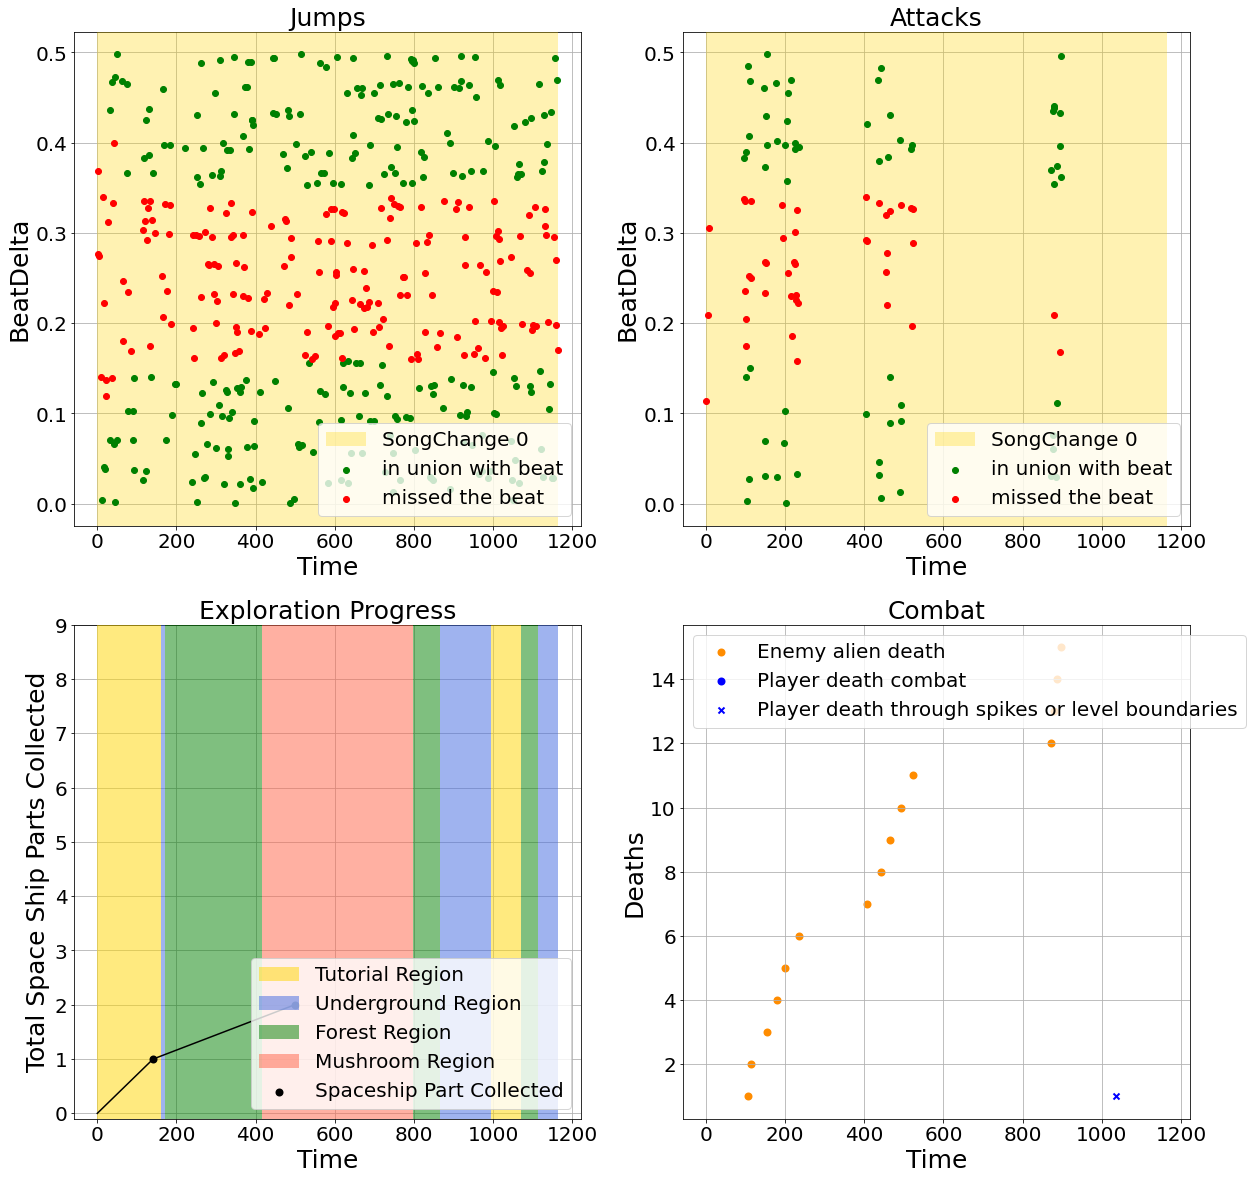

624794_NoRhythm_30_11_21_01_06_Beat_Metric.csv 624794_NoRhythm_30_11_21_01_06_Various_Metric.csv 624794_NoRhythm_30_11_21_01_06_Combat_Metric.csv
Jumps hits: 271/729 = 37.17 %
Attacks hits: 271/729 = 37.17 %
time spent in songs: {'SongChange 0': 620, 'SongChange 1': 0, 'SongChange 2': 447}
space ship parts collected: 2/9 = 22.22 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 8
time spent in regions: {'Tutorial': 130, 'Underground': 118, 'Deepunderground': 0, 'Forest': 97, 'Mushroom': 542, 'Treetop': 132, 'RedUnderground': 48, 'Spider': 0}
player combat deaths: 0, player jumpnrun deaths: 2, spike deaths 0
enemy deaths: 38
player damaged 8 times. Hit by 3 enemy types: {'Bat', 'Crab', 'Turtle'}
player healed 77
enemy damaged 85 times. 9 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Spider', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


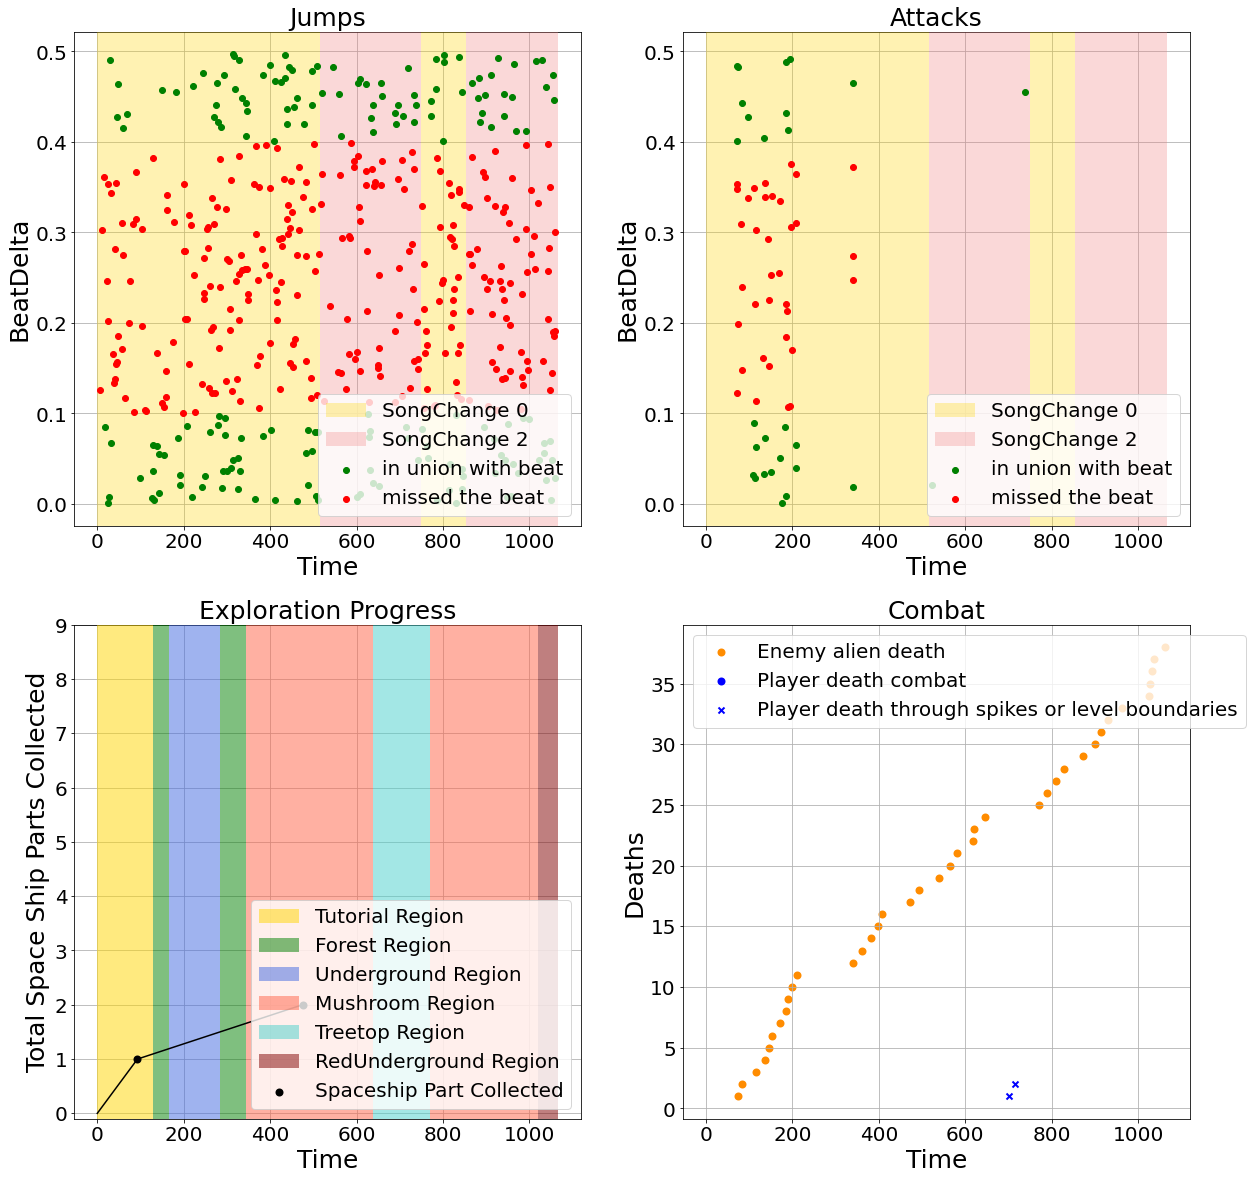

624794_RhythmControlled_30_11_21_01_33_Beat_Metric.csv 624794_RhythmControlled_30_11_21_01_33_Various_Metric.csv 624794_RhythmControlled_30_11_21_01_33_Combat_Metric.csv
Jumps hits: 407/1100 = 37.0 %
Attacks hits: 407/1100 = 37.0 %
time spent in songs: {'SongChange 0': 681, 'SongChange 1': 0, 'SongChange 2': 585}
space ship parts collected: 3/9 = 33.33 %
unique regions discovered: 6/8 = 75.0 %
total region changes: 10
time spent in regions: {'Tutorial': 236, 'Underground': 4, 'Deepunderground': 0, 'Forest': 145, 'Mushroom': 494, 'Treetop': 218, 'RedUnderground': 169, 'Spider': 0}
player combat deaths: 1, player jumpnrun deaths: 2, spike deaths 2
enemy deaths: 17
player damaged 34 times. Hit by 7 enemy types: {'Plant', 'Crab', 'Slime', 'Beholder', 'Demon', 'Worm', 'Turtle'}
player healed 64
enemy damaged 35 times. 8 enemy types damaged: {'Plant', 'Crab', 'Slime', 'Beholder', 'Demon', 'Bat', 'Worm', 'Turtle'}


In [ ]:
for beat, various, combat in zip(beat_metrics,various_metrics,combat_metrics):
    analysis_graphic(beat, various, combat)
